In [1]:
import torch
from torch import nn
import torchvision.models
import pickle

import torchvision
import torch
from torchvision.transforms import transforms
import numpy as np

In [2]:
class AverageMeter(object):
    """Computes and stores the average and current value
       Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [3]:
import dataloader_cifar as dataloader

# Dataset loader

def imagenette_dataset():
    size  = 224
    ks = (int(0.1 * size) // 2) * 2 + 1
    __imagenet_stats = {'mean': [0.485, 0.456, 0.406],
                        'std': [0.229, 0.224, 0.225]}

    #TODO: chose transforms

    train_transform = transforms.Compose([
                                            transforms.RandomResizedCrop(224),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.ToTensor(),
                                            transforms.Normalize(**__imagenet_stats)])


    val_transform = transforms.Compose([
                                            transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize(**__imagenet_stats)])

    dataset_train = torchvision.datasets.ImageFolder(os.path.join(dataset_folderpath,'train'), train_transform)
    valid_ds = torchvision.datasets.ImageFolder(os.path.join(dataset_folderpath,'val'), val_transform)

    batch_size = 64
    train_dataloader = torch.utils.data.DataLoader(
            dataset_train,
            batch_size=batch_size,
            num_workers=2,
            drop_last=True,
            shuffle=True,
    )

    val_dataloader = torch.utils.data.DataLoader(
            valid_ds,
            batch_size=batch_size,
            num_workers=2,
            drop_last=True,
            shuffle=False,
    )
    return train_dataloader, val_dataloader

loader = None

def cifar10_dataset(noise_ratio=0.9):
    noise_mode='sym'
    batch_size=32
    data_path='cifar-10-batches-py/cifar-10-batches-py/'
    global loader
    loader = dataloader.cifar_dataloader('cifar10',r=noise_ratio,noise_mode=noise_mode,batch_size=batch_size,num_workers=2,\
        root_dir=data_path,noise_file='%s/%.1f_%s.json'%(data_path,noise_ratio,noise_mode))

    # batch shape: images, noise_label, index
    train_dataloader = loader.run('warmup')

    val_dataloader = loader.run('test')
    return train_dataloader, val_dataloader


train_dataloader, val_dataloader = cifar10_dataset()

loading noise file cifar-10-batches-py/cifar-10-batches-py//0.9_sym.json


In [4]:
def validate(model, val_dataloader):

    model.eval()
    
    with torch.no_grad():

        top1_sum = 0
        top5_sum = 0
        c = 0
        for b in tqdm(val_dataloader):
            x = b[0].cuda()
            y = b[1].cuda()

            y_hat = model(x)

            acc1, acc5 = accuracy(y_hat, y, (1,5))
            top1_sum += y.shape[0] * acc1
            top5_sum += y.shape[0] * acc5
            c += y.shape[0]
        
        top1_acc = top1_sum.item() / c
        top5_acc = top5_sum / c
        print(f"validation acc: top-1: {top1_acc}, top-5: {top5_acc}")
        return top1_acc, top5_acc



In [5]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].flatten().float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [6]:
from collections import OrderedDict
snapshot_name = "simclr_chkpnt/ckpt_cifar10_resnet50.pth"


def fix_state_dict(state_dict):
    # create new OrderedDict that does not contain `module.`
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[len('encoder.module.'):] # remove `module.`
    return new_state_dict

In [7]:
def switch_encoder(model, state):
    for p in model.encoder.parameters():
        p.requires_grad = state

In [8]:
from resnet import SupCEResNet
net = "resnet50"
chekpoint = torch.load(snapshot_name)
sd = {}
for ke in chekpoint['model']:
    nk = ke.replace('module.', '')
    sd[nk] = chekpoint['model'][ke]
model = SupCEResNet(net, num_classes=10)
model.load_state_dict(sd, strict=False)
model = model.to("cuda")

In [9]:
from tqdm.notebook  import tqdm
import copy
from resnet import resnet50
# Stage-2
dw_epochs = 50
criterion = nn.CrossEntropyLoss().cuda()
print_step = 100
out_dir="cifar10/clf_learning"
switch_encoder(model, False)
# validate(model, val_dataloader)
print(f"learnable paramters: {sum(torch.numel(p) for p in model.parameters() if p.requires_grad)}")

# optimizer
lc_opt = torch.optim.SGD(model.parameters(), lr=3e-3 , momentum=0.9)
lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(lc_opt, dw_epochs, 0)
lc_opt.zero_grad()


lin_loss_log = []
lin_epoch_loss = []
acc1_hist = []
acc5_hist = []

def mlp_train():
    model.eval()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val = 0
    for epoch in range(1, dw_epochs + 1):
        total_loss = 0
        # images, noise_label, index
        for batch_idx, (x, y, index) in enumerate(tqdm(train_dataloader)):
            x = x.cuda()
            y = y.cuda()
            y_hat = model(x)
            loss = criterion(y_hat, y)
            
            lc_opt.zero_grad()
            loss.backward()
            lc_opt.step()
            
            total_loss += loss.item()
            lin_loss_log.append(loss.item())
            if batch_idx % print_step == 0:
                tqdm.write('Loss {:.4f}'.format(loss.item()))

        current_epoch_loss = total_loss/len(train_dataloader)
        lin_epoch_loss.append(current_epoch_loss)
        print('Epoch {}: mean loss={:.4f}'.format(epoch, current_epoch_loss))
        lr_sched.step()
        print(f"update lr to: {lc_opt.param_groups[0]['lr']}")
        val,val5 = validate(model, val_dataloader)
        acc1_hist.append(val)
        acc5_hist.append(val5)
        if val > best_val:
            best_val = val
            best_model_wts = copy.deepcopy(model.state_dict())

        model.train()
        print(f"learnable paramters: {sum(torch.numel(p) for p in model.parameters() if p.requires_grad)}")
        if epoch % 10 == 0:
            with open(f"{out_dir}/classifier_loss_logs.pkl", "wb") as f:
                pickle.dump([lin_loss_log, lin_epoch_loss], f)
    return best_model_wts, best_val

# wts, best_val = mlp_train()
# torch.save(wts, f"{out_dir}/final_model_wts.bin")
model.load_state_dict(torch.load(f"{out_dir}/final_model_wts.bin"))
validate(model, val_dataloader)
# validate(model, loader.run('eval_train'))

learnable paramters: 20490



validation acc: top-1: 86.7, top-5: tensor([98.6100], device='cuda:0')


(86.7, tensor([98.6100], device='cuda:0'))

<Figure size 432x288 with 0 Axes>

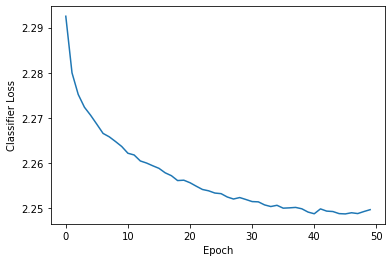

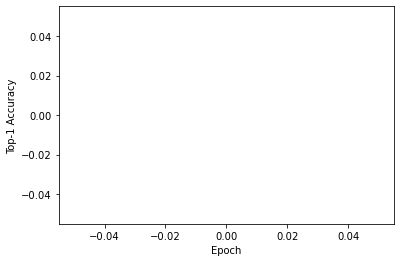

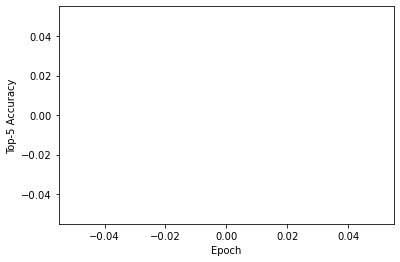

<Figure size 432x288 with 0 Axes>

In [10]:
'''Loading the Classifier Loss logs'''
with open(f"{out_dir}/classifier_loss_logs.pkl",'rb') as f:
    loss = pickle.load(f)
    f.close()
    
from matplotlib import pyplot as plt
plt.plot(loss[1])
# plt.xscale('log')
plt.xlabel('Epoch')
plt.ylabel('Classifier Loss')
plt.figure()


''' plotting the Top-1 & Top-5 accuracy'''
plt.plot(acc1_hist)
plt.xlabel('Epoch')
plt.ylabel('Top-1 Accuracy')
plt.figure()
hist5 = [a.item() for a in acc5_hist]
plt.plot(hist5)
plt.xlabel('Epoch')
plt.ylabel('Top-5 Accuracy')
plt.figure()



In [11]:
from sklearn.mixture import GaussianMixture
import dataloader_cifar as dataloader

def get_train(model, dataloader, estimate_p_right=True, p_right_threshold=0.5, p_clean_threshold=0.5, CBS=True):
    model.eval()
    losses = []
    confidence = []
    label_preds = []
    crit = nn.CrossEntropyLoss(reduction='none')
    with torch.no_grad():
        for batch_idx, (inputs, targets, index) in enumerate(dataloader):
            inputs, targets = inputs.cuda(), targets.cuda() 
            outputs = model(inputs)
            b_losses = crit(outputs, targets)
            probs, b_preds = torch.max(torch.softmax(outputs, dim=-1), dim=-1)
            confidence.append(probs)
            label_preds.append(b_preds)
            losses.append(b_losses)

    losses = torch.cat(losses, dim=0).cpu()
    confidence = torch.cat(confidence, dim=0).cpu()
    label_preds = torch.cat(label_preds, dim=0).cpu()
    losses = (losses-losses.min())/(losses.max()-losses.min())
    
    input_loss = losses.reshape(-1, 1)
    confidence = confidence.reshape(-1, 1)
    # fit a two-component GMM to the loss
    gmm1 = GaussianMixture(n_components=2,max_iter=10,tol=1e-2,reg_covar=5e-4)
    gmm1.fit(input_loss)
    prob = gmm1.predict_proba(input_loss)
    p_clean = prob[:,gmm1.means_.argmin()]
    clean = (p_clean > p_clean_threshold)
    if estimate_p_right:
        gmm2 = GaussianMixture(n_components=2,max_iter=10,tol=1e-2,reg_covar=5e-4)
        gmm2.fit(confidence)
        print(gmm2.means_)
        prob = gmm2.predict_proba(confidence)
        p_right = prob[:, gmm2.means_.argmax()]
        relabel_indicator = p_right > p_right_threshold
        return loader.run('train', clean, p_clean, CBS=CBS,relabel_indicator=relabel_indicator, label_preds=label_preds)

    return loader.run('train', clean, p_clean, CBS=CBS)


In [12]:
print('remember to change rampup when finished searching for best lambda_u')
def linear_rampup(current, rampup_length=5):
    if rampup_length == 0:
        return 1.0
    else:
        current = np.clip(current / rampup_length, 0.0, 1.0)
        return float(current)

class SemiLoss(object):
    def __call__(self, outputs_x, targets_x, outputs_u, targets_u, epoch, lambda_u=75, unsupervised_term=True):
        probs_u = torch.softmax(outputs_u, dim=1)

        Lx = -torch.mean(torch.sum(F.log_softmax(outputs_x, dim=1) * targets_x, dim=1))
        if unsupervised_term:
            Lu = torch.mean((probs_u - targets_u) ** 2)
            return (Lx, Lu, lambda_u * linear_rampup(epoch))
        return (Lx,)


remember to change rampup when finished searching for best lambda_u


In [13]:
def interleave_offsets(batch, nu):
    groups = [batch // (nu + 1)] * (nu + 1)
    for x in range(batch - sum(groups)):
        groups[-x - 1] += 1
    offsets = [0]
    for g in groups:
        offsets.append(offsets[-1] + g)
    assert offsets[-1] == batch
    return offsets


def interleave(xy, batch):
    nu = len(xy) - 1
    offsets = interleave_offsets(batch, nu)
    xy = [[v[offsets[p]:offsets[p + 1]] for p in range(nu + 1)] for v in xy]
    for i in range(1, nu + 1):
        xy[0][i], xy[i][i] = xy[i][i], xy[0][i]
    return [torch.cat(v, dim=0) for v in xy]

In [14]:
def kronecker_product(t1, t2):
    """
    Computes the Kronecker product between two tensors.
    See https://en.wikipedia.org/wiki/Kronecker_product
    """
    t1_height, t1_width = t1.shape
    t2_height, t2_width = t2.shape
    out_height = t1_height * t2_height
    out_width = t1_width * t2_width

    tiled_t2 = t2.repeat(t1_height, t1_width)
    expanded_t1 = (
        t1.unsqueeze(2)
          .unsqueeze(3)
          .repeat(1, t2_height, t2_width, 1)
          .view(out_height, out_width)
    )

    return expanded_t1 * tiled_t2

In [15]:
import torch
from torch.nn import ReLU
from torch.nn.functional import normalize

Re = ReLU()
src = torch.ones(32,10)
lab_num = 32# len(L[0])
unlab_num = 64 #len(U)
one_vec1 = torch.ones(lab_num).unsqueeze(dim=0).cuda().detach()
one_vec = torch.ones(unlab_num).unsqueeze(dim=0).cuda().detach()

def graph_structured_regularization(model, L, U, lambda_uu, lambda_lu, tau): #U-unlabled class, L-labled, 
    A_lu = None
    A_uu = None
    with torch.no_grad():
        if lambda_lu != 0:
            Z_l = model.encoder(L[0].cuda())
            Z_l = normalize(Z_l,dim=1)
        Z_u = model.encoder(U.cuda())
        Z_u = normalize(Z_u,dim=1)
        if lambda_lu != 0:
            A_lu = Re(torch.matmul(Z_l, Z_u.t())-tau)
        A_uu = Re(torch.matmul(Z_u, Z_u.t())-tau)
    y_hat = L[1]
    p = model(U.cuda())
    p = torch.softmax(p, dim=-1)
    # P_mat = kronecker_product(one_vec, p).reshape(unlab_num, unlab_num, 10)
    P_mat = p.repeat(1, unlab_num).view(unlab_num, unlab_num, 10)
    P_mat1 = P_mat[:,:32,:] # kronecker_product(one_vec1, p).reshape(unlab_num, lab_num, 10)
    # Y_mat = kronecker_product(one_vec,y_hat).reshape(lab_num, unlab_num,10)
    Y_mat = y_hat.repeat(1, unlab_num).reshape(lab_num, unlab_num,10)
    P_mat1 = torch.transpose(P_mat1,0,1)
    norm_lu = torch.mean((P_mat1 - Y_mat) **2)
    norm_uu = torch.mean((P_mat - torch.transpose(P_mat,0,1) ** 2))
    uu_term = (0.5 * lambda_uu*A_uu*norm_uu).sum()
    if lambda_lu != 0:
        lu_term = (lambda_lu*A_lu*norm_lu).sum() 
        return lu_term + uu_term
    return uu_term

In [16]:
import time
from tqdm.notebook  import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn import functional as F



def train(labeled_trainloader, unlabeled_trainloader, model, criterion, T=0.5, alpha=0.75, train_iteration=1024, graph_reg=True, unsupervised_term=True, epochs=100, exp_name=None, lambda_u=75, lambda_uu=0.005, lambda_lu=0.01):
    model.load_state_dict(torch.load(f"cifar10/clf_learning/final_model_wts.bin"))
    acc1_hist = []
    acc5_hist = []
    losses_x_hist = []
    losses_u_hist = []
    losses_r_hist = []
    best_val = 0
    switch_encoder(model, state=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    optimizer.zero_grad()
    print(f"learnable paramters: {sum(torch.numel(p) for p in model.parameters() if p.requires_grad)}")
    for epoch in range(epochs):
        batch_time = AverageMeter()
        data_time = AverageMeter()
        losses = AverageMeter()
        losses_x = AverageMeter()
        losses_u = AverageMeter()
        losses_r = AverageMeter()
        time_loss_r = AverageMeter()

        ws = AverageMeter()
        end = time.time()
        labeled_train_iter = iter(labeled_trainloader)
        unlabeled_train_iter = iter(unlabeled_trainloader)

        model.train()
        for batch_idx in tqdm(range(train_iteration)):
            try:
                inputs_x, targets_x = labeled_train_iter.next()
            except:
                labeled_train_iter = iter(labeled_trainloader)
                inputs_x, targets_x = labeled_train_iter.next()

            try:
                inputs_u, inputs_u2 = unlabeled_train_iter.next()
            except:
                unlabeled_train_iter = iter(unlabeled_trainloader)
                inputs_u, inputs_u2 = unlabeled_train_iter.next()

            # measure data loading time
            data_time.update(time.time() - end)

            batch_size = inputs_x.size(0)

            # Transform label to one-hot
            targets_x = torch.zeros(batch_size, 10).scatter_(1, targets_x.view(-1,1).long(), 1)

            inputs_x, targets_x = inputs_x.cuda(), targets_x.cuda(non_blocking=True)
            inputs_u = inputs_u.cuda()
            inputs_u2 = inputs_u2.cuda()

            with torch.no_grad():
                # compute guessed labels of unlabel samples
                outputs_u = model(inputs_u)
                outputs_u2 = model(inputs_u2)
                p = (torch.softmax(outputs_u, dim=1) + torch.softmax(outputs_u2, dim=1)) / 2
                pt = p ** (1 / T)
                targets_u = pt / pt.sum(dim=1, keepdim=True)
                targets_u = targets_u.detach()

            # mixup
            all_inputs = torch.cat([inputs_x, inputs_u, inputs_u2], dim=0)
            all_targets = torch.cat([targets_x, targets_u, targets_u], dim=0)

            l = np.random.beta(alpha, alpha)

            l = max(l, 1-l)

            idx = torch.randperm(all_inputs.size(0))

            input_a, input_b = all_inputs, all_inputs[idx]
            target_a, target_b = all_targets, all_targets[idx]

            mixed_input = l * input_a + (1 - l) * input_b
            mixed_target = l * target_a + (1 - l) * target_b

            # interleave labeled and unlabed samples between batches to get correct batchnorm calculation 
            mixed_input = list(torch.split(mixed_input, batch_size))
            mixed_input = interleave(mixed_input, batch_size)

            logits = [model(mixed_input[0])]
            for input in mixed_input[1:]:
                logits.append(model(input))

            # put interleaved samples back
            logits = interleave(logits, batch_size)
            logits_x = logits[0]
            logits_u = torch.cat(logits[1:], dim=0)

            crit_res = criterion(logits_x, mixed_target[:batch_size], logits_u, mixed_target[batch_size:], epoch+batch_idx/train_iteration, unsupervised_term=unsupervised_term, lambda_u=lambda_u)
            Lx = crit_res[0]
            loss = Lx
            if unsupervised_term:
                Lu = crit_res[1] 
                w = crit_res[2]
                loss = loss + w * Lu

            if graph_reg:
                R = graph_structured_regularization(model, (inputs_x, targets_x), torch.cat([inputs_u, inputs_u2], dim=0), lambda_uu=lambda_uu, lambda_lu=lambda_lu, tau=0.5)
                loss = loss + R


            # record loss
            losses.update(loss.item(), inputs_x.size(0))
            losses_x.update(Lx.item(), inputs_x.size(0))
            if unsupervised_term:
                losses_u.update(Lu.item(), inputs_x.size(0))
                ws.update(w, inputs_x.size(0))
            if graph_reg:
                losses_r.update(R.item(), inputs_x.size(0))
            

            # compute gradient and do SGD step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            # plot progress
            if batch_idx % 100 == 0:
                print('({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Loss: {loss:.4f} | Loss_x: {loss_x:.4f} | Loss_u: {loss_u:.4f} | Loss_R: {loss_r:.4f} | W: {w:.4f}'.format(
                            batch=batch_idx + 1,
                            size=train_iteration,
                            data=data_time.avg,
                            bt=batch_time.avg,
                            loss=losses.avg,
                            loss_x=losses_x.avg,
                            loss_u=losses_u.avg,
                            loss_r=losses_r.avg,
                            w=ws.avg,
                            ))
                losses_x_hist.append(losses_x.avg)
                if unsupervised_term:
                    losses_u_hist.append(losses_u.avg)
                if graph_reg:
                    losses_r_hist.append(losses_r.avg)

            if batch_idx % 500 == 0:
                val,val5 = validate(model, val_dataloader)
                acc1_hist.append(val)
                acc5_hist.append(val5)
                
                if val > best_val:
                    best_val = val
                    best_model_wts = copy.deepcopy(model.state_dict())
            

    torch.save({'losses_x_hist': losses_x_hist, 'losses_u_hist': losses_u_hist, 'losses_r_hist': losses_r_hist, 'best_model_wts': best_model_wts, 'best_val': best_val, 'acc1_hist': acc1_hist, 'acc5_hist': acc5_hist}, f"runs/{exp_name}.bin")



In [17]:

from matplotlib import pyplot as plt
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

def plot_result(result):
    fig, axs = plt.subplots(2,2, figsize=(25, 10))
    def get_avg_x_axs(hist):
        if len(hist) == 0:
            return [], []
        values = map(lambda t:  (t[0]%11 != 0, (((1024 * (t[0]//11)) + (t[0]% 11) * 100)/ 1024), t[1]), enumerate(hist))
        filtered_values = filter(lambda t: t[0], values)
        return zip(*map(lambda t: (t[1], t[2]), filtered_values))


    acc1_x_axs = list(map(lambda x: ((1024 * (x//3)) + [0, 500, 1000][x%3]) / 1024, range(len(result['acc1_hist']))))
    x,y = get_avg_x_axs(result['losses_x_hist'])
    axs[0,0].plot(x, y)
    axs[0,0].set_title('Lx')
    axs[0,0].set_xlabel('epoch')
    x, y = get_avg_x_axs(result['losses_r_hist'])
    axs[0,1].plot(x, y)
    axs[0,1].set_title('R')
    axs[0,1].set_xlabel('epoch')
    x, y = get_avg_x_axs(result['losses_u_hist'])
    axs[1,0].plot(x, y)
    axs[1,0].set_title('Lu')
    axs[1,0].set_xlabel('epoch')
    axs[1,1].plot(acc1_x_axs, result['acc1_hist'])
    axs[1,1].set_title('Top-1 acc')
    axs[1,1].set_xlabel('epoch')


loading noise file cifar-10-batches-py/cifar-10-batches-py//0.9_sym.json
[[0.16944785]
 [0.25150218]]
loading noise file cifar-10-batches-py/cifar-10-batches-py//0.9_sym.json
Confusion matrix before re-labeling


<Figure size 432x288 with 0 Axes>

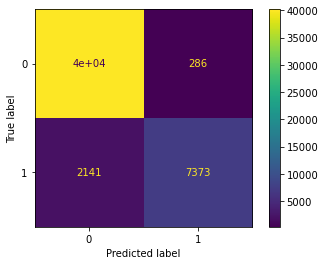

Confusion matrix after re-labeling


<Figure size 432x288 with 0 Axes>

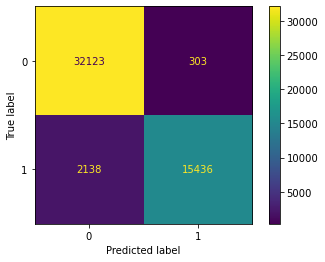

Numer of labeled samples:15739   AUC:0.665

labeled data has a size of 15739
using CBS
loading noise file cifar-10-batches-py/cifar-10-batches-py//0.9_sym.json
unlabeled data has a size of 34261
loading noise file cifar-10-batches-py/cifar-10-batches-py//0.9_sym.json
[[0.25156266]
 [0.16946916]]
loading noise file cifar-10-batches-py/cifar-10-batches-py//0.9_sym.json
Confusion matrix before re-labeling


<Figure size 432x288 with 0 Axes>

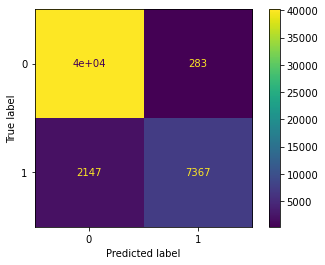

Confusion matrix after re-labeling


<Figure size 432x288 with 0 Axes>

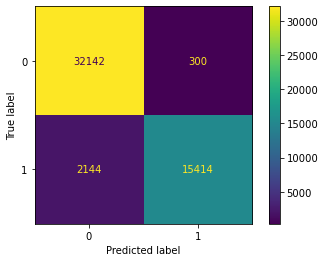

Numer of labeled samples:15714   AUC:0.665

labeled data has a size of 15714
loading noise file cifar-10-batches-py/cifar-10-batches-py//0.9_sym.json
unlabeled data has a size of 34286


In [18]:
cbs_labeled_trainloader, cbs_unlabeled_trainloader = get_train(model, loader.run('eval_train'), estimate_p_right=True, CBS=True)
labeled_trainloader, unlabeled_trainloader = get_train(model, loader.run('eval_train'), estimate_p_right=True, CBS=False)

In [19]:
# CBS: True, GMM1: true, GMM2: true, unsupervised_term: false....
# train(cbs_labeled_trainloader, cbs_unlabeled_trainloader, model, criterion=SemiLoss(), T=0.5, alpha=0.75, train_iteration=1024, unsupervised_term=True, graph_reg=True, exp_name='reproduce')

In [20]:
# CBS: True, GMM1: true, GMM2: true, unsupervised_term: false....
# train(cbs_labeled_trainloader, cbs_unlabeled_trainloader, model, criterion=SemiLoss(), T=0.5, alpha=0.75, train_iteration=1024, unsupervised_term=False, graph_reg=True, exp_name='no_unsupervised_term')

In [21]:
# exp_name='no_lambda_lu'
# train(cbs_labeled_trainloader, cbs_unlabeled_trainloader, model, criterion=SemiLoss(), T=0.5, alpha=0.75, train_iteration=1024, unsupervised_term=False, graph_reg=True, exp_name=exp_name, lambda_lu=0)
# plot_result(torch.load(f'runs/{exp_name}.bin'))

learnable paramters: 23520842


(1/1024) Data: 0.285s | Batch: 0.682s | Loss: 1.9476 | Loss_x: 1.9452 | Loss_u: 0.0000 | Loss_R: 0.0024 | W: 0.0000



validation acc: top-1: 86.85, top-5: tensor([98.5900], device='cuda:0')
(101/1024) Data: 0.056s | Batch: 0.354s | Loss: 1.2768 | Loss_x: 1.1853 | Loss_u: 0.0000 | Loss_R: 0.0916 | W: 0.0000
(201/1024) Data: 0.031s | Batch: 0.329s | Loss: 1.2538 | Loss_x: 1.1550 | Loss_u: 0.0000 | Loss_R: 0.0987 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.322s | Loss: 1.2389 | Loss_x: 1.1346 | Loss_u: 0.0000 | Loss_R: 0.1043 | W: 0.0000
(401/1024) Data: 0.018s | Batch: 0.318s | Loss: 1.2391 | Loss_x: 1.1333 | Loss_u: 0.0000 | Loss_R: 0.1058 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.316s | Loss: 1.2257 | Loss_x: 1.1167 | Loss_u: 0.0000 | Loss_R: 0.1089 | W: 0.0000



validation acc: top-1: 82.67, top-5: tensor([98.8500], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.322s | Loss: 1.2100 | Loss_x: 1.0999 | Loss_u: 0.0000 | Loss_R: 0.1101 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.320s | Loss: 1.2007 | Loss_x: 1.0887 | Loss_u: 0.0000 | Loss_R: 0.1120 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.318s | Loss: 1.1880 | Loss_x: 1.0749 | Loss_u: 0.0000 | Loss_R: 0.1130 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.317s | Loss: 1.1879 | Loss_x: 1.0734 | Loss_u: 0.0000 | Loss_R: 0.1146 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.316s | Loss: 1.1897 | Loss_x: 1.0741 | Loss_u: 0.0000 | Loss_R: 0.1157 | W: 0.0000



validation acc: top-1: 81.19, top-5: tensor([97.7500], device='cuda:0')



(1/1024) Data: 0.433s | Batch: 0.748s | Loss: 1.7571 | Loss_x: 1.7365 | Loss_u: 0.0000 | Loss_R: 0.0206 | W: 0.0000



validation acc: top-1: 85.57, top-5: tensor([98.8200], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.358s | Loss: 1.1716 | Loss_x: 1.0717 | Loss_u: 0.0000 | Loss_R: 0.1000 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.331s | Loss: 1.1507 | Loss_x: 1.0448 | Loss_u: 0.0000 | Loss_R: 0.1059 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.323s | Loss: 1.1507 | Loss_x: 1.0422 | Loss_u: 0.0000 | Loss_R: 0.1085 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.1394 | Loss_x: 1.0293 | Loss_u: 0.0000 | Loss_R: 0.1101 | W: 0.0000
(501/1024) Data: 0.017s | Batch: 0.316s | Loss: 1.1456 | Loss_x: 1.0351 | Loss_u: 0.0000 | Loss_R: 0.1106 | W: 0.0000



validation acc: top-1: 84.71, top-5: tensor([98.8100], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.323s | Loss: 1.1436 | Loss_x: 1.0332 | Loss_u: 0.0000 | Loss_R: 0.1105 | W: 0.0000
(701/1024) Data: 0.021s | Batch: 0.320s | Loss: 1.1321 | Loss_x: 1.0214 | Loss_u: 0.0000 | Loss_R: 0.1107 | W: 0.0000
(801/1024) Data: 0.019s | Batch: 0.318s | Loss: 1.1302 | Loss_x: 1.0195 | Loss_u: 0.0000 | Loss_R: 0.1107 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.317s | Loss: 1.1310 | Loss_x: 1.0205 | Loss_u: 0.0000 | Loss_R: 0.1105 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.316s | Loss: 1.1183 | Loss_x: 1.0074 | Loss_u: 0.0000 | Loss_R: 0.1109 | W: 0.0000



validation acc: top-1: 83.02, top-5: tensor([98.1000], device='cuda:0')



(1/1024) Data: 0.399s | Batch: 0.713s | Loss: 1.0213 | Loss_x: 0.9879 | Loss_u: 0.0000 | Loss_R: 0.0334 | W: 0.0000



validation acc: top-1: 86.68, top-5: tensor([98.6100], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.358s | Loss: 1.1023 | Loss_x: 1.0065 | Loss_u: 0.0000 | Loss_R: 0.0958 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.331s | Loss: 1.0703 | Loss_x: 0.9673 | Loss_u: 0.0000 | Loss_R: 0.1030 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.323s | Loss: 1.0594 | Loss_x: 0.9533 | Loss_u: 0.0000 | Loss_R: 0.1061 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.0620 | Loss_x: 0.9557 | Loss_u: 0.0000 | Loss_R: 0.1062 | W: 0.0000
(501/1024) Data: 0.017s | Batch: 0.316s | Loss: 1.0626 | Loss_x: 0.9552 | Loss_u: 0.0000 | Loss_R: 0.1075 | W: 0.0000



validation acc: top-1: 85.85, top-5: tensor([98.8500], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.323s | Loss: 1.0554 | Loss_x: 0.9468 | Loss_u: 0.0000 | Loss_R: 0.1086 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.320s | Loss: 1.0494 | Loss_x: 0.9412 | Loss_u: 0.0000 | Loss_R: 0.1083 | W: 0.0000
(801/1024) Data: 0.019s | Batch: 0.318s | Loss: 1.0543 | Loss_x: 0.9460 | Loss_u: 0.0000 | Loss_R: 0.1082 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.317s | Loss: 1.0466 | Loss_x: 0.9381 | Loss_u: 0.0000 | Loss_R: 0.1085 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.316s | Loss: 1.0489 | Loss_x: 0.9409 | Loss_u: 0.0000 | Loss_R: 0.1080 | W: 0.0000



validation acc: top-1: 83.77, top-5: tensor([98.3300], device='cuda:0')



(1/1024) Data: 0.423s | Batch: 0.744s | Loss: 1.2743 | Loss_x: 1.2305 | Loss_u: 0.0000 | Loss_R: 0.0439 | W: 0.0000



validation acc: top-1: 85.8, top-5: tensor([98.5300], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.359s | Loss: 1.0240 | Loss_x: 0.9237 | Loss_u: 0.0000 | Loss_R: 0.1003 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.332s | Loss: 1.0164 | Loss_x: 0.9134 | Loss_u: 0.0000 | Loss_R: 0.1030 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.324s | Loss: 1.0339 | Loss_x: 0.9328 | Loss_u: 0.0000 | Loss_R: 0.1010 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.0627 | Loss_x: 0.9604 | Loss_u: 0.0000 | Loss_R: 0.1023 | W: 0.0000
(501/1024) Data: 0.017s | Batch: 0.317s | Loss: 1.0685 | Loss_x: 0.9665 | Loss_u: 0.0000 | Loss_R: 0.1020 | W: 0.0000



validation acc: top-1: 84.74, top-5: tensor([98.7700], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.324s | Loss: 1.0594 | Loss_x: 0.9574 | Loss_u: 0.0000 | Loss_R: 0.1020 | W: 0.0000
(701/1024) Data: 0.021s | Batch: 0.321s | Loss: 1.0558 | Loss_x: 0.9535 | Loss_u: 0.0000 | Loss_R: 0.1024 | W: 0.0000
(801/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.0607 | Loss_x: 0.9588 | Loss_u: 0.0000 | Loss_R: 0.1019 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.318s | Loss: 1.0585 | Loss_x: 0.9571 | Loss_u: 0.0000 | Loss_R: 0.1014 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.317s | Loss: 1.0443 | Loss_x: 0.9430 | Loss_u: 0.0000 | Loss_R: 0.1013 | W: 0.0000



validation acc: top-1: 84.34, top-5: tensor([98.7900], device='cuda:0')



(1/1024) Data: 0.418s | Batch: 0.741s | Loss: 0.8479 | Loss_x: 0.7984 | Loss_u: 0.0000 | Loss_R: 0.0496 | W: 0.0000



validation acc: top-1: 85.7, top-5: tensor([98.6300], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.360s | Loss: 0.9850 | Loss_x: 0.8937 | Loss_u: 0.0000 | Loss_R: 0.0913 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.333s | Loss: 1.0102 | Loss_x: 0.9144 | Loss_u: 0.0000 | Loss_R: 0.0958 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.324s | Loss: 0.9976 | Loss_x: 0.9009 | Loss_u: 0.0000 | Loss_R: 0.0967 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.0086 | Loss_x: 0.9125 | Loss_u: 0.0000 | Loss_R: 0.0960 | W: 0.0000
(501/1024) Data: 0.017s | Batch: 0.317s | Loss: 1.0354 | Loss_x: 0.9382 | Loss_u: 0.0000 | Loss_R: 0.0971 | W: 0.0000



validation acc: top-1: 80.1, top-5: tensor([95.7000], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.323s | Loss: 1.0343 | Loss_x: 0.9361 | Loss_u: 0.0000 | Loss_R: 0.0981 | W: 0.0000
(701/1024) Data: 0.021s | Batch: 0.321s | Loss: 1.0246 | Loss_x: 0.9257 | Loss_u: 0.0000 | Loss_R: 0.0989 | W: 0.0000
(801/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.0190 | Loss_x: 0.9205 | Loss_u: 0.0000 | Loss_R: 0.0986 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.318s | Loss: 1.0283 | Loss_x: 0.9306 | Loss_u: 0.0000 | Loss_R: 0.0977 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.317s | Loss: 1.0271 | Loss_x: 0.9296 | Loss_u: 0.0000 | Loss_R: 0.0975 | W: 0.0000



validation acc: top-1: 83.25, top-5: tensor([98.2300], device='cuda:0')



(1/1024) Data: 0.451s | Batch: 0.765s | Loss: 1.2097 | Loss_x: 1.1482 | Loss_u: 0.0000 | Loss_R: 0.0615 | W: 0.0000



validation acc: top-1: 85.64, top-5: tensor([98.5700], device='cuda:0')
(101/1024) Data: 0.060s | Batch: 0.360s | Loss: 1.0305 | Loss_x: 0.9307 | Loss_u: 0.0000 | Loss_R: 0.0998 | W: 0.0000
(201/1024) Data: 0.033s | Batch: 0.333s | Loss: 0.9736 | Loss_x: 0.8735 | Loss_u: 0.0000 | Loss_R: 0.1000 | W: 0.0000
(301/1024) Data: 0.024s | Batch: 0.324s | Loss: 0.9897 | Loss_x: 0.8921 | Loss_u: 0.0000 | Loss_R: 0.0977 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.320s | Loss: 0.9913 | Loss_x: 0.8942 | Loss_u: 0.0000 | Loss_R: 0.0971 | W: 0.0000
(501/1024) Data: 0.017s | Batch: 0.317s | Loss: 0.9977 | Loss_x: 0.9009 | Loss_u: 0.0000 | Loss_R: 0.0969 | W: 0.0000



validation acc: top-1: 83.68, top-5: tensor([98.1800], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.324s | Loss: 0.9977 | Loss_x: 0.9016 | Loss_u: 0.0000 | Loss_R: 0.0961 | W: 0.0000
(701/1024) Data: 0.021s | Batch: 0.321s | Loss: 0.9953 | Loss_x: 0.8996 | Loss_u: 0.0000 | Loss_R: 0.0956 | W: 0.0000
(801/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.0019 | Loss_x: 0.9064 | Loss_u: 0.0000 | Loss_R: 0.0955 | W: 0.0000
(901/1024) Data: 0.018s | Batch: 0.318s | Loss: 1.0061 | Loss_x: 0.9111 | Loss_u: 0.0000 | Loss_R: 0.0949 | W: 0.0000
(1001/1024) Data: 0.017s | Batch: 0.317s | Loss: 1.0029 | Loss_x: 0.9080 | Loss_u: 0.0000 | Loss_R: 0.0949 | W: 0.0000



validation acc: top-1: 86.07, top-5: tensor([98.8200], device='cuda:0')



(1/1024) Data: 0.431s | Batch: 0.751s | Loss: 1.3362 | Loss_x: 1.2822 | Loss_u: 0.0000 | Loss_R: 0.0540 | W: 0.0000



validation acc: top-1: 86.52, top-5: tensor([98.4900], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.359s | Loss: 0.9662 | Loss_x: 0.8741 | Loss_u: 0.0000 | Loss_R: 0.0920 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.333s | Loss: 0.9822 | Loss_x: 0.8909 | Loss_u: 0.0000 | Loss_R: 0.0913 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.324s | Loss: 0.9930 | Loss_x: 0.9014 | Loss_u: 0.0000 | Loss_R: 0.0916 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.320s | Loss: 0.9841 | Loss_x: 0.8917 | Loss_u: 0.0000 | Loss_R: 0.0924 | W: 0.0000
(501/1024) Data: 0.017s | Batch: 0.317s | Loss: 0.9899 | Loss_x: 0.8971 | Loss_u: 0.0000 | Loss_R: 0.0928 | W: 0.0000



validation acc: top-1: 85.76, top-5: tensor([98.3500], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.323s | Loss: 0.9721 | Loss_x: 0.8785 | Loss_u: 0.0000 | Loss_R: 0.0935 | W: 0.0000
(701/1024) Data: 0.021s | Batch: 0.321s | Loss: 0.9785 | Loss_x: 0.8854 | Loss_u: 0.0000 | Loss_R: 0.0930 | W: 0.0000
(801/1024) Data: 0.019s | Batch: 0.319s | Loss: 0.9830 | Loss_x: 0.8900 | Loss_u: 0.0000 | Loss_R: 0.0930 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.318s | Loss: 0.9848 | Loss_x: 0.8926 | Loss_u: 0.0000 | Loss_R: 0.0922 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.317s | Loss: 0.9916 | Loss_x: 0.9003 | Loss_u: 0.0000 | Loss_R: 0.0913 | W: 0.0000



validation acc: top-1: 83.57, top-5: tensor([97.3100], device='cuda:0')



(1/1024) Data: 0.412s | Batch: 0.734s | Loss: 0.8597 | Loss_x: 0.8072 | Loss_u: 0.0000 | Loss_R: 0.0524 | W: 0.0000



validation acc: top-1: 86.57, top-5: tensor([98.7700], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.358s | Loss: 0.9846 | Loss_x: 0.9003 | Loss_u: 0.0000 | Loss_R: 0.0843 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.332s | Loss: 1.0279 | Loss_x: 0.9379 | Loss_u: 0.0000 | Loss_R: 0.0900 | W: 0.0000
(301/1024) Data: 0.024s | Batch: 0.324s | Loss: 1.0086 | Loss_x: 0.9166 | Loss_u: 0.0000 | Loss_R: 0.0920 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.320s | Loss: 0.9993 | Loss_x: 0.9078 | Loss_u: 0.0000 | Loss_R: 0.0915 | W: 0.0000
(501/1024) Data: 0.017s | Batch: 0.317s | Loss: 0.9870 | Loss_x: 0.8949 | Loss_u: 0.0000 | Loss_R: 0.0921 | W: 0.0000



validation acc: top-1: 84.79, top-5: tensor([98.7000], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.324s | Loss: 0.9880 | Loss_x: 0.8961 | Loss_u: 0.0000 | Loss_R: 0.0920 | W: 0.0000
(701/1024) Data: 0.021s | Batch: 0.321s | Loss: 0.9854 | Loss_x: 0.8936 | Loss_u: 0.0000 | Loss_R: 0.0918 | W: 0.0000
(801/1024) Data: 0.019s | Batch: 0.319s | Loss: 0.9788 | Loss_x: 0.8869 | Loss_u: 0.0000 | Loss_R: 0.0919 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.318s | Loss: 0.9815 | Loss_x: 0.8900 | Loss_u: 0.0000 | Loss_R: 0.0915 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.317s | Loss: 0.9788 | Loss_x: 0.8878 | Loss_u: 0.0000 | Loss_R: 0.0910 | W: 0.0000



validation acc: top-1: 84.97, top-5: tensor([97.4800], device='cuda:0')



(1/1024) Data: 0.420s | Batch: 0.744s | Loss: 0.7106 | Loss_x: 0.6406 | Loss_u: 0.0000 | Loss_R: 0.0700 | W: 0.0000



validation acc: top-1: 85.78, top-5: tensor([99.0700], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.359s | Loss: 1.0019 | Loss_x: 0.9167 | Loss_u: 0.0000 | Loss_R: 0.0852 | W: 0.0000
(201/1024) Data: 0.033s | Batch: 0.333s | Loss: 0.9896 | Loss_x: 0.8999 | Loss_u: 0.0000 | Loss_R: 0.0896 | W: 0.0000
(301/1024) Data: 0.024s | Batch: 0.324s | Loss: 0.9743 | Loss_x: 0.8838 | Loss_u: 0.0000 | Loss_R: 0.0905 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.320s | Loss: 0.9806 | Loss_x: 0.8905 | Loss_u: 0.0000 | Loss_R: 0.0901 | W: 0.0000
(501/1024) Data: 0.017s | Batch: 0.317s | Loss: 0.9659 | Loss_x: 0.8760 | Loss_u: 0.0000 | Loss_R: 0.0899 | W: 0.0000



validation acc: top-1: 86.87, top-5: tensor([98.7200], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.324s | Loss: 0.9704 | Loss_x: 0.8805 | Loss_u: 0.0000 | Loss_R: 0.0899 | W: 0.0000
(701/1024) Data: 0.021s | Batch: 0.321s | Loss: 0.9706 | Loss_x: 0.8813 | Loss_u: 0.0000 | Loss_R: 0.0893 | W: 0.0000
(801/1024) Data: 0.019s | Batch: 0.319s | Loss: 0.9735 | Loss_x: 0.8848 | Loss_u: 0.0000 | Loss_R: 0.0886 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.318s | Loss: 0.9790 | Loss_x: 0.8905 | Loss_u: 0.0000 | Loss_R: 0.0885 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.317s | Loss: 0.9741 | Loss_x: 0.8860 | Loss_u: 0.0000 | Loss_R: 0.0881 | W: 0.0000



validation acc: top-1: 85.28, top-5: tensor([97.8600], device='cuda:0')



(1/1024) Data: 0.407s | Batch: 0.725s | Loss: 1.0454 | Loss_x: 0.9671 | Loss_u: 0.0000 | Loss_R: 0.0783 | W: 0.0000



validation acc: top-1: 85.87, top-5: tensor([98.7100], device='cuda:0')
(101/1024) Data: 0.059s | Batch: 0.360s | Loss: 1.0360 | Loss_x: 0.9459 | Loss_u: 0.0000 | Loss_R: 0.0900 | W: 0.0000
(201/1024) Data: 0.033s | Batch: 0.333s | Loss: 1.0267 | Loss_x: 0.9374 | Loss_u: 0.0000 | Loss_R: 0.0893 | W: 0.0000
(301/1024) Data: 0.024s | Batch: 0.324s | Loss: 1.0075 | Loss_x: 0.9171 | Loss_u: 0.0000 | Loss_R: 0.0904 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.320s | Loss: 0.9931 | Loss_x: 0.9037 | Loss_u: 0.0000 | Loss_R: 0.0893 | W: 0.0000
(501/1024) Data: 0.017s | Batch: 0.317s | Loss: 0.9956 | Loss_x: 0.9068 | Loss_u: 0.0000 | Loss_R: 0.0889 | W: 0.0000



validation acc: top-1: 81.64, top-5: tensor([97.8200], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.324s | Loss: 0.9919 | Loss_x: 0.9038 | Loss_u: 0.0000 | Loss_R: 0.0881 | W: 0.0000
(701/1024) Data: 0.021s | Batch: 0.321s | Loss: 0.9869 | Loss_x: 0.8993 | Loss_u: 0.0000 | Loss_R: 0.0876 | W: 0.0000
(801/1024) Data: 0.019s | Batch: 0.319s | Loss: 0.9853 | Loss_x: 0.8981 | Loss_u: 0.0000 | Loss_R: 0.0872 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.318s | Loss: 0.9789 | Loss_x: 0.8919 | Loss_u: 0.0000 | Loss_R: 0.0870 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.317s | Loss: 0.9811 | Loss_x: 0.8946 | Loss_u: 0.0000 | Loss_R: 0.0865 | W: 0.0000



validation acc: top-1: 86.84, top-5: tensor([98.5400], device='cuda:0')



(1/1024) Data: 0.422s | Batch: 0.732s | Loss: 1.4423 | Loss_x: 1.3573 | Loss_u: 0.0000 | Loss_R: 0.0850 | W: 0.0000



validation acc: top-1: 86.39, top-5: tensor([98.3200], device='cuda:0')
(101/1024) Data: 0.059s | Batch: 0.358s | Loss: 0.9246 | Loss_x: 0.8361 | Loss_u: 0.0000 | Loss_R: 0.0885 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.332s | Loss: 0.9414 | Loss_x: 0.8518 | Loss_u: 0.0000 | Loss_R: 0.0896 | W: 0.0000
(301/1024) Data: 0.024s | Batch: 0.324s | Loss: 0.9468 | Loss_x: 0.8576 | Loss_u: 0.0000 | Loss_R: 0.0892 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.319s | Loss: 0.9565 | Loss_x: 0.8673 | Loss_u: 0.0000 | Loss_R: 0.0892 | W: 0.0000
(501/1024) Data: 0.017s | Batch: 0.317s | Loss: 0.9503 | Loss_x: 0.8608 | Loss_u: 0.0000 | Loss_R: 0.0896 | W: 0.0000



validation acc: top-1: 85.75, top-5: tensor([98.3100], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.323s | Loss: 0.9484 | Loss_x: 0.8599 | Loss_u: 0.0000 | Loss_R: 0.0885 | W: 0.0000
(701/1024) Data: 0.021s | Batch: 0.321s | Loss: 0.9547 | Loss_x: 0.8661 | Loss_u: 0.0000 | Loss_R: 0.0887 | W: 0.0000
(801/1024) Data: 0.019s | Batch: 0.319s | Loss: 0.9544 | Loss_x: 0.8663 | Loss_u: 0.0000 | Loss_R: 0.0881 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.317s | Loss: 0.9458 | Loss_x: 0.8586 | Loss_u: 0.0000 | Loss_R: 0.0872 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.316s | Loss: 0.9529 | Loss_x: 0.8664 | Loss_u: 0.0000 | Loss_R: 0.0866 | W: 0.0000



validation acc: top-1: 84.5, top-5: tensor([98.4600], device='cuda:0')



(1/1024) Data: 0.427s | Batch: 0.740s | Loss: 1.5929 | Loss_x: 1.5064 | Loss_u: 0.0000 | Loss_R: 0.0865 | W: 0.0000



validation acc: top-1: 85.51, top-5: tensor([98.7900], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.358s | Loss: 1.0075 | Loss_x: 0.9197 | Loss_u: 0.0000 | Loss_R: 0.0878 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.331s | Loss: 0.9693 | Loss_x: 0.8814 | Loss_u: 0.0000 | Loss_R: 0.0879 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.323s | Loss: 0.9633 | Loss_x: 0.8765 | Loss_u: 0.0000 | Loss_R: 0.0868 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.319s | Loss: 0.9686 | Loss_x: 0.8823 | Loss_u: 0.0000 | Loss_R: 0.0863 | W: 0.0000
(501/1024) Data: 0.017s | Batch: 0.317s | Loss: 0.9558 | Loss_x: 0.8699 | Loss_u: 0.0000 | Loss_R: 0.0858 | W: 0.0000



validation acc: top-1: 84.28, top-5: tensor([98.4400], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.323s | Loss: 0.9561 | Loss_x: 0.8703 | Loss_u: 0.0000 | Loss_R: 0.0858 | W: 0.0000
(701/1024) Data: 0.021s | Batch: 0.320s | Loss: 0.9525 | Loss_x: 0.8669 | Loss_u: 0.0000 | Loss_R: 0.0856 | W: 0.0000
(801/1024) Data: 0.019s | Batch: 0.319s | Loss: 0.9487 | Loss_x: 0.8637 | Loss_u: 0.0000 | Loss_R: 0.0850 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.317s | Loss: 0.9466 | Loss_x: 0.8616 | Loss_u: 0.0000 | Loss_R: 0.0850 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.316s | Loss: 0.9486 | Loss_x: 0.8637 | Loss_u: 0.0000 | Loss_R: 0.0849 | W: 0.0000



validation acc: top-1: 84.56, top-5: tensor([97.9600], device='cuda:0')



(1/1024) Data: 0.432s | Batch: 0.748s | Loss: 1.2991 | Loss_x: 1.2102 | Loss_u: 0.0000 | Loss_R: 0.0889 | W: 0.0000



validation acc: top-1: 84.56, top-5: tensor([98.7100], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.359s | Loss: 0.9139 | Loss_x: 0.8279 | Loss_u: 0.0000 | Loss_R: 0.0860 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.333s | Loss: 0.9469 | Loss_x: 0.8595 | Loss_u: 0.0000 | Loss_R: 0.0874 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.324s | Loss: 0.9409 | Loss_x: 0.8532 | Loss_u: 0.0000 | Loss_R: 0.0877 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.319s | Loss: 0.9334 | Loss_x: 0.8465 | Loss_u: 0.0000 | Loss_R: 0.0869 | W: 0.0000
(501/1024) Data: 0.017s | Batch: 0.317s | Loss: 0.9365 | Loss_x: 0.8495 | Loss_u: 0.0000 | Loss_R: 0.0870 | W: 0.0000



validation acc: top-1: 85.85, top-5: tensor([98.2200], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.323s | Loss: 0.9330 | Loss_x: 0.8467 | Loss_u: 0.0000 | Loss_R: 0.0864 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.320s | Loss: 0.9342 | Loss_x: 0.8482 | Loss_u: 0.0000 | Loss_R: 0.0860 | W: 0.0000
(801/1024) Data: 0.019s | Batch: 0.318s | Loss: 0.9431 | Loss_x: 0.8577 | Loss_u: 0.0000 | Loss_R: 0.0853 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.317s | Loss: 0.9486 | Loss_x: 0.8645 | Loss_u: 0.0000 | Loss_R: 0.0841 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.316s | Loss: 0.9457 | Loss_x: 0.8616 | Loss_u: 0.0000 | Loss_R: 0.0841 | W: 0.0000



validation acc: top-1: 86.34, top-5: tensor([98.7400], device='cuda:0')



(1/1024) Data: 0.432s | Batch: 0.749s | Loss: 1.0815 | Loss_x: 0.9779 | Loss_u: 0.0000 | Loss_R: 0.1037 | W: 0.0000



validation acc: top-1: 85.76, top-5: tensor([98.5800], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.358s | Loss: 0.8846 | Loss_x: 0.7974 | Loss_u: 0.0000 | Loss_R: 0.0872 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.332s | Loss: 0.9161 | Loss_x: 0.8296 | Loss_u: 0.0000 | Loss_R: 0.0865 | W: 0.0000
(301/1024) Data: 0.024s | Batch: 0.324s | Loss: 0.9415 | Loss_x: 0.8564 | Loss_u: 0.0000 | Loss_R: 0.0851 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.319s | Loss: 0.9462 | Loss_x: 0.8600 | Loss_u: 0.0000 | Loss_R: 0.0862 | W: 0.0000
(501/1024) Data: 0.017s | Batch: 0.317s | Loss: 0.9426 | Loss_x: 0.8560 | Loss_u: 0.0000 | Loss_R: 0.0865 | W: 0.0000



validation acc: top-1: 84.9, top-5: tensor([98.3900], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.323s | Loss: 0.9449 | Loss_x: 0.8592 | Loss_u: 0.0000 | Loss_R: 0.0857 | W: 0.0000
(701/1024) Data: 0.021s | Batch: 0.321s | Loss: 0.9463 | Loss_x: 0.8617 | Loss_u: 0.0000 | Loss_R: 0.0847 | W: 0.0000
(801/1024) Data: 0.019s | Batch: 0.319s | Loss: 0.9427 | Loss_x: 0.8585 | Loss_u: 0.0000 | Loss_R: 0.0841 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.318s | Loss: 0.9438 | Loss_x: 0.8599 | Loss_u: 0.0000 | Loss_R: 0.0839 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.317s | Loss: 0.9465 | Loss_x: 0.8637 | Loss_u: 0.0000 | Loss_R: 0.0829 | W: 0.0000



validation acc: top-1: 84.34, top-5: tensor([98.3300], device='cuda:0')



(1/1024) Data: 0.430s | Batch: 0.747s | Loss: 1.5816 | Loss_x: 1.4766 | Loss_u: 0.0000 | Loss_R: 0.1049 | W: 0.0000



validation acc: top-1: 86.66, top-5: tensor([98.6600], device='cuda:0')
(101/1024) Data: 0.059s | Batch: 0.360s | Loss: 0.9601 | Loss_x: 0.8735 | Loss_u: 0.0000 | Loss_R: 0.0866 | W: 0.0000
(201/1024) Data: 0.033s | Batch: 0.334s | Loss: 0.9345 | Loss_x: 0.8487 | Loss_u: 0.0000 | Loss_R: 0.0858 | W: 0.0000
(301/1024) Data: 0.024s | Batch: 0.325s | Loss: 0.9302 | Loss_x: 0.8446 | Loss_u: 0.0000 | Loss_R: 0.0856 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.320s | Loss: 0.9362 | Loss_x: 0.8515 | Loss_u: 0.0000 | Loss_R: 0.0847 | W: 0.0000
(501/1024) Data: 0.017s | Batch: 0.317s | Loss: 0.9326 | Loss_x: 0.8476 | Loss_u: 0.0000 | Loss_R: 0.0850 | W: 0.0000



validation acc: top-1: 84.99, top-5: tensor([97.8800], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.324s | Loss: 0.9383 | Loss_x: 0.8538 | Loss_u: 0.0000 | Loss_R: 0.0845 | W: 0.0000
(701/1024) Data: 0.021s | Batch: 0.321s | Loss: 0.9383 | Loss_x: 0.8545 | Loss_u: 0.0000 | Loss_R: 0.0838 | W: 0.0000
(801/1024) Data: 0.019s | Batch: 0.319s | Loss: 0.9405 | Loss_x: 0.8574 | Loss_u: 0.0000 | Loss_R: 0.0831 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.318s | Loss: 0.9455 | Loss_x: 0.8627 | Loss_u: 0.0000 | Loss_R: 0.0828 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.317s | Loss: 0.9413 | Loss_x: 0.8590 | Loss_u: 0.0000 | Loss_R: 0.0823 | W: 0.0000



validation acc: top-1: 86.56, top-5: tensor([98.7100], device='cuda:0')



(1/1024) Data: 0.418s | Batch: 0.741s | Loss: 0.7167 | Loss_x: 0.6081 | Loss_u: 0.0000 | Loss_R: 0.1086 | W: 0.0000



validation acc: top-1: 86.51, top-5: tensor([98.7600], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.359s | Loss: 0.8559 | Loss_x: 0.7730 | Loss_u: 0.0000 | Loss_R: 0.0829 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.332s | Loss: 0.8983 | Loss_x: 0.8124 | Loss_u: 0.0000 | Loss_R: 0.0859 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.324s | Loss: 0.9107 | Loss_x: 0.8258 | Loss_u: 0.0000 | Loss_R: 0.0849 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.320s | Loss: 0.9109 | Loss_x: 0.8252 | Loss_u: 0.0000 | Loss_R: 0.0857 | W: 0.0000
(501/1024) Data: 0.017s | Batch: 0.317s | Loss: 0.9231 | Loss_x: 0.8379 | Loss_u: 0.0000 | Loss_R: 0.0852 | W: 0.0000



validation acc: top-1: 86.2, top-5: tensor([98.7800], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.324s | Loss: 0.9251 | Loss_x: 0.8410 | Loss_u: 0.0000 | Loss_R: 0.0841 | W: 0.0000
(701/1024) Data: 0.021s | Batch: 0.321s | Loss: 0.9199 | Loss_x: 0.8360 | Loss_u: 0.0000 | Loss_R: 0.0840 | W: 0.0000
(801/1024) Data: 0.019s | Batch: 0.319s | Loss: 0.9176 | Loss_x: 0.8344 | Loss_u: 0.0000 | Loss_R: 0.0833 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.318s | Loss: 0.9146 | Loss_x: 0.8316 | Loss_u: 0.0000 | Loss_R: 0.0830 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.317s | Loss: 0.9130 | Loss_x: 0.8303 | Loss_u: 0.0000 | Loss_R: 0.0827 | W: 0.0000



validation acc: top-1: 86.36, top-5: tensor([98.6400], device='cuda:0')



(1/1024) Data: 0.415s | Batch: 0.740s | Loss: 1.5275 | Loss_x: 1.4272 | Loss_u: 0.0000 | Loss_R: 0.1004 | W: 0.0000



validation acc: top-1: 86.57, top-5: tensor([98.7600], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.359s | Loss: 0.9440 | Loss_x: 0.8610 | Loss_u: 0.0000 | Loss_R: 0.0830 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.334s | Loss: 0.9327 | Loss_x: 0.8497 | Loss_u: 0.0000 | Loss_R: 0.0830 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.324s | Loss: 0.9135 | Loss_x: 0.8301 | Loss_u: 0.0000 | Loss_R: 0.0834 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.320s | Loss: 0.9158 | Loss_x: 0.8323 | Loss_u: 0.0000 | Loss_R: 0.0835 | W: 0.0000
(501/1024) Data: 0.017s | Batch: 0.318s | Loss: 0.9117 | Loss_x: 0.8289 | Loss_u: 0.0000 | Loss_R: 0.0829 | W: 0.0000



validation acc: top-1: 85.16, top-5: tensor([98.0100], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.324s | Loss: 0.9238 | Loss_x: 0.8413 | Loss_u: 0.0000 | Loss_R: 0.0825 | W: 0.0000
(701/1024) Data: 0.021s | Batch: 0.321s | Loss: 0.9158 | Loss_x: 0.8339 | Loss_u: 0.0000 | Loss_R: 0.0818 | W: 0.0000
(801/1024) Data: 0.019s | Batch: 0.320s | Loss: 0.9157 | Loss_x: 0.8346 | Loss_u: 0.0000 | Loss_R: 0.0810 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.318s | Loss: 0.9107 | Loss_x: 0.8303 | Loss_u: 0.0000 | Loss_R: 0.0805 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.317s | Loss: 0.9065 | Loss_x: 0.8260 | Loss_u: 0.0000 | Loss_R: 0.0805 | W: 0.0000



validation acc: top-1: 84.75, top-5: tensor([97.6000], device='cuda:0')



(1/1024) Data: 0.418s | Batch: 0.737s | Loss: 0.8022 | Loss_x: 0.6945 | Loss_u: 0.0000 | Loss_R: 0.1076 | W: 0.0000



validation acc: top-1: 86.13, top-5: tensor([98.9400], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.360s | Loss: 0.8672 | Loss_x: 0.7784 | Loss_u: 0.0000 | Loss_R: 0.0887 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.333s | Loss: 0.8685 | Loss_x: 0.7823 | Loss_u: 0.0000 | Loss_R: 0.0861 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.324s | Loss: 0.8974 | Loss_x: 0.8127 | Loss_u: 0.0000 | Loss_R: 0.0847 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.320s | Loss: 0.9040 | Loss_x: 0.8207 | Loss_u: 0.0000 | Loss_R: 0.0832 | W: 0.0000
(501/1024) Data: 0.017s | Batch: 0.317s | Loss: 0.8994 | Loss_x: 0.8163 | Loss_u: 0.0000 | Loss_R: 0.0831 | W: 0.0000



validation acc: top-1: 85.57, top-5: tensor([98.0500], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.324s | Loss: 0.8972 | Loss_x: 0.8144 | Loss_u: 0.0000 | Loss_R: 0.0828 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.321s | Loss: 0.8884 | Loss_x: 0.8057 | Loss_u: 0.0000 | Loss_R: 0.0827 | W: 0.0000
(801/1024) Data: 0.019s | Batch: 0.319s | Loss: 0.8933 | Loss_x: 0.8106 | Loss_u: 0.0000 | Loss_R: 0.0827 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.318s | Loss: 0.8936 | Loss_x: 0.8114 | Loss_u: 0.0000 | Loss_R: 0.0822 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.317s | Loss: 0.8995 | Loss_x: 0.8181 | Loss_u: 0.0000 | Loss_R: 0.0814 | W: 0.0000



validation acc: top-1: 83.89, top-5: tensor([98.4500], device='cuda:0')



(1/1024) Data: 0.434s | Batch: 0.751s | Loss: 0.6995 | Loss_x: 0.5751 | Loss_u: 0.0000 | Loss_R: 0.1244 | W: 0.0000



validation acc: top-1: 85.89, top-5: tensor([98.7600], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.359s | Loss: 0.9035 | Loss_x: 0.8195 | Loss_u: 0.0000 | Loss_R: 0.0840 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.334s | Loss: 0.9133 | Loss_x: 0.8313 | Loss_u: 0.0000 | Loss_R: 0.0820 | W: 0.0000
(301/1024) Data: 0.024s | Batch: 0.325s | Loss: 0.9208 | Loss_x: 0.8388 | Loss_u: 0.0000 | Loss_R: 0.0820 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.320s | Loss: 0.9197 | Loss_x: 0.8383 | Loss_u: 0.0000 | Loss_R: 0.0814 | W: 0.0000
(501/1024) Data: 0.017s | Batch: 0.317s | Loss: 0.9232 | Loss_x: 0.8423 | Loss_u: 0.0000 | Loss_R: 0.0809 | W: 0.0000



validation acc: top-1: 85.81, top-5: tensor([97.1100], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.324s | Loss: 0.9256 | Loss_x: 0.8458 | Loss_u: 0.0000 | Loss_R: 0.0798 | W: 0.0000
(701/1024) Data: 0.021s | Batch: 0.321s | Loss: 0.9292 | Loss_x: 0.8504 | Loss_u: 0.0000 | Loss_R: 0.0788 | W: 0.0000
(801/1024) Data: 0.019s | Batch: 0.320s | Loss: 0.9199 | Loss_x: 0.8414 | Loss_u: 0.0000 | Loss_R: 0.0785 | W: 0.0000
(901/1024) Data: 0.018s | Batch: 0.318s | Loss: 0.9138 | Loss_x: 0.8355 | Loss_u: 0.0000 | Loss_R: 0.0783 | W: 0.0000
(1001/1024) Data: 0.017s | Batch: 0.317s | Loss: 0.9154 | Loss_x: 0.8374 | Loss_u: 0.0000 | Loss_R: 0.0780 | W: 0.0000



validation acc: top-1: 86.22, top-5: tensor([98.4700], device='cuda:0')



(1/1024) Data: 0.411s | Batch: 0.730s | Loss: 0.9010 | Loss_x: 0.7702 | Loss_u: 0.0000 | Loss_R: 0.1308 | W: 0.0000



validation acc: top-1: 87.39, top-5: tensor([98.9600], device='cuda:0')
(101/1024) Data: 0.059s | Batch: 0.360s | Loss: 0.8903 | Loss_x: 0.8104 | Loss_u: 0.0000 | Loss_R: 0.0798 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.333s | Loss: 0.8679 | Loss_x: 0.7883 | Loss_u: 0.0000 | Loss_R: 0.0796 | W: 0.0000
(301/1024) Data: 0.024s | Batch: 0.324s | Loss: 0.8632 | Loss_x: 0.7833 | Loss_u: 0.0000 | Loss_R: 0.0799 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.320s | Loss: 0.8812 | Loss_x: 0.8024 | Loss_u: 0.0000 | Loss_R: 0.0788 | W: 0.0000
(501/1024) Data: 0.017s | Batch: 0.318s | Loss: 0.8800 | Loss_x: 0.8022 | Loss_u: 0.0000 | Loss_R: 0.0778 | W: 0.0000



validation acc: top-1: 85.18, top-5: tensor([98.0200], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.324s | Loss: 0.8835 | Loss_x: 0.8064 | Loss_u: 0.0000 | Loss_R: 0.0771 | W: 0.0000
(701/1024) Data: 0.021s | Batch: 0.321s | Loss: 0.8949 | Loss_x: 0.8178 | Loss_u: 0.0000 | Loss_R: 0.0770 | W: 0.0000
(801/1024) Data: 0.019s | Batch: 0.320s | Loss: 0.8984 | Loss_x: 0.8216 | Loss_u: 0.0000 | Loss_R: 0.0769 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.318s | Loss: 0.8925 | Loss_x: 0.8159 | Loss_u: 0.0000 | Loss_R: 0.0766 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.317s | Loss: 0.8984 | Loss_x: 0.8216 | Loss_u: 0.0000 | Loss_R: 0.0768 | W: 0.0000



validation acc: top-1: 85.78, top-5: tensor([98.4100], device='cuda:0')



(1/1024) Data: 0.435s | Batch: 0.749s | Loss: 0.7805 | Loss_x: 0.6321 | Loss_u: 0.0000 | Loss_R: 0.1484 | W: 0.0000



validation acc: top-1: 85.41, top-5: tensor([98.5400], device='cuda:0')
(101/1024) Data: 0.059s | Batch: 0.359s | Loss: 0.8947 | Loss_x: 0.8133 | Loss_u: 0.0000 | Loss_R: 0.0815 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.333s | Loss: 0.8789 | Loss_x: 0.7970 | Loss_u: 0.0000 | Loss_R: 0.0818 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.324s | Loss: 0.8887 | Loss_x: 0.8074 | Loss_u: 0.0000 | Loss_R: 0.0813 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.320s | Loss: 0.8969 | Loss_x: 0.8165 | Loss_u: 0.0000 | Loss_R: 0.0804 | W: 0.0000
(501/1024) Data: 0.017s | Batch: 0.318s | Loss: 0.8951 | Loss_x: 0.8149 | Loss_u: 0.0000 | Loss_R: 0.0802 | W: 0.0000



validation acc: top-1: 86.53, top-5: tensor([98.7200], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.324s | Loss: 0.9039 | Loss_x: 0.8241 | Loss_u: 0.0000 | Loss_R: 0.0798 | W: 0.0000
(701/1024) Data: 0.021s | Batch: 0.321s | Loss: 0.9181 | Loss_x: 0.8394 | Loss_u: 0.0000 | Loss_R: 0.0787 | W: 0.0000
(801/1024) Data: 0.019s | Batch: 0.320s | Loss: 0.9149 | Loss_x: 0.8370 | Loss_u: 0.0000 | Loss_R: 0.0779 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.318s | Loss: 0.9112 | Loss_x: 0.8332 | Loss_u: 0.0000 | Loss_R: 0.0780 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.317s | Loss: 0.9088 | Loss_x: 0.8309 | Loss_u: 0.0000 | Loss_R: 0.0779 | W: 0.0000



validation acc: top-1: 86.29, top-5: tensor([98.4800], device='cuda:0')



(1/1024) Data: 0.424s | Batch: 0.747s | Loss: 1.3590 | Loss_x: 1.2151 | Loss_u: 0.0000 | Loss_R: 0.1440 | W: 0.0000



validation acc: top-1: 87.3, top-5: tensor([98.7100], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.359s | Loss: 0.8151 | Loss_x: 0.7327 | Loss_u: 0.0000 | Loss_R: 0.0825 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.333s | Loss: 0.8568 | Loss_x: 0.7768 | Loss_u: 0.0000 | Loss_R: 0.0800 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.325s | Loss: 0.8659 | Loss_x: 0.7875 | Loss_u: 0.0000 | Loss_R: 0.0784 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.320s | Loss: 0.8804 | Loss_x: 0.8028 | Loss_u: 0.0000 | Loss_R: 0.0776 | W: 0.0000
(501/1024) Data: 0.017s | Batch: 0.318s | Loss: 0.8819 | Loss_x: 0.8040 | Loss_u: 0.0000 | Loss_R: 0.0779 | W: 0.0000



validation acc: top-1: 85.8, top-5: tensor([98.1900], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.325s | Loss: 0.8804 | Loss_x: 0.8028 | Loss_u: 0.0000 | Loss_R: 0.0775 | W: 0.0000
(701/1024) Data: 0.021s | Batch: 0.322s | Loss: 0.8846 | Loss_x: 0.8076 | Loss_u: 0.0000 | Loss_R: 0.0770 | W: 0.0000
(801/1024) Data: 0.019s | Batch: 0.320s | Loss: 0.8875 | Loss_x: 0.8103 | Loss_u: 0.0000 | Loss_R: 0.0772 | W: 0.0000
(901/1024) Data: 0.018s | Batch: 0.318s | Loss: 0.8892 | Loss_x: 0.8123 | Loss_u: 0.0000 | Loss_R: 0.0769 | W: 0.0000
(1001/1024) Data: 0.017s | Batch: 0.317s | Loss: 0.8838 | Loss_x: 0.8069 | Loss_u: 0.0000 | Loss_R: 0.0769 | W: 0.0000



validation acc: top-1: 86.33, top-5: tensor([97.9200], device='cuda:0')



(1/1024) Data: 0.419s | Batch: 0.734s | Loss: 1.1583 | Loss_x: 1.0137 | Loss_u: 0.0000 | Loss_R: 0.1446 | W: 0.0000



validation acc: top-1: 87.0, top-5: tensor([98.5500], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.359s | Loss: 0.9283 | Loss_x: 0.8472 | Loss_u: 0.0000 | Loss_R: 0.0811 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.333s | Loss: 0.9067 | Loss_x: 0.8289 | Loss_u: 0.0000 | Loss_R: 0.0778 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.324s | Loss: 0.8970 | Loss_x: 0.8188 | Loss_u: 0.0000 | Loss_R: 0.0782 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.320s | Loss: 0.8941 | Loss_x: 0.8157 | Loss_u: 0.0000 | Loss_R: 0.0784 | W: 0.0000
(501/1024) Data: 0.017s | Batch: 0.318s | Loss: 0.8848 | Loss_x: 0.8065 | Loss_u: 0.0000 | Loss_R: 0.0783 | W: 0.0000



validation acc: top-1: 85.19, top-5: tensor([98.0100], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.324s | Loss: 0.8798 | Loss_x: 0.8015 | Loss_u: 0.0000 | Loss_R: 0.0784 | W: 0.0000
(701/1024) Data: 0.021s | Batch: 0.321s | Loss: 0.8684 | Loss_x: 0.7899 | Loss_u: 0.0000 | Loss_R: 0.0785 | W: 0.0000
(801/1024) Data: 0.019s | Batch: 0.319s | Loss: 0.8774 | Loss_x: 0.7997 | Loss_u: 0.0000 | Loss_R: 0.0777 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.318s | Loss: 0.8748 | Loss_x: 0.7971 | Loss_u: 0.0000 | Loss_R: 0.0777 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.317s | Loss: 0.8795 | Loss_x: 0.8021 | Loss_u: 0.0000 | Loss_R: 0.0773 | W: 0.0000



validation acc: top-1: 82.85, top-5: tensor([97.7400], device='cuda:0')



(1/1024) Data: 0.417s | Batch: 0.730s | Loss: 0.5811 | Loss_x: 0.4435 | Loss_u: 0.0000 | Loss_R: 0.1375 | W: 0.0000



validation acc: top-1: 85.95, top-5: tensor([98.8500], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.358s | Loss: 0.9111 | Loss_x: 0.8322 | Loss_u: 0.0000 | Loss_R: 0.0789 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.333s | Loss: 0.9320 | Loss_x: 0.8555 | Loss_u: 0.0000 | Loss_R: 0.0764 | W: 0.0000
(301/1024) Data: 0.024s | Batch: 0.324s | Loss: 0.9246 | Loss_x: 0.8490 | Loss_u: 0.0000 | Loss_R: 0.0757 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.320s | Loss: 0.9181 | Loss_x: 0.8420 | Loss_u: 0.0000 | Loss_R: 0.0761 | W: 0.0000
(501/1024) Data: 0.017s | Batch: 0.317s | Loss: 0.9083 | Loss_x: 0.8320 | Loss_u: 0.0000 | Loss_R: 0.0763 | W: 0.0000



validation acc: top-1: 85.1, top-5: tensor([98.1500], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.324s | Loss: 0.9052 | Loss_x: 0.8289 | Loss_u: 0.0000 | Loss_R: 0.0763 | W: 0.0000
(701/1024) Data: 0.021s | Batch: 0.321s | Loss: 0.9095 | Loss_x: 0.8335 | Loss_u: 0.0000 | Loss_R: 0.0759 | W: 0.0000
(801/1024) Data: 0.019s | Batch: 0.319s | Loss: 0.9016 | Loss_x: 0.8262 | Loss_u: 0.0000 | Loss_R: 0.0754 | W: 0.0000
(901/1024) Data: 0.018s | Batch: 0.318s | Loss: 0.9002 | Loss_x: 0.8252 | Loss_u: 0.0000 | Loss_R: 0.0750 | W: 0.0000
(1001/1024) Data: 0.017s | Batch: 0.317s | Loss: 0.9013 | Loss_x: 0.8263 | Loss_u: 0.0000 | Loss_R: 0.0750 | W: 0.0000



validation acc: top-1: 85.68, top-5: tensor([97.6500], device='cuda:0')



(1/1024) Data: 0.429s | Batch: 0.743s | Loss: 0.5490 | Loss_x: 0.3892 | Loss_u: 0.0000 | Loss_R: 0.1597 | W: 0.0000



validation acc: top-1: 87.22, top-5: tensor([98.8900], device='cuda:0')
(101/1024) Data: 0.059s | Batch: 0.361s | Loss: 0.8263 | Loss_x: 0.7483 | Loss_u: 0.0000 | Loss_R: 0.0780 | W: 0.0000
(201/1024) Data: 0.033s | Batch: 0.333s | Loss: 0.8333 | Loss_x: 0.7534 | Loss_u: 0.0000 | Loss_R: 0.0799 | W: 0.0000
(301/1024) Data: 0.024s | Batch: 0.324s | Loss: 0.8349 | Loss_x: 0.7559 | Loss_u: 0.0000 | Loss_R: 0.0790 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.320s | Loss: 0.8499 | Loss_x: 0.7711 | Loss_u: 0.0000 | Loss_R: 0.0788 | W: 0.0000
(501/1024) Data: 0.017s | Batch: 0.318s | Loss: 0.8511 | Loss_x: 0.7725 | Loss_u: 0.0000 | Loss_R: 0.0786 | W: 0.0000



validation acc: top-1: 88.26, top-5: tensor([98.9600], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.324s | Loss: 0.8571 | Loss_x: 0.7795 | Loss_u: 0.0000 | Loss_R: 0.0776 | W: 0.0000
(701/1024) Data: 0.021s | Batch: 0.321s | Loss: 0.8672 | Loss_x: 0.7907 | Loss_u: 0.0000 | Loss_R: 0.0766 | W: 0.0000
(801/1024) Data: 0.019s | Batch: 0.320s | Loss: 0.8584 | Loss_x: 0.7818 | Loss_u: 0.0000 | Loss_R: 0.0766 | W: 0.0000
(901/1024) Data: 0.018s | Batch: 0.318s | Loss: 0.8672 | Loss_x: 0.7909 | Loss_u: 0.0000 | Loss_R: 0.0764 | W: 0.0000
(1001/1024) Data: 0.017s | Batch: 0.317s | Loss: 0.8697 | Loss_x: 0.7938 | Loss_u: 0.0000 | Loss_R: 0.0759 | W: 0.0000



validation acc: top-1: 86.83, top-5: tensor([98.5500], device='cuda:0')



(1/1024) Data: 0.424s | Batch: 0.741s | Loss: 1.5041 | Loss_x: 1.3468 | Loss_u: 0.0000 | Loss_R: 0.1573 | W: 0.0000



validation acc: top-1: 87.45, top-5: tensor([98.7400], device='cuda:0')
(101/1024) Data: 0.060s | Batch: 0.361s | Loss: 0.9098 | Loss_x: 0.8329 | Loss_u: 0.0000 | Loss_R: 0.0769 | W: 0.0000
(201/1024) Data: 0.033s | Batch: 0.334s | Loss: 0.8708 | Loss_x: 0.7919 | Loss_u: 0.0000 | Loss_R: 0.0789 | W: 0.0000
(301/1024) Data: 0.024s | Batch: 0.324s | Loss: 0.8663 | Loss_x: 0.7866 | Loss_u: 0.0000 | Loss_R: 0.0796 | W: 0.0000
(401/1024) Data: 0.020s | Batch: 0.320s | Loss: 0.8620 | Loss_x: 0.7831 | Loss_u: 0.0000 | Loss_R: 0.0790 | W: 0.0000
(501/1024) Data: 0.017s | Batch: 0.318s | Loss: 0.8681 | Loss_x: 0.7902 | Loss_u: 0.0000 | Loss_R: 0.0779 | W: 0.0000



validation acc: top-1: 86.13, top-5: tensor([98.5300], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.324s | Loss: 0.8761 | Loss_x: 0.7983 | Loss_u: 0.0000 | Loss_R: 0.0778 | W: 0.0000
(701/1024) Data: 0.021s | Batch: 0.322s | Loss: 0.8818 | Loss_x: 0.8044 | Loss_u: 0.0000 | Loss_R: 0.0773 | W: 0.0000
(801/1024) Data: 0.019s | Batch: 0.320s | Loss: 0.8741 | Loss_x: 0.7973 | Loss_u: 0.0000 | Loss_R: 0.0768 | W: 0.0000
(901/1024) Data: 0.018s | Batch: 0.318s | Loss: 0.8829 | Loss_x: 0.8062 | Loss_u: 0.0000 | Loss_R: 0.0767 | W: 0.0000
(1001/1024) Data: 0.017s | Batch: 0.317s | Loss: 0.8735 | Loss_x: 0.7970 | Loss_u: 0.0000 | Loss_R: 0.0764 | W: 0.0000



validation acc: top-1: 87.55, top-5: tensor([98.7500], device='cuda:0')



(1/1024) Data: 0.423s | Batch: 0.742s | Loss: 0.4494 | Loss_x: 0.2824 | Loss_u: 0.0000 | Loss_R: 0.1671 | W: 0.0000



validation acc: top-1: 86.65, top-5: tensor([98.8200], device='cuda:0')
(101/1024) Data: 0.059s | Batch: 0.360s | Loss: 0.8780 | Loss_x: 0.7972 | Loss_u: 0.0000 | Loss_R: 0.0808 | W: 0.0000
(201/1024) Data: 0.033s | Batch: 0.333s | Loss: 0.8921 | Loss_x: 0.8107 | Loss_u: 0.0000 | Loss_R: 0.0813 | W: 0.0000
(301/1024) Data: 0.024s | Batch: 0.324s | Loss: 0.9064 | Loss_x: 0.8271 | Loss_u: 0.0000 | Loss_R: 0.0793 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.319s | Loss: 0.8829 | Loss_x: 0.8030 | Loss_u: 0.0000 | Loss_R: 0.0799 | W: 0.0000
(501/1024) Data: 0.017s | Batch: 0.317s | Loss: 0.8812 | Loss_x: 0.8021 | Loss_u: 0.0000 | Loss_R: 0.0790 | W: 0.0000



validation acc: top-1: 86.66, top-5: tensor([98.8100], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.323s | Loss: 0.8766 | Loss_x: 0.7982 | Loss_u: 0.0000 | Loss_R: 0.0784 | W: 0.0000
(701/1024) Data: 0.021s | Batch: 0.321s | Loss: 0.8796 | Loss_x: 0.8017 | Loss_u: 0.0000 | Loss_R: 0.0779 | W: 0.0000
(801/1024) Data: 0.019s | Batch: 0.319s | Loss: 0.8842 | Loss_x: 0.8069 | Loss_u: 0.0000 | Loss_R: 0.0773 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.318s | Loss: 0.8876 | Loss_x: 0.8110 | Loss_u: 0.0000 | Loss_R: 0.0766 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.317s | Loss: 0.8849 | Loss_x: 0.8085 | Loss_u: 0.0000 | Loss_R: 0.0764 | W: 0.0000



validation acc: top-1: 85.34, top-5: tensor([97.4100], device='cuda:0')



(1/1024) Data: 0.419s | Batch: 0.741s | Loss: 1.2745 | Loss_x: 1.1074 | Loss_u: 0.0000 | Loss_R: 0.1671 | W: 0.0000



validation acc: top-1: 87.32, top-5: tensor([98.4300], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.359s | Loss: 0.8901 | Loss_x: 0.8131 | Loss_u: 0.0000 | Loss_R: 0.0770 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.333s | Loss: 0.8710 | Loss_x: 0.7946 | Loss_u: 0.0000 | Loss_R: 0.0764 | W: 0.0000
(301/1024) Data: 0.024s | Batch: 0.324s | Loss: 0.8663 | Loss_x: 0.7897 | Loss_u: 0.0000 | Loss_R: 0.0766 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.320s | Loss: 0.8704 | Loss_x: 0.7945 | Loss_u: 0.0000 | Loss_R: 0.0759 | W: 0.0000
(501/1024) Data: 0.017s | Batch: 0.317s | Loss: 0.8717 | Loss_x: 0.7964 | Loss_u: 0.0000 | Loss_R: 0.0752 | W: 0.0000



validation acc: top-1: 86.97, top-5: tensor([97.9900], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.322s | Loss: 0.8690 | Loss_x: 0.7944 | Loss_u: 0.0000 | Loss_R: 0.0745 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.320s | Loss: 0.8617 | Loss_x: 0.7872 | Loss_u: 0.0000 | Loss_R: 0.0745 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.318s | Loss: 0.8699 | Loss_x: 0.7955 | Loss_u: 0.0000 | Loss_R: 0.0744 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.316s | Loss: 0.8656 | Loss_x: 0.7911 | Loss_u: 0.0000 | Loss_R: 0.0745 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.315s | Loss: 0.8713 | Loss_x: 0.7968 | Loss_u: 0.0000 | Loss_R: 0.0745 | W: 0.0000



validation acc: top-1: 86.1, top-5: tensor([98.1800], device='cuda:0')



(1/1024) Data: 0.415s | Batch: 0.737s | Loss: 1.2792 | Loss_x: 1.1072 | Loss_u: 0.0000 | Loss_R: 0.1720 | W: 0.0000



validation acc: top-1: 86.39, top-5: tensor([98.8600], device='cuda:0')
(101/1024) Data: 0.056s | Batch: 0.353s | Loss: 0.8840 | Loss_x: 0.8133 | Loss_u: 0.0000 | Loss_R: 0.0707 | W: 0.0000
(201/1024) Data: 0.031s | Batch: 0.326s | Loss: 0.8777 | Loss_x: 0.8053 | Loss_u: 0.0000 | Loss_R: 0.0724 | W: 0.0000
(301/1024) Data: 0.022s | Batch: 0.317s | Loss: 0.8698 | Loss_x: 0.7963 | Loss_u: 0.0000 | Loss_R: 0.0735 | W: 0.0000
(401/1024) Data: 0.018s | Batch: 0.314s | Loss: 0.8763 | Loss_x: 0.8032 | Loss_u: 0.0000 | Loss_R: 0.0731 | W: 0.0000
(501/1024) Data: 0.015s | Batch: 0.311s | Loss: 0.8714 | Loss_x: 0.7979 | Loss_u: 0.0000 | Loss_R: 0.0735 | W: 0.0000



validation acc: top-1: 86.71, top-5: tensor([98.1300], device='cuda:0')
(601/1024) Data: 0.021s | Batch: 0.317s | Loss: 0.8679 | Loss_x: 0.7939 | Loss_u: 0.0000 | Loss_R: 0.0740 | W: 0.0000
(701/1024) Data: 0.019s | Batch: 0.315s | Loss: 0.8616 | Loss_x: 0.7877 | Loss_u: 0.0000 | Loss_R: 0.0739 | W: 0.0000
(801/1024) Data: 0.017s | Batch: 0.313s | Loss: 0.8589 | Loss_x: 0.7853 | Loss_u: 0.0000 | Loss_R: 0.0736 | W: 0.0000
(901/1024) Data: 0.016s | Batch: 0.312s | Loss: 0.8612 | Loss_x: 0.7881 | Loss_u: 0.0000 | Loss_R: 0.0731 | W: 0.0000
(1001/1024) Data: 0.015s | Batch: 0.311s | Loss: 0.8572 | Loss_x: 0.7841 | Loss_u: 0.0000 | Loss_R: 0.0731 | W: 0.0000



validation acc: top-1: 86.58, top-5: tensor([98.2100], device='cuda:0')



(1/1024) Data: 0.407s | Batch: 0.720s | Loss: 0.9061 | Loss_x: 0.7386 | Loss_u: 0.0000 | Loss_R: 0.1676 | W: 0.0000



validation acc: top-1: 87.26, top-5: tensor([98.6200], device='cuda:0')
(101/1024) Data: 0.056s | Batch: 0.353s | Loss: 0.8932 | Loss_x: 0.8184 | Loss_u: 0.0000 | Loss_R: 0.0748 | W: 0.0000
(201/1024) Data: 0.030s | Batch: 0.327s | Loss: 0.8584 | Loss_x: 0.7841 | Loss_u: 0.0000 | Loss_R: 0.0743 | W: 0.0000
(301/1024) Data: 0.022s | Batch: 0.318s | Loss: 0.8577 | Loss_x: 0.7843 | Loss_u: 0.0000 | Loss_R: 0.0734 | W: 0.0000
(401/1024) Data: 0.018s | Batch: 0.314s | Loss: 0.8631 | Loss_x: 0.7889 | Loss_u: 0.0000 | Loss_R: 0.0741 | W: 0.0000
(501/1024) Data: 0.015s | Batch: 0.312s | Loss: 0.8697 | Loss_x: 0.7967 | Loss_u: 0.0000 | Loss_R: 0.0730 | W: 0.0000



validation acc: top-1: 85.7, top-5: tensor([97.5200], device='cuda:0')
(601/1024) Data: 0.022s | Batch: 0.318s | Loss: 0.8667 | Loss_x: 0.7939 | Loss_u: 0.0000 | Loss_R: 0.0728 | W: 0.0000
(701/1024) Data: 0.019s | Batch: 0.315s | Loss: 0.8704 | Loss_x: 0.7978 | Loss_u: 0.0000 | Loss_R: 0.0727 | W: 0.0000
(801/1024) Data: 0.017s | Batch: 0.314s | Loss: 0.8731 | Loss_x: 0.8002 | Loss_u: 0.0000 | Loss_R: 0.0728 | W: 0.0000
(901/1024) Data: 0.016s | Batch: 0.312s | Loss: 0.8657 | Loss_x: 0.7930 | Loss_u: 0.0000 | Loss_R: 0.0727 | W: 0.0000
(1001/1024) Data: 0.015s | Batch: 0.312s | Loss: 0.8648 | Loss_x: 0.7921 | Loss_u: 0.0000 | Loss_R: 0.0727 | W: 0.0000



validation acc: top-1: 84.61, top-5: tensor([96.8000], device='cuda:0')



(1/1024) Data: 0.411s | Batch: 0.726s | Loss: 1.5548 | Loss_x: 1.3818 | Loss_u: 0.0000 | Loss_R: 0.1730 | W: 0.0000



validation acc: top-1: 86.95, top-5: tensor([98.8200], device='cuda:0')
(101/1024) Data: 0.056s | Batch: 0.352s | Loss: 0.8383 | Loss_x: 0.7644 | Loss_u: 0.0000 | Loss_R: 0.0739 | W: 0.0000
(201/1024) Data: 0.031s | Batch: 0.328s | Loss: 0.8614 | Loss_x: 0.7888 | Loss_u: 0.0000 | Loss_R: 0.0727 | W: 0.0000
(301/1024) Data: 0.022s | Batch: 0.318s | Loss: 0.8598 | Loss_x: 0.7871 | Loss_u: 0.0000 | Loss_R: 0.0727 | W: 0.0000
(401/1024) Data: 0.018s | Batch: 0.314s | Loss: 0.8522 | Loss_x: 0.7798 | Loss_u: 0.0000 | Loss_R: 0.0724 | W: 0.0000
(501/1024) Data: 0.015s | Batch: 0.312s | Loss: 0.8508 | Loss_x: 0.7791 | Loss_u: 0.0000 | Loss_R: 0.0716 | W: 0.0000



validation acc: top-1: 86.69, top-5: tensor([98.1300], device='cuda:0')
(601/1024) Data: 0.022s | Batch: 0.318s | Loss: 0.8463 | Loss_x: 0.7739 | Loss_u: 0.0000 | Loss_R: 0.0724 | W: 0.0000
(701/1024) Data: 0.019s | Batch: 0.315s | Loss: 0.8518 | Loss_x: 0.7791 | Loss_u: 0.0000 | Loss_R: 0.0727 | W: 0.0000
(801/1024) Data: 0.017s | Batch: 0.314s | Loss: 0.8543 | Loss_x: 0.7818 | Loss_u: 0.0000 | Loss_R: 0.0725 | W: 0.0000
(901/1024) Data: 0.016s | Batch: 0.312s | Loss: 0.8543 | Loss_x: 0.7823 | Loss_u: 0.0000 | Loss_R: 0.0720 | W: 0.0000
(1001/1024) Data: 0.015s | Batch: 0.311s | Loss: 0.8593 | Loss_x: 0.7871 | Loss_u: 0.0000 | Loss_R: 0.0723 | W: 0.0000



validation acc: top-1: 87.07, top-5: tensor([98.4800], device='cuda:0')



(1/1024) Data: 0.412s | Batch: 0.725s | Loss: 0.7988 | Loss_x: 0.6372 | Loss_u: 0.0000 | Loss_R: 0.1616 | W: 0.0000



validation acc: top-1: 87.18, top-5: tensor([98.9700], device='cuda:0')
(101/1024) Data: 0.056s | Batch: 0.353s | Loss: 0.8895 | Loss_x: 0.8167 | Loss_u: 0.0000 | Loss_R: 0.0728 | W: 0.0000
(201/1024) Data: 0.030s | Batch: 0.326s | Loss: 0.8699 | Loss_x: 0.7955 | Loss_u: 0.0000 | Loss_R: 0.0744 | W: 0.0000
(301/1024) Data: 0.022s | Batch: 0.317s | Loss: 0.8765 | Loss_x: 0.8021 | Loss_u: 0.0000 | Loss_R: 0.0744 | W: 0.0000
(401/1024) Data: 0.017s | Batch: 0.313s | Loss: 0.8912 | Loss_x: 0.8176 | Loss_u: 0.0000 | Loss_R: 0.0736 | W: 0.0000
(501/1024) Data: 0.015s | Batch: 0.311s | Loss: 0.8954 | Loss_x: 0.8226 | Loss_u: 0.0000 | Loss_R: 0.0728 | W: 0.0000



validation acc: top-1: 85.56, top-5: tensor([97.7300], device='cuda:0')
(601/1024) Data: 0.021s | Batch: 0.318s | Loss: 0.8872 | Loss_x: 0.8143 | Loss_u: 0.0000 | Loss_R: 0.0729 | W: 0.0000
(701/1024) Data: 0.019s | Batch: 0.315s | Loss: 0.8845 | Loss_x: 0.8121 | Loss_u: 0.0000 | Loss_R: 0.0724 | W: 0.0000
(801/1024) Data: 0.017s | Batch: 0.313s | Loss: 0.8827 | Loss_x: 0.8107 | Loss_u: 0.0000 | Loss_R: 0.0720 | W: 0.0000
(901/1024) Data: 0.016s | Batch: 0.312s | Loss: 0.8774 | Loss_x: 0.8057 | Loss_u: 0.0000 | Loss_R: 0.0716 | W: 0.0000
(1001/1024) Data: 0.015s | Batch: 0.311s | Loss: 0.8722 | Loss_x: 0.8005 | Loss_u: 0.0000 | Loss_R: 0.0718 | W: 0.0000



validation acc: top-1: 86.76, top-5: tensor([98.0700], device='cuda:0')



(1/1024) Data: 0.423s | Batch: 0.740s | Loss: 0.9696 | Loss_x: 0.7945 | Loss_u: 0.0000 | Loss_R: 0.1751 | W: 0.0000



validation acc: top-1: 87.05, top-5: tensor([98.4200], device='cuda:0')
(101/1024) Data: 0.057s | Batch: 0.353s | Loss: 0.8502 | Loss_x: 0.7767 | Loss_u: 0.0000 | Loss_R: 0.0735 | W: 0.0000
(201/1024) Data: 0.031s | Batch: 0.326s | Loss: 0.8397 | Loss_x: 0.7650 | Loss_u: 0.0000 | Loss_R: 0.0747 | W: 0.0000
(301/1024) Data: 0.022s | Batch: 0.317s | Loss: 0.8612 | Loss_x: 0.7879 | Loss_u: 0.0000 | Loss_R: 0.0734 | W: 0.0000
(401/1024) Data: 0.018s | Batch: 0.314s | Loss: 0.8619 | Loss_x: 0.7892 | Loss_u: 0.0000 | Loss_R: 0.0726 | W: 0.0000
(501/1024) Data: 0.015s | Batch: 0.312s | Loss: 0.8592 | Loss_x: 0.7873 | Loss_u: 0.0000 | Loss_R: 0.0719 | W: 0.0000



validation acc: top-1: 84.88, top-5: tensor([98.2000], device='cuda:0')
(601/1024) Data: 0.022s | Batch: 0.318s | Loss: 0.8529 | Loss_x: 0.7812 | Loss_u: 0.0000 | Loss_R: 0.0718 | W: 0.0000
(701/1024) Data: 0.019s | Batch: 0.316s | Loss: 0.8574 | Loss_x: 0.7863 | Loss_u: 0.0000 | Loss_R: 0.0711 | W: 0.0000
(801/1024) Data: 0.017s | Batch: 0.314s | Loss: 0.8509 | Loss_x: 0.7800 | Loss_u: 0.0000 | Loss_R: 0.0710 | W: 0.0000
(901/1024) Data: 0.016s | Batch: 0.312s | Loss: 0.8558 | Loss_x: 0.7848 | Loss_u: 0.0000 | Loss_R: 0.0710 | W: 0.0000
(1001/1024) Data: 0.015s | Batch: 0.311s | Loss: 0.8597 | Loss_x: 0.7890 | Loss_u: 0.0000 | Loss_R: 0.0707 | W: 0.0000



validation acc: top-1: 87.25, top-5: tensor([98.4700], device='cuda:0')



(1/1024) Data: 0.439s | Batch: 0.753s | Loss: 0.9362 | Loss_x: 0.7559 | Loss_u: 0.0000 | Loss_R: 0.1803 | W: 0.0000



validation acc: top-1: 86.47, top-5: tensor([98.7200], device='cuda:0')
(101/1024) Data: 0.056s | Batch: 0.351s | Loss: 0.8500 | Loss_x: 0.7793 | Loss_u: 0.0000 | Loss_R: 0.0706 | W: 0.0000
(201/1024) Data: 0.031s | Batch: 0.327s | Loss: 0.8491 | Loss_x: 0.7770 | Loss_u: 0.0000 | Loss_R: 0.0720 | W: 0.0000
(301/1024) Data: 0.022s | Batch: 0.318s | Loss: 0.8386 | Loss_x: 0.7660 | Loss_u: 0.0000 | Loss_R: 0.0726 | W: 0.0000
(401/1024) Data: 0.018s | Batch: 0.313s | Loss: 0.8449 | Loss_x: 0.7729 | Loss_u: 0.0000 | Loss_R: 0.0720 | W: 0.0000
(501/1024) Data: 0.015s | Batch: 0.311s | Loss: 0.8494 | Loss_x: 0.7772 | Loss_u: 0.0000 | Loss_R: 0.0722 | W: 0.0000



validation acc: top-1: 85.99, top-5: tensor([98.3600], device='cuda:0')
(601/1024) Data: 0.022s | Batch: 0.318s | Loss: 0.8539 | Loss_x: 0.7827 | Loss_u: 0.0000 | Loss_R: 0.0712 | W: 0.0000
(701/1024) Data: 0.019s | Batch: 0.316s | Loss: 0.8560 | Loss_x: 0.7855 | Loss_u: 0.0000 | Loss_R: 0.0705 | W: 0.0000
(801/1024) Data: 0.017s | Batch: 0.314s | Loss: 0.8569 | Loss_x: 0.7869 | Loss_u: 0.0000 | Loss_R: 0.0699 | W: 0.0000
(901/1024) Data: 0.016s | Batch: 0.313s | Loss: 0.8602 | Loss_x: 0.7901 | Loss_u: 0.0000 | Loss_R: 0.0702 | W: 0.0000
(1001/1024) Data: 0.015s | Batch: 0.311s | Loss: 0.8576 | Loss_x: 0.7870 | Loss_u: 0.0000 | Loss_R: 0.0706 | W: 0.0000



validation acc: top-1: 84.67, top-5: tensor([98.6600], device='cuda:0')



(1/1024) Data: 0.413s | Batch: 0.725s | Loss: 0.7580 | Loss_x: 0.5858 | Loss_u: 0.0000 | Loss_R: 0.1722 | W: 0.0000



validation acc: top-1: 87.19, top-5: tensor([98.8300], device='cuda:0')
(101/1024) Data: 0.057s | Batch: 0.353s | Loss: 0.9294 | Loss_x: 0.8577 | Loss_u: 0.0000 | Loss_R: 0.0717 | W: 0.0000
(201/1024) Data: 0.031s | Batch: 0.326s | Loss: 0.8854 | Loss_x: 0.8129 | Loss_u: 0.0000 | Loss_R: 0.0725 | W: 0.0000
(301/1024) Data: 0.022s | Batch: 0.318s | Loss: 0.8790 | Loss_x: 0.8069 | Loss_u: 0.0000 | Loss_R: 0.0721 | W: 0.0000
(401/1024) Data: 0.018s | Batch: 0.314s | Loss: 0.8833 | Loss_x: 0.8112 | Loss_u: 0.0000 | Loss_R: 0.0721 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.312s | Loss: 0.8855 | Loss_x: 0.8143 | Loss_u: 0.0000 | Loss_R: 0.0712 | W: 0.0000



validation acc: top-1: 84.87, top-5: tensor([97.5700], device='cuda:0')
(601/1024) Data: 0.022s | Batch: 0.318s | Loss: 0.8840 | Loss_x: 0.8127 | Loss_u: 0.0000 | Loss_R: 0.0712 | W: 0.0000
(701/1024) Data: 0.019s | Batch: 0.316s | Loss: 0.8767 | Loss_x: 0.8054 | Loss_u: 0.0000 | Loss_R: 0.0713 | W: 0.0000
(801/1024) Data: 0.017s | Batch: 0.314s | Loss: 0.8717 | Loss_x: 0.8006 | Loss_u: 0.0000 | Loss_R: 0.0712 | W: 0.0000
(901/1024) Data: 0.016s | Batch: 0.313s | Loss: 0.8791 | Loss_x: 0.8083 | Loss_u: 0.0000 | Loss_R: 0.0709 | W: 0.0000
(1001/1024) Data: 0.015s | Batch: 0.312s | Loss: 0.8770 | Loss_x: 0.8061 | Loss_u: 0.0000 | Loss_R: 0.0709 | W: 0.0000



validation acc: top-1: 85.39, top-5: tensor([98.3400], device='cuda:0')



(1/1024) Data: 0.413s | Batch: 0.735s | Loss: 0.8495 | Loss_x: 0.6561 | Loss_u: 0.0000 | Loss_R: 0.1933 | W: 0.0000



validation acc: top-1: 87.41, top-5: tensor([99.0600], device='cuda:0')
(101/1024) Data: 0.056s | Batch: 0.351s | Loss: 0.8630 | Loss_x: 0.7930 | Loss_u: 0.0000 | Loss_R: 0.0700 | W: 0.0000
(201/1024) Data: 0.031s | Batch: 0.325s | Loss: 0.8593 | Loss_x: 0.7892 | Loss_u: 0.0000 | Loss_R: 0.0701 | W: 0.0000
(301/1024) Data: 0.022s | Batch: 0.317s | Loss: 0.8626 | Loss_x: 0.7917 | Loss_u: 0.0000 | Loss_R: 0.0709 | W: 0.0000
(401/1024) Data: 0.018s | Batch: 0.314s | Loss: 0.8628 | Loss_x: 0.7925 | Loss_u: 0.0000 | Loss_R: 0.0703 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.312s | Loss: 0.8566 | Loss_x: 0.7856 | Loss_u: 0.0000 | Loss_R: 0.0711 | W: 0.0000



validation acc: top-1: 87.19, top-5: tensor([98.1800], device='cuda:0')
(601/1024) Data: 0.022s | Batch: 0.318s | Loss: 0.8545 | Loss_x: 0.7824 | Loss_u: 0.0000 | Loss_R: 0.0721 | W: 0.0000
(701/1024) Data: 0.019s | Batch: 0.316s | Loss: 0.8530 | Loss_x: 0.7809 | Loss_u: 0.0000 | Loss_R: 0.0721 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.314s | Loss: 0.8611 | Loss_x: 0.7895 | Loss_u: 0.0000 | Loss_R: 0.0716 | W: 0.0000
(901/1024) Data: 0.016s | Batch: 0.313s | Loss: 0.8587 | Loss_x: 0.7872 | Loss_u: 0.0000 | Loss_R: 0.0715 | W: 0.0000
(1001/1024) Data: 0.015s | Batch: 0.311s | Loss: 0.8546 | Loss_x: 0.7833 | Loss_u: 0.0000 | Loss_R: 0.0714 | W: 0.0000



validation acc: top-1: 85.92, top-5: tensor([97.6500], device='cuda:0')



(1/1024) Data: 0.406s | Batch: 0.719s | Loss: 1.3295 | Loss_x: 1.1215 | Loss_u: 0.0000 | Loss_R: 0.2080 | W: 0.0000



validation acc: top-1: 87.19, top-5: tensor([98.6000], device='cuda:0')
(101/1024) Data: 0.056s | Batch: 0.351s | Loss: 0.8693 | Loss_x: 0.7964 | Loss_u: 0.0000 | Loss_R: 0.0729 | W: 0.0000
(201/1024) Data: 0.030s | Batch: 0.326s | Loss: 0.8433 | Loss_x: 0.7720 | Loss_u: 0.0000 | Loss_R: 0.0713 | W: 0.0000
(301/1024) Data: 0.022s | Batch: 0.318s | Loss: 0.8464 | Loss_x: 0.7743 | Loss_u: 0.0000 | Loss_R: 0.0720 | W: 0.0000
(401/1024) Data: 0.018s | Batch: 0.313s | Loss: 0.8392 | Loss_x: 0.7670 | Loss_u: 0.0000 | Loss_R: 0.0722 | W: 0.0000
(501/1024) Data: 0.015s | Batch: 0.311s | Loss: 0.8431 | Loss_x: 0.7718 | Loss_u: 0.0000 | Loss_R: 0.0713 | W: 0.0000



validation acc: top-1: 84.3, top-5: tensor([97.7100], device='cuda:0')
(601/1024) Data: 0.022s | Batch: 0.317s | Loss: 0.8398 | Loss_x: 0.7680 | Loss_u: 0.0000 | Loss_R: 0.0718 | W: 0.0000
(701/1024) Data: 0.019s | Batch: 0.315s | Loss: 0.8563 | Loss_x: 0.7846 | Loss_u: 0.0000 | Loss_R: 0.0717 | W: 0.0000
(801/1024) Data: 0.017s | Batch: 0.314s | Loss: 0.8492 | Loss_x: 0.7776 | Loss_u: 0.0000 | Loss_R: 0.0716 | W: 0.0000
(901/1024) Data: 0.016s | Batch: 0.312s | Loss: 0.8470 | Loss_x: 0.7752 | Loss_u: 0.0000 | Loss_R: 0.0718 | W: 0.0000
(1001/1024) Data: 0.015s | Batch: 0.311s | Loss: 0.8490 | Loss_x: 0.7775 | Loss_u: 0.0000 | Loss_R: 0.0715 | W: 0.0000



validation acc: top-1: 85.79, top-5: tensor([98.6900], device='cuda:0')



(1/1024) Data: 0.402s | Batch: 0.724s | Loss: 0.5870 | Loss_x: 0.3874 | Loss_u: 0.0000 | Loss_R: 0.1996 | W: 0.0000



validation acc: top-1: 87.31, top-5: tensor([98.8500], device='cuda:0')
(101/1024) Data: 0.056s | Batch: 0.352s | Loss: 0.8911 | Loss_x: 0.8209 | Loss_u: 0.0000 | Loss_R: 0.0702 | W: 0.0000
(201/1024) Data: 0.031s | Batch: 0.327s | Loss: 0.8688 | Loss_x: 0.7996 | Loss_u: 0.0000 | Loss_R: 0.0693 | W: 0.0000
(301/1024) Data: 0.022s | Batch: 0.318s | Loss: 0.8646 | Loss_x: 0.7943 | Loss_u: 0.0000 | Loss_R: 0.0704 | W: 0.0000
(401/1024) Data: 0.018s | Batch: 0.314s | Loss: 0.8690 | Loss_x: 0.7990 | Loss_u: 0.0000 | Loss_R: 0.0700 | W: 0.0000
(501/1024) Data: 0.015s | Batch: 0.312s | Loss: 0.8630 | Loss_x: 0.7933 | Loss_u: 0.0000 | Loss_R: 0.0697 | W: 0.0000



validation acc: top-1: 87.02, top-5: tensor([98.3100], device='cuda:0')
(601/1024) Data: 0.022s | Batch: 0.318s | Loss: 0.8514 | Loss_x: 0.7816 | Loss_u: 0.0000 | Loss_R: 0.0697 | W: 0.0000
(701/1024) Data: 0.019s | Batch: 0.316s | Loss: 0.8492 | Loss_x: 0.7797 | Loss_u: 0.0000 | Loss_R: 0.0695 | W: 0.0000
(801/1024) Data: 0.017s | Batch: 0.314s | Loss: 0.8507 | Loss_x: 0.7808 | Loss_u: 0.0000 | Loss_R: 0.0699 | W: 0.0000
(901/1024) Data: 0.016s | Batch: 0.312s | Loss: 0.8444 | Loss_x: 0.7746 | Loss_u: 0.0000 | Loss_R: 0.0699 | W: 0.0000
(1001/1024) Data: 0.015s | Batch: 0.311s | Loss: 0.8566 | Loss_x: 0.7872 | Loss_u: 0.0000 | Loss_R: 0.0694 | W: 0.0000



validation acc: top-1: 85.98, top-5: tensor([97.5100], device='cuda:0')



(1/1024) Data: 0.410s | Batch: 0.726s | Loss: 1.1128 | Loss_x: 0.9115 | Loss_u: 0.0000 | Loss_R: 0.2013 | W: 0.0000



validation acc: top-1: 87.05, top-5: tensor([98.8400], device='cuda:0')
(101/1024) Data: 0.057s | Batch: 0.354s | Loss: 0.7865 | Loss_x: 0.7183 | Loss_u: 0.0000 | Loss_R: 0.0682 | W: 0.0000
(201/1024) Data: 0.031s | Batch: 0.327s | Loss: 0.7992 | Loss_x: 0.7292 | Loss_u: 0.0000 | Loss_R: 0.0700 | W: 0.0000
(301/1024) Data: 0.022s | Batch: 0.319s | Loss: 0.8179 | Loss_x: 0.7492 | Loss_u: 0.0000 | Loss_R: 0.0688 | W: 0.0000
(401/1024) Data: 0.018s | Batch: 0.314s | Loss: 0.8384 | Loss_x: 0.7698 | Loss_u: 0.0000 | Loss_R: 0.0686 | W: 0.0000
(501/1024) Data: 0.015s | Batch: 0.312s | Loss: 0.8488 | Loss_x: 0.7809 | Loss_u: 0.0000 | Loss_R: 0.0679 | W: 0.0000



validation acc: top-1: 86.15, top-5: tensor([98.], device='cuda:0')
(601/1024) Data: 0.021s | Batch: 0.318s | Loss: 0.8520 | Loss_x: 0.7846 | Loss_u: 0.0000 | Loss_R: 0.0674 | W: 0.0000
(701/1024) Data: 0.019s | Batch: 0.316s | Loss: 0.8586 | Loss_x: 0.7914 | Loss_u: 0.0000 | Loss_R: 0.0672 | W: 0.0000
(801/1024) Data: 0.017s | Batch: 0.314s | Loss: 0.8586 | Loss_x: 0.7911 | Loss_u: 0.0000 | Loss_R: 0.0674 | W: 0.0000
(901/1024) Data: 0.016s | Batch: 0.312s | Loss: 0.8504 | Loss_x: 0.7824 | Loss_u: 0.0000 | Loss_R: 0.0680 | W: 0.0000
(1001/1024) Data: 0.015s | Batch: 0.311s | Loss: 0.8504 | Loss_x: 0.7824 | Loss_u: 0.0000 | Loss_R: 0.0679 | W: 0.0000



validation acc: top-1: 86.42, top-5: tensor([97.9900], device='cuda:0')



(1/1024) Data: 0.410s | Batch: 0.724s | Loss: 1.1438 | Loss_x: 0.9297 | Loss_u: 0.0000 | Loss_R: 0.2141 | W: 0.0000



validation acc: top-1: 87.38, top-5: tensor([98.5700], device='cuda:0')
(101/1024) Data: 0.056s | Batch: 0.352s | Loss: 0.8610 | Loss_x: 0.7906 | Loss_u: 0.0000 | Loss_R: 0.0704 | W: 0.0000
(201/1024) Data: 0.030s | Batch: 0.326s | Loss: 0.8422 | Loss_x: 0.7723 | Loss_u: 0.0000 | Loss_R: 0.0699 | W: 0.0000
(301/1024) Data: 0.022s | Batch: 0.317s | Loss: 0.8515 | Loss_x: 0.7834 | Loss_u: 0.0000 | Loss_R: 0.0681 | W: 0.0000
(401/1024) Data: 0.017s | Batch: 0.314s | Loss: 0.8472 | Loss_x: 0.7793 | Loss_u: 0.0000 | Loss_R: 0.0679 | W: 0.0000
(501/1024) Data: 0.015s | Batch: 0.312s | Loss: 0.8606 | Loss_x: 0.7936 | Loss_u: 0.0000 | Loss_R: 0.0669 | W: 0.0000



validation acc: top-1: 85.44, top-5: tensor([97.3700], device='cuda:0')
(601/1024) Data: 0.021s | Batch: 0.318s | Loss: 0.8531 | Loss_x: 0.7859 | Loss_u: 0.0000 | Loss_R: 0.0672 | W: 0.0000
(701/1024) Data: 0.019s | Batch: 0.316s | Loss: 0.8519 | Loss_x: 0.7839 | Loss_u: 0.0000 | Loss_R: 0.0681 | W: 0.0000
(801/1024) Data: 0.017s | Batch: 0.314s | Loss: 0.8455 | Loss_x: 0.7774 | Loss_u: 0.0000 | Loss_R: 0.0682 | W: 0.0000
(901/1024) Data: 0.016s | Batch: 0.312s | Loss: 0.8394 | Loss_x: 0.7716 | Loss_u: 0.0000 | Loss_R: 0.0678 | W: 0.0000
(1001/1024) Data: 0.015s | Batch: 0.311s | Loss: 0.8343 | Loss_x: 0.7663 | Loss_u: 0.0000 | Loss_R: 0.0680 | W: 0.0000



validation acc: top-1: 86.44, top-5: tensor([98.4300], device='cuda:0')



(1/1024) Data: 0.413s | Batch: 0.731s | Loss: 1.0836 | Loss_x: 0.8967 | Loss_u: 0.0000 | Loss_R: 0.1869 | W: 0.0000



validation acc: top-1: 86.35, top-5: tensor([98.3700], device='cuda:0')
(101/1024) Data: 0.056s | Batch: 0.350s | Loss: 0.8987 | Loss_x: 0.8345 | Loss_u: 0.0000 | Loss_R: 0.0642 | W: 0.0000
(201/1024) Data: 0.030s | Batch: 0.326s | Loss: 0.8643 | Loss_x: 0.7995 | Loss_u: 0.0000 | Loss_R: 0.0648 | W: 0.0000
(301/1024) Data: 0.022s | Batch: 0.318s | Loss: 0.8414 | Loss_x: 0.7767 | Loss_u: 0.0000 | Loss_R: 0.0647 | W: 0.0000
(401/1024) Data: 0.018s | Batch: 0.314s | Loss: 0.8489 | Loss_x: 0.7838 | Loss_u: 0.0000 | Loss_R: 0.0651 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.312s | Loss: 0.8386 | Loss_x: 0.7728 | Loss_u: 0.0000 | Loss_R: 0.0658 | W: 0.0000



validation acc: top-1: 87.3, top-5: tensor([98.4600], device='cuda:0')
(601/1024) Data: 0.022s | Batch: 0.318s | Loss: 0.8429 | Loss_x: 0.7771 | Loss_u: 0.0000 | Loss_R: 0.0658 | W: 0.0000
(701/1024) Data: 0.019s | Batch: 0.316s | Loss: 0.8496 | Loss_x: 0.7841 | Loss_u: 0.0000 | Loss_R: 0.0655 | W: 0.0000
(801/1024) Data: 0.017s | Batch: 0.314s | Loss: 0.8552 | Loss_x: 0.7904 | Loss_u: 0.0000 | Loss_R: 0.0648 | W: 0.0000
(901/1024) Data: 0.016s | Batch: 0.312s | Loss: 0.8539 | Loss_x: 0.7889 | Loss_u: 0.0000 | Loss_R: 0.0649 | W: 0.0000
(1001/1024) Data: 0.015s | Batch: 0.312s | Loss: 0.8501 | Loss_x: 0.7851 | Loss_u: 0.0000 | Loss_R: 0.0650 | W: 0.0000



validation acc: top-1: 86.2, top-5: tensor([97.1500], device='cuda:0')



(1/1024) Data: 0.423s | Batch: 0.745s | Loss: 1.0886 | Loss_x: 0.8774 | Loss_u: 0.0000 | Loss_R: 0.2113 | W: 0.0000



validation acc: top-1: 86.17, top-5: tensor([98.5200], device='cuda:0')
(101/1024) Data: 0.057s | Batch: 0.353s | Loss: 0.8171 | Loss_x: 0.7477 | Loss_u: 0.0000 | Loss_R: 0.0694 | W: 0.0000
(201/1024) Data: 0.031s | Batch: 0.328s | Loss: 0.8457 | Loss_x: 0.7785 | Loss_u: 0.0000 | Loss_R: 0.0672 | W: 0.0000
(301/1024) Data: 0.022s | Batch: 0.319s | Loss: 0.8503 | Loss_x: 0.7830 | Loss_u: 0.0000 | Loss_R: 0.0674 | W: 0.0000
(401/1024) Data: 0.018s | Batch: 0.314s | Loss: 0.8362 | Loss_x: 0.7680 | Loss_u: 0.0000 | Loss_R: 0.0682 | W: 0.0000
(501/1024) Data: 0.015s | Batch: 0.312s | Loss: 0.8501 | Loss_x: 0.7824 | Loss_u: 0.0000 | Loss_R: 0.0676 | W: 0.0000



validation acc: top-1: 85.0, top-5: tensor([97.1100], device='cuda:0')
(601/1024) Data: 0.022s | Batch: 0.318s | Loss: 0.8522 | Loss_x: 0.7854 | Loss_u: 0.0000 | Loss_R: 0.0668 | W: 0.0000
(701/1024) Data: 0.019s | Batch: 0.316s | Loss: 0.8410 | Loss_x: 0.7739 | Loss_u: 0.0000 | Loss_R: 0.0672 | W: 0.0000
(801/1024) Data: 0.017s | Batch: 0.314s | Loss: 0.8427 | Loss_x: 0.7749 | Loss_u: 0.0000 | Loss_R: 0.0677 | W: 0.0000
(901/1024) Data: 0.016s | Batch: 0.313s | Loss: 0.8444 | Loss_x: 0.7766 | Loss_u: 0.0000 | Loss_R: 0.0678 | W: 0.0000
(1001/1024) Data: 0.015s | Batch: 0.312s | Loss: 0.8426 | Loss_x: 0.7749 | Loss_u: 0.0000 | Loss_R: 0.0677 | W: 0.0000



validation acc: top-1: 85.87, top-5: tensor([97.5500], device='cuda:0')



(1/1024) Data: 0.409s | Batch: 0.734s | Loss: 0.7763 | Loss_x: 0.5448 | Loss_u: 0.0000 | Loss_R: 0.2315 | W: 0.0000



validation acc: top-1: 85.71, top-5: tensor([98.5800], device='cuda:0')
(101/1024) Data: 0.056s | Batch: 0.353s | Loss: 0.8826 | Loss_x: 0.8153 | Loss_u: 0.0000 | Loss_R: 0.0673 | W: 0.0000
(201/1024) Data: 0.031s | Batch: 0.328s | Loss: 0.8421 | Loss_x: 0.7738 | Loss_u: 0.0000 | Loss_R: 0.0682 | W: 0.0000
(301/1024) Data: 0.022s | Batch: 0.320s | Loss: 0.8441 | Loss_x: 0.7769 | Loss_u: 0.0000 | Loss_R: 0.0672 | W: 0.0000
(401/1024) Data: 0.018s | Batch: 0.315s | Loss: 0.8243 | Loss_x: 0.7568 | Loss_u: 0.0000 | Loss_R: 0.0675 | W: 0.0000
(501/1024) Data: 0.015s | Batch: 0.313s | Loss: 0.8313 | Loss_x: 0.7642 | Loss_u: 0.0000 | Loss_R: 0.0671 | W: 0.0000



validation acc: top-1: 86.92, top-5: tensor([98.3400], device='cuda:0')
(601/1024) Data: 0.022s | Batch: 0.319s | Loss: 0.8285 | Loss_x: 0.7614 | Loss_u: 0.0000 | Loss_R: 0.0671 | W: 0.0000
(701/1024) Data: 0.019s | Batch: 0.316s | Loss: 0.8302 | Loss_x: 0.7633 | Loss_u: 0.0000 | Loss_R: 0.0669 | W: 0.0000
(801/1024) Data: 0.017s | Batch: 0.314s | Loss: 0.8343 | Loss_x: 0.7673 | Loss_u: 0.0000 | Loss_R: 0.0670 | W: 0.0000
(901/1024) Data: 0.016s | Batch: 0.313s | Loss: 0.8362 | Loss_x: 0.7698 | Loss_u: 0.0000 | Loss_R: 0.0664 | W: 0.0000
(1001/1024) Data: 0.015s | Batch: 0.312s | Loss: 0.8318 | Loss_x: 0.7654 | Loss_u: 0.0000 | Loss_R: 0.0664 | W: 0.0000



validation acc: top-1: 86.84, top-5: tensor([98.9300], device='cuda:0')



(1/1024) Data: 0.434s | Batch: 0.748s | Loss: 1.5754 | Loss_x: 1.3618 | Loss_u: 0.0000 | Loss_R: 0.2136 | W: 0.0000



validation acc: top-1: 87.05, top-5: tensor([98.8300], device='cuda:0')
(101/1024) Data: 0.057s | Batch: 0.353s | Loss: 0.8262 | Loss_x: 0.7539 | Loss_u: 0.0000 | Loss_R: 0.0724 | W: 0.0000
(201/1024) Data: 0.031s | Batch: 0.326s | Loss: 0.8310 | Loss_x: 0.7613 | Loss_u: 0.0000 | Loss_R: 0.0696 | W: 0.0000
(301/1024) Data: 0.022s | Batch: 0.319s | Loss: 0.8367 | Loss_x: 0.7686 | Loss_u: 0.0000 | Loss_R: 0.0681 | W: 0.0000
(401/1024) Data: 0.018s | Batch: 0.315s | Loss: 0.8399 | Loss_x: 0.7718 | Loss_u: 0.0000 | Loss_R: 0.0682 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.313s | Loss: 0.8462 | Loss_x: 0.7787 | Loss_u: 0.0000 | Loss_R: 0.0675 | W: 0.0000



validation acc: top-1: 86.39, top-5: tensor([97.6000], device='cuda:0')
(601/1024) Data: 0.022s | Batch: 0.319s | Loss: 0.8460 | Loss_x: 0.7791 | Loss_u: 0.0000 | Loss_R: 0.0669 | W: 0.0000
(701/1024) Data: 0.019s | Batch: 0.316s | Loss: 0.8526 | Loss_x: 0.7859 | Loss_u: 0.0000 | Loss_R: 0.0667 | W: 0.0000
(801/1024) Data: 0.017s | Batch: 0.314s | Loss: 0.8611 | Loss_x: 0.7950 | Loss_u: 0.0000 | Loss_R: 0.0661 | W: 0.0000
(901/1024) Data: 0.016s | Batch: 0.313s | Loss: 0.8547 | Loss_x: 0.7889 | Loss_u: 0.0000 | Loss_R: 0.0658 | W: 0.0000
(1001/1024) Data: 0.015s | Batch: 0.312s | Loss: 0.8597 | Loss_x: 0.7940 | Loss_u: 0.0000 | Loss_R: 0.0657 | W: 0.0000



validation acc: top-1: 86.07, top-5: tensor([97.5000], device='cuda:0')



(1/1024) Data: 0.411s | Batch: 0.734s | Loss: 0.5238 | Loss_x: 0.2987 | Loss_u: 0.0000 | Loss_R: 0.2251 | W: 0.0000



validation acc: top-1: 87.11, top-5: tensor([98.5700], device='cuda:0')
(101/1024) Data: 0.056s | Batch: 0.353s | Loss: 0.8556 | Loss_x: 0.7847 | Loss_u: 0.0000 | Loss_R: 0.0709 | W: 0.0000
(201/1024) Data: 0.030s | Batch: 0.326s | Loss: 0.8442 | Loss_x: 0.7756 | Loss_u: 0.0000 | Loss_R: 0.0686 | W: 0.0000
(301/1024) Data: 0.022s | Batch: 0.318s | Loss: 0.8339 | Loss_x: 0.7666 | Loss_u: 0.0000 | Loss_R: 0.0673 | W: 0.0000
(401/1024) Data: 0.018s | Batch: 0.313s | Loss: 0.8298 | Loss_x: 0.7620 | Loss_u: 0.0000 | Loss_R: 0.0678 | W: 0.0000
(501/1024) Data: 0.015s | Batch: 0.311s | Loss: 0.8200 | Loss_x: 0.7522 | Loss_u: 0.0000 | Loss_R: 0.0679 | W: 0.0000



validation acc: top-1: 85.7, top-5: tensor([98.0100], device='cuda:0')
(601/1024) Data: 0.022s | Batch: 0.317s | Loss: 0.8234 | Loss_x: 0.7560 | Loss_u: 0.0000 | Loss_R: 0.0673 | W: 0.0000
(701/1024) Data: 0.019s | Batch: 0.315s | Loss: 0.8266 | Loss_x: 0.7597 | Loss_u: 0.0000 | Loss_R: 0.0669 | W: 0.0000
(801/1024) Data: 0.017s | Batch: 0.313s | Loss: 0.8306 | Loss_x: 0.7637 | Loss_u: 0.0000 | Loss_R: 0.0669 | W: 0.0000
(901/1024) Data: 0.016s | Batch: 0.311s | Loss: 0.8279 | Loss_x: 0.7610 | Loss_u: 0.0000 | Loss_R: 0.0669 | W: 0.0000
(1001/1024) Data: 0.015s | Batch: 0.311s | Loss: 0.8229 | Loss_x: 0.7559 | Loss_u: 0.0000 | Loss_R: 0.0670 | W: 0.0000



validation acc: top-1: 86.04, top-5: tensor([97.6600], device='cuda:0')



(1/1024) Data: 0.431s | Batch: 0.752s | Loss: 1.4029 | Loss_x: 1.1732 | Loss_u: 0.0000 | Loss_R: 0.2297 | W: 0.0000



validation acc: top-1: 86.49, top-5: tensor([98.4200], device='cuda:0')
(101/1024) Data: 0.057s | Batch: 0.355s | Loss: 0.7309 | Loss_x: 0.6597 | Loss_u: 0.0000 | Loss_R: 0.0713 | W: 0.0000
(201/1024) Data: 0.031s | Batch: 0.328s | Loss: 0.7758 | Loss_x: 0.7066 | Loss_u: 0.0000 | Loss_R: 0.0692 | W: 0.0000
(301/1024) Data: 0.022s | Batch: 0.320s | Loss: 0.7694 | Loss_x: 0.6993 | Loss_u: 0.0000 | Loss_R: 0.0701 | W: 0.0000
(401/1024) Data: 0.018s | Batch: 0.315s | Loss: 0.7818 | Loss_x: 0.7122 | Loss_u: 0.0000 | Loss_R: 0.0696 | W: 0.0000
(501/1024) Data: 0.015s | Batch: 0.312s | Loss: 0.7811 | Loss_x: 0.7122 | Loss_u: 0.0000 | Loss_R: 0.0689 | W: 0.0000



validation acc: top-1: 84.91, top-5: tensor([97.7000], device='cuda:0')
(601/1024) Data: 0.022s | Batch: 0.318s | Loss: 0.8006 | Loss_x: 0.7321 | Loss_u: 0.0000 | Loss_R: 0.0684 | W: 0.0000
(701/1024) Data: 0.019s | Batch: 0.316s | Loss: 0.8094 | Loss_x: 0.7417 | Loss_u: 0.0000 | Loss_R: 0.0677 | W: 0.0000
(801/1024) Data: 0.017s | Batch: 0.314s | Loss: 0.8100 | Loss_x: 0.7430 | Loss_u: 0.0000 | Loss_R: 0.0670 | W: 0.0000
(901/1024) Data: 0.016s | Batch: 0.312s | Loss: 0.8190 | Loss_x: 0.7531 | Loss_u: 0.0000 | Loss_R: 0.0660 | W: 0.0000
(1001/1024) Data: 0.015s | Batch: 0.311s | Loss: 0.8217 | Loss_x: 0.7559 | Loss_u: 0.0000 | Loss_R: 0.0658 | W: 0.0000



validation acc: top-1: 86.94, top-5: tensor([98.4100], device='cuda:0')



(1/1024) Data: 0.416s | Batch: 0.738s | Loss: 0.4828 | Loss_x: 0.2305 | Loss_u: 0.0000 | Loss_R: 0.2523 | W: 0.0000



validation acc: top-1: 87.09, top-5: tensor([98.5400], device='cuda:0')
(101/1024) Data: 0.057s | Batch: 0.354s | Loss: 0.8012 | Loss_x: 0.7384 | Loss_u: 0.0000 | Loss_R: 0.0628 | W: 0.0000
(201/1024) Data: 0.031s | Batch: 0.327s | Loss: 0.8171 | Loss_x: 0.7528 | Loss_u: 0.0000 | Loss_R: 0.0643 | W: 0.0000
(301/1024) Data: 0.022s | Batch: 0.318s | Loss: 0.8383 | Loss_x: 0.7733 | Loss_u: 0.0000 | Loss_R: 0.0650 | W: 0.0000
(401/1024) Data: 0.018s | Batch: 0.314s | Loss: 0.8255 | Loss_x: 0.7600 | Loss_u: 0.0000 | Loss_R: 0.0655 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.311s | Loss: 0.8289 | Loss_x: 0.7631 | Loss_u: 0.0000 | Loss_R: 0.0657 | W: 0.0000



validation acc: top-1: 86.27, top-5: tensor([97.4200], device='cuda:0')
(601/1024) Data: 0.022s | Batch: 0.318s | Loss: 0.8190 | Loss_x: 0.7533 | Loss_u: 0.0000 | Loss_R: 0.0657 | W: 0.0000
(701/1024) Data: 0.019s | Batch: 0.315s | Loss: 0.8110 | Loss_x: 0.7458 | Loss_u: 0.0000 | Loss_R: 0.0652 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.314s | Loss: 0.8116 | Loss_x: 0.7461 | Loss_u: 0.0000 | Loss_R: 0.0654 | W: 0.0000
(901/1024) Data: 0.016s | Batch: 0.313s | Loss: 0.8095 | Loss_x: 0.7442 | Loss_u: 0.0000 | Loss_R: 0.0653 | W: 0.0000
(1001/1024) Data: 0.015s | Batch: 0.312s | Loss: 0.8113 | Loss_x: 0.7461 | Loss_u: 0.0000 | Loss_R: 0.0652 | W: 0.0000



validation acc: top-1: 86.13, top-5: tensor([97.4900], device='cuda:0')



(1/1024) Data: 0.413s | Batch: 0.726s | Loss: 1.4697 | Loss_x: 1.2200 | Loss_u: 0.0000 | Loss_R: 0.2497 | W: 0.0000



validation acc: top-1: 86.48, top-5: tensor([98.5300], device='cuda:0')
(101/1024) Data: 0.056s | Batch: 0.353s | Loss: 0.8057 | Loss_x: 0.7384 | Loss_u: 0.0000 | Loss_R: 0.0673 | W: 0.0000
(201/1024) Data: 0.030s | Batch: 0.326s | Loss: 0.8154 | Loss_x: 0.7485 | Loss_u: 0.0000 | Loss_R: 0.0668 | W: 0.0000
(301/1024) Data: 0.022s | Batch: 0.317s | Loss: 0.8191 | Loss_x: 0.7545 | Loss_u: 0.0000 | Loss_R: 0.0646 | W: 0.0000
(401/1024) Data: 0.017s | Batch: 0.312s | Loss: 0.8269 | Loss_x: 0.7626 | Loss_u: 0.0000 | Loss_R: 0.0644 | W: 0.0000
(501/1024) Data: 0.015s | Batch: 0.311s | Loss: 0.8162 | Loss_x: 0.7511 | Loss_u: 0.0000 | Loss_R: 0.0650 | W: 0.0000



validation acc: top-1: 85.73, top-5: tensor([97.5600], device='cuda:0')
(601/1024) Data: 0.021s | Batch: 0.318s | Loss: 0.8071 | Loss_x: 0.7417 | Loss_u: 0.0000 | Loss_R: 0.0655 | W: 0.0000
(701/1024) Data: 0.019s | Batch: 0.315s | Loss: 0.8071 | Loss_x: 0.7414 | Loss_u: 0.0000 | Loss_R: 0.0657 | W: 0.0000
(801/1024) Data: 0.017s | Batch: 0.313s | Loss: 0.8099 | Loss_x: 0.7446 | Loss_u: 0.0000 | Loss_R: 0.0653 | W: 0.0000
(901/1024) Data: 0.016s | Batch: 0.312s | Loss: 0.8135 | Loss_x: 0.7481 | Loss_u: 0.0000 | Loss_R: 0.0654 | W: 0.0000
(1001/1024) Data: 0.015s | Batch: 0.311s | Loss: 0.8135 | Loss_x: 0.7484 | Loss_u: 0.0000 | Loss_R: 0.0651 | W: 0.0000



validation acc: top-1: 86.53, top-5: tensor([98.0700], device='cuda:0')



(1/1024) Data: 0.403s | Batch: 0.726s | Loss: 1.1268 | Loss_x: 0.8741 | Loss_u: 0.0000 | Loss_R: 0.2526 | W: 0.0000



validation acc: top-1: 85.49, top-5: tensor([98.2600], device='cuda:0')
(101/1024) Data: 0.056s | Batch: 0.353s | Loss: 0.8089 | Loss_x: 0.7394 | Loss_u: 0.0000 | Loss_R: 0.0695 | W: 0.0000
(201/1024) Data: 0.031s | Batch: 0.328s | Loss: 0.8414 | Loss_x: 0.7748 | Loss_u: 0.0000 | Loss_R: 0.0665 | W: 0.0000
(301/1024) Data: 0.022s | Batch: 0.320s | Loss: 0.8561 | Loss_x: 0.7906 | Loss_u: 0.0000 | Loss_R: 0.0654 | W: 0.0000
(401/1024) Data: 0.018s | Batch: 0.315s | Loss: 0.8411 | Loss_x: 0.7755 | Loss_u: 0.0000 | Loss_R: 0.0656 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.313s | Loss: 0.8504 | Loss_x: 0.7852 | Loss_u: 0.0000 | Loss_R: 0.0653 | W: 0.0000



validation acc: top-1: 86.81, top-5: tensor([98.3800], device='cuda:0')
(601/1024) Data: 0.022s | Batch: 0.319s | Loss: 0.8537 | Loss_x: 0.7893 | Loss_u: 0.0000 | Loss_R: 0.0644 | W: 0.0000
(701/1024) Data: 0.019s | Batch: 0.317s | Loss: 0.8556 | Loss_x: 0.7915 | Loss_u: 0.0000 | Loss_R: 0.0640 | W: 0.0000
(801/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.8539 | Loss_x: 0.7900 | Loss_u: 0.0000 | Loss_R: 0.0639 | W: 0.0000
(901/1024) Data: 0.016s | Batch: 0.313s | Loss: 0.8503 | Loss_x: 0.7867 | Loss_u: 0.0000 | Loss_R: 0.0636 | W: 0.0000
(1001/1024) Data: 0.015s | Batch: 0.312s | Loss: 0.8440 | Loss_x: 0.7807 | Loss_u: 0.0000 | Loss_R: 0.0633 | W: 0.0000



validation acc: top-1: 86.87, top-5: tensor([98.1700], device='cuda:0')



(1/1024) Data: 0.410s | Batch: 0.723s | Loss: 1.3727 | Loss_x: 1.1026 | Loss_u: 0.0000 | Loss_R: 0.2701 | W: 0.0000



validation acc: top-1: 86.16, top-5: tensor([98.1200], device='cuda:0')
(101/1024) Data: 0.056s | Batch: 0.354s | Loss: 0.8259 | Loss_x: 0.7584 | Loss_u: 0.0000 | Loss_R: 0.0675 | W: 0.0000
(201/1024) Data: 0.031s | Batch: 0.329s | Loss: 0.8298 | Loss_x: 0.7629 | Loss_u: 0.0000 | Loss_R: 0.0669 | W: 0.0000
(301/1024) Data: 0.022s | Batch: 0.321s | Loss: 0.8151 | Loss_x: 0.7478 | Loss_u: 0.0000 | Loss_R: 0.0672 | W: 0.0000
(401/1024) Data: 0.018s | Batch: 0.317s | Loss: 0.8134 | Loss_x: 0.7471 | Loss_u: 0.0000 | Loss_R: 0.0663 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.8041 | Loss_x: 0.7376 | Loss_u: 0.0000 | Loss_R: 0.0665 | W: 0.0000



validation acc: top-1: 87.34, top-5: tensor([97.7900], device='cuda:0')
(601/1024) Data: 0.022s | Batch: 0.321s | Loss: 0.7990 | Loss_x: 0.7329 | Loss_u: 0.0000 | Loss_R: 0.0661 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.318s | Loss: 0.8068 | Loss_x: 0.7408 | Loss_u: 0.0000 | Loss_R: 0.0660 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.316s | Loss: 0.8167 | Loss_x: 0.7511 | Loss_u: 0.0000 | Loss_R: 0.0656 | W: 0.0000
(901/1024) Data: 0.016s | Batch: 0.315s | Loss: 0.8222 | Loss_x: 0.7569 | Loss_u: 0.0000 | Loss_R: 0.0653 | W: 0.0000
(1001/1024) Data: 0.015s | Batch: 0.314s | Loss: 0.8218 | Loss_x: 0.7564 | Loss_u: 0.0000 | Loss_R: 0.0654 | W: 0.0000



validation acc: top-1: 84.76, top-5: tensor([97.8000], device='cuda:0')



(1/1024) Data: 0.427s | Batch: 0.749s | Loss: 0.8282 | Loss_x: 0.5540 | Loss_u: 0.0000 | Loss_R: 0.2742 | W: 0.0000



validation acc: top-1: 87.42, top-5: tensor([98.8000], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.358s | Loss: 0.8234 | Loss_x: 0.7580 | Loss_u: 0.0000 | Loss_R: 0.0654 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.330s | Loss: 0.8099 | Loss_x: 0.7461 | Loss_u: 0.0000 | Loss_R: 0.0638 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.8152 | Loss_x: 0.7514 | Loss_u: 0.0000 | Loss_R: 0.0639 | W: 0.0000
(401/1024) Data: 0.018s | Batch: 0.316s | Loss: 0.8172 | Loss_x: 0.7529 | Loss_u: 0.0000 | Loss_R: 0.0643 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.8204 | Loss_x: 0.7565 | Loss_u: 0.0000 | Loss_R: 0.0639 | W: 0.0000



validation acc: top-1: 85.64, top-5: tensor([97.4900], device='cuda:0')
(601/1024) Data: 0.022s | Batch: 0.321s | Loss: 0.8210 | Loss_x: 0.7574 | Loss_u: 0.0000 | Loss_R: 0.0636 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.318s | Loss: 0.8162 | Loss_x: 0.7523 | Loss_u: 0.0000 | Loss_R: 0.0639 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.316s | Loss: 0.8176 | Loss_x: 0.7541 | Loss_u: 0.0000 | Loss_R: 0.0635 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.8177 | Loss_x: 0.7542 | Loss_u: 0.0000 | Loss_R: 0.0635 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.8152 | Loss_x: 0.7519 | Loss_u: 0.0000 | Loss_R: 0.0633 | W: 0.0000



validation acc: top-1: 86.16, top-5: tensor([97.7000], device='cuda:0')



(1/1024) Data: 0.414s | Batch: 0.728s | Loss: 0.4933 | Loss_x: 0.2420 | Loss_u: 0.0000 | Loss_R: 0.2513 | W: 0.0000



validation acc: top-1: 87.43, top-5: tensor([98.6000], device='cuda:0')
(101/1024) Data: 0.057s | Batch: 0.354s | Loss: 0.8308 | Loss_x: 0.7653 | Loss_u: 0.0000 | Loss_R: 0.0654 | W: 0.0000
(201/1024) Data: 0.031s | Batch: 0.329s | Loss: 0.7884 | Loss_x: 0.7230 | Loss_u: 0.0000 | Loss_R: 0.0654 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.7950 | Loss_x: 0.7306 | Loss_u: 0.0000 | Loss_R: 0.0644 | W: 0.0000
(401/1024) Data: 0.018s | Batch: 0.317s | Loss: 0.8068 | Loss_x: 0.7427 | Loss_u: 0.0000 | Loss_R: 0.0641 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.8062 | Loss_x: 0.7425 | Loss_u: 0.0000 | Loss_R: 0.0637 | W: 0.0000



validation acc: top-1: 86.18, top-5: tensor([97.6500], device='cuda:0')
(601/1024) Data: 0.022s | Batch: 0.320s | Loss: 0.8045 | Loss_x: 0.7404 | Loss_u: 0.0000 | Loss_R: 0.0640 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.318s | Loss: 0.8168 | Loss_x: 0.7531 | Loss_u: 0.0000 | Loss_R: 0.0637 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.316s | Loss: 0.8157 | Loss_x: 0.7521 | Loss_u: 0.0000 | Loss_R: 0.0636 | W: 0.0000
(901/1024) Data: 0.016s | Batch: 0.315s | Loss: 0.8208 | Loss_x: 0.7578 | Loss_u: 0.0000 | Loss_R: 0.0630 | W: 0.0000
(1001/1024) Data: 0.015s | Batch: 0.314s | Loss: 0.8161 | Loss_x: 0.7530 | Loss_u: 0.0000 | Loss_R: 0.0631 | W: 0.0000



validation acc: top-1: 86.66, top-5: tensor([97.5700], device='cuda:0')



(1/1024) Data: 0.429s | Batch: 0.743s | Loss: 0.6858 | Loss_x: 0.4311 | Loss_u: 0.0000 | Loss_R: 0.2548 | W: 0.0000



validation acc: top-1: 86.11, top-5: tensor([98.3200], device='cuda:0')
(101/1024) Data: 0.057s | Batch: 0.355s | Loss: 0.8506 | Loss_x: 0.7887 | Loss_u: 0.0000 | Loss_R: 0.0619 | W: 0.0000
(201/1024) Data: 0.031s | Batch: 0.329s | Loss: 0.8470 | Loss_x: 0.7862 | Loss_u: 0.0000 | Loss_R: 0.0608 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.8263 | Loss_x: 0.7651 | Loss_u: 0.0000 | Loss_R: 0.0612 | W: 0.0000
(401/1024) Data: 0.018s | Batch: 0.316s | Loss: 0.8278 | Loss_x: 0.7672 | Loss_u: 0.0000 | Loss_R: 0.0606 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.8217 | Loss_x: 0.7604 | Loss_u: 0.0000 | Loss_R: 0.0613 | W: 0.0000



validation acc: top-1: 85.93, top-5: tensor([97.3800], device='cuda:0')
(601/1024) Data: 0.022s | Batch: 0.321s | Loss: 0.8263 | Loss_x: 0.7649 | Loss_u: 0.0000 | Loss_R: 0.0614 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.318s | Loss: 0.8236 | Loss_x: 0.7619 | Loss_u: 0.0000 | Loss_R: 0.0617 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.316s | Loss: 0.8215 | Loss_x: 0.7597 | Loss_u: 0.0000 | Loss_R: 0.0618 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.8248 | Loss_x: 0.7633 | Loss_u: 0.0000 | Loss_R: 0.0615 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.8279 | Loss_x: 0.7664 | Loss_u: 0.0000 | Loss_R: 0.0614 | W: 0.0000



validation acc: top-1: 86.48, top-5: tensor([98.1100], device='cuda:0')



(1/1024) Data: 0.431s | Batch: 0.750s | Loss: 1.2995 | Loss_x: 1.0214 | Loss_u: 0.0000 | Loss_R: 0.2781 | W: 0.0000



validation acc: top-1: 87.14, top-5: tensor([98.6000], device='cuda:0')
(101/1024) Data: 0.059s | Batch: 0.359s | Loss: 0.8328 | Loss_x: 0.7716 | Loss_u: 0.0000 | Loss_R: 0.0612 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.331s | Loss: 0.8406 | Loss_x: 0.7791 | Loss_u: 0.0000 | Loss_R: 0.0615 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.322s | Loss: 0.8322 | Loss_x: 0.7705 | Loss_u: 0.0000 | Loss_R: 0.0617 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.317s | Loss: 0.8299 | Loss_x: 0.7676 | Loss_u: 0.0000 | Loss_R: 0.0622 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.315s | Loss: 0.8193 | Loss_x: 0.7569 | Loss_u: 0.0000 | Loss_R: 0.0624 | W: 0.0000



validation acc: top-1: 85.36, top-5: tensor([97.7200], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.8083 | Loss_x: 0.7456 | Loss_u: 0.0000 | Loss_R: 0.0627 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.318s | Loss: 0.8059 | Loss_x: 0.7428 | Loss_u: 0.0000 | Loss_R: 0.0631 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.317s | Loss: 0.8044 | Loss_x: 0.7416 | Loss_u: 0.0000 | Loss_R: 0.0629 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.8080 | Loss_x: 0.7454 | Loss_u: 0.0000 | Loss_R: 0.0626 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.8102 | Loss_x: 0.7477 | Loss_u: 0.0000 | Loss_R: 0.0626 | W: 0.0000



validation acc: top-1: 85.81, top-5: tensor([97.1800], device='cuda:0')



(1/1024) Data: 0.420s | Batch: 0.745s | Loss: 1.5203 | Loss_x: 1.2412 | Loss_u: 0.0000 | Loss_R: 0.2791 | W: 0.0000



validation acc: top-1: 87.38, top-5: tensor([98.6000], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.358s | Loss: 0.7924 | Loss_x: 0.7285 | Loss_u: 0.0000 | Loss_R: 0.0639 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.331s | Loss: 0.8103 | Loss_x: 0.7480 | Loss_u: 0.0000 | Loss_R: 0.0623 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.322s | Loss: 0.7986 | Loss_x: 0.7360 | Loss_u: 0.0000 | Loss_R: 0.0626 | W: 0.0000
(401/1024) Data: 0.018s | Batch: 0.317s | Loss: 0.7939 | Loss_x: 0.7312 | Loss_u: 0.0000 | Loss_R: 0.0627 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.315s | Loss: 0.7911 | Loss_x: 0.7288 | Loss_u: 0.0000 | Loss_R: 0.0623 | W: 0.0000



validation acc: top-1: 86.24, top-5: tensor([97.2600], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.7858 | Loss_x: 0.7236 | Loss_u: 0.0000 | Loss_R: 0.0621 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.319s | Loss: 0.7859 | Loss_x: 0.7235 | Loss_u: 0.0000 | Loss_R: 0.0624 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.317s | Loss: 0.7903 | Loss_x: 0.7280 | Loss_u: 0.0000 | Loss_R: 0.0623 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.7891 | Loss_x: 0.7264 | Loss_u: 0.0000 | Loss_R: 0.0626 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.7848 | Loss_x: 0.7222 | Loss_u: 0.0000 | Loss_R: 0.0626 | W: 0.0000



validation acc: top-1: 85.83, top-5: tensor([97.7700], device='cuda:0')



(1/1024) Data: 0.420s | Batch: 0.744s | Loss: 1.6960 | Loss_x: 1.4138 | Loss_u: 0.0000 | Loss_R: 0.2823 | W: 0.0000



validation acc: top-1: 87.18, top-5: tensor([98.8300], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.357s | Loss: 0.8109 | Loss_x: 0.7461 | Loss_u: 0.0000 | Loss_R: 0.0648 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.330s | Loss: 0.8561 | Loss_x: 0.7939 | Loss_u: 0.0000 | Loss_R: 0.0622 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.8546 | Loss_x: 0.7918 | Loss_u: 0.0000 | Loss_R: 0.0628 | W: 0.0000
(401/1024) Data: 0.018s | Batch: 0.317s | Loss: 0.8547 | Loss_x: 0.7929 | Loss_u: 0.0000 | Loss_R: 0.0617 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.8542 | Loss_x: 0.7922 | Loss_u: 0.0000 | Loss_R: 0.0620 | W: 0.0000



validation acc: top-1: 86.16, top-5: tensor([97.0500], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.8552 | Loss_x: 0.7934 | Loss_u: 0.0000 | Loss_R: 0.0619 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.318s | Loss: 0.8548 | Loss_x: 0.7935 | Loss_u: 0.0000 | Loss_R: 0.0613 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.316s | Loss: 0.8393 | Loss_x: 0.7773 | Loss_u: 0.0000 | Loss_R: 0.0620 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.8378 | Loss_x: 0.7758 | Loss_u: 0.0000 | Loss_R: 0.0620 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.8392 | Loss_x: 0.7771 | Loss_u: 0.0000 | Loss_R: 0.0620 | W: 0.0000



validation acc: top-1: 86.14, top-5: tensor([97.8200], device='cuda:0')



(1/1024) Data: 0.436s | Batch: 0.751s | Loss: 1.0287 | Loss_x: 0.7624 | Loss_u: 0.0000 | Loss_R: 0.2663 | W: 0.0000



validation acc: top-1: 87.23, top-5: tensor([98.6000], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.356s | Loss: 0.8538 | Loss_x: 0.7885 | Loss_u: 0.0000 | Loss_R: 0.0653 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.329s | Loss: 0.8470 | Loss_x: 0.7827 | Loss_u: 0.0000 | Loss_R: 0.0643 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.319s | Loss: 0.8317 | Loss_x: 0.7670 | Loss_u: 0.0000 | Loss_R: 0.0647 | W: 0.0000
(401/1024) Data: 0.018s | Batch: 0.315s | Loss: 0.8268 | Loss_x: 0.7621 | Loss_u: 0.0000 | Loss_R: 0.0647 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.313s | Loss: 0.8224 | Loss_x: 0.7578 | Loss_u: 0.0000 | Loss_R: 0.0646 | W: 0.0000



validation acc: top-1: 86.33, top-5: tensor([97.5400], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.320s | Loss: 0.8251 | Loss_x: 0.7615 | Loss_u: 0.0000 | Loss_R: 0.0636 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.318s | Loss: 0.8255 | Loss_x: 0.7619 | Loss_u: 0.0000 | Loss_R: 0.0636 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.316s | Loss: 0.8182 | Loss_x: 0.7543 | Loss_u: 0.0000 | Loss_R: 0.0640 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.8203 | Loss_x: 0.7566 | Loss_u: 0.0000 | Loss_R: 0.0637 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.8215 | Loss_x: 0.7579 | Loss_u: 0.0000 | Loss_R: 0.0636 | W: 0.0000



validation acc: top-1: 85.87, top-5: tensor([98.0300], device='cuda:0')



(1/1024) Data: 0.453s | Batch: 0.769s | Loss: 1.5563 | Loss_x: 1.2771 | Loss_u: 0.0000 | Loss_R: 0.2792 | W: 0.0000



validation acc: top-1: 87.38, top-5: tensor([98.9200], device='cuda:0')
(101/1024) Data: 0.059s | Batch: 0.356s | Loss: 0.8448 | Loss_x: 0.7780 | Loss_u: 0.0000 | Loss_R: 0.0668 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.330s | Loss: 0.8330 | Loss_x: 0.7703 | Loss_u: 0.0000 | Loss_R: 0.0628 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.8288 | Loss_x: 0.7647 | Loss_u: 0.0000 | Loss_R: 0.0640 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.316s | Loss: 0.8202 | Loss_x: 0.7565 | Loss_u: 0.0000 | Loss_R: 0.0637 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.315s | Loss: 0.8162 | Loss_x: 0.7538 | Loss_u: 0.0000 | Loss_R: 0.0624 | W: 0.0000



validation acc: top-1: 84.18, top-5: tensor([96.6900], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.8152 | Loss_x: 0.7534 | Loss_u: 0.0000 | Loss_R: 0.0618 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.318s | Loss: 0.8267 | Loss_x: 0.7655 | Loss_u: 0.0000 | Loss_R: 0.0612 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.317s | Loss: 0.8207 | Loss_x: 0.7595 | Loss_u: 0.0000 | Loss_R: 0.0612 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.8164 | Loss_x: 0.7553 | Loss_u: 0.0000 | Loss_R: 0.0611 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.315s | Loss: 0.8167 | Loss_x: 0.7561 | Loss_u: 0.0000 | Loss_R: 0.0606 | W: 0.0000



validation acc: top-1: 86.4, top-5: tensor([98.2400], device='cuda:0')



(1/1024) Data: 0.442s | Batch: 0.766s | Loss: 1.2898 | Loss_x: 1.0106 | Loss_u: 0.0000 | Loss_R: 0.2792 | W: 0.0000



validation acc: top-1: 86.67, top-5: tensor([98.8300], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.355s | Loss: 0.7880 | Loss_x: 0.7296 | Loss_u: 0.0000 | Loss_R: 0.0583 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.331s | Loss: 0.7899 | Loss_x: 0.7299 | Loss_u: 0.0000 | Loss_R: 0.0600 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.7933 | Loss_x: 0.7332 | Loss_u: 0.0000 | Loss_R: 0.0601 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.317s | Loss: 0.8042 | Loss_x: 0.7442 | Loss_u: 0.0000 | Loss_R: 0.0600 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.315s | Loss: 0.8178 | Loss_x: 0.7581 | Loss_u: 0.0000 | Loss_R: 0.0597 | W: 0.0000



validation acc: top-1: 85.44, top-5: tensor([97.4000], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.8174 | Loss_x: 0.7570 | Loss_u: 0.0000 | Loss_R: 0.0604 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.319s | Loss: 0.8204 | Loss_x: 0.7598 | Loss_u: 0.0000 | Loss_R: 0.0605 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.317s | Loss: 0.8257 | Loss_x: 0.7648 | Loss_u: 0.0000 | Loss_R: 0.0609 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.8258 | Loss_x: 0.7650 | Loss_u: 0.0000 | Loss_R: 0.0608 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.8273 | Loss_x: 0.7665 | Loss_u: 0.0000 | Loss_R: 0.0608 | W: 0.0000



validation acc: top-1: 86.79, top-5: tensor([98.0700], device='cuda:0')



(1/1024) Data: 0.433s | Batch: 0.754s | Loss: 1.4273 | Loss_x: 1.1470 | Loss_u: 0.0000 | Loss_R: 0.2803 | W: 0.0000



validation acc: top-1: 86.57, top-5: tensor([98.6900], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.356s | Loss: 0.8491 | Loss_x: 0.7902 | Loss_u: 0.0000 | Loss_R: 0.0589 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.329s | Loss: 0.8171 | Loss_x: 0.7582 | Loss_u: 0.0000 | Loss_R: 0.0589 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.8099 | Loss_x: 0.7507 | Loss_u: 0.0000 | Loss_R: 0.0593 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.317s | Loss: 0.7980 | Loss_x: 0.7392 | Loss_u: 0.0000 | Loss_R: 0.0588 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.315s | Loss: 0.8014 | Loss_x: 0.7427 | Loss_u: 0.0000 | Loss_R: 0.0586 | W: 0.0000



validation acc: top-1: 86.96, top-5: tensor([97.5800], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.322s | Loss: 0.8029 | Loss_x: 0.7445 | Loss_u: 0.0000 | Loss_R: 0.0584 | W: 0.0000
(701/1024) Data: 0.021s | Batch: 0.319s | Loss: 0.7989 | Loss_x: 0.7406 | Loss_u: 0.0000 | Loss_R: 0.0583 | W: 0.0000
(801/1024) Data: 0.019s | Batch: 0.318s | Loss: 0.8090 | Loss_x: 0.7508 | Loss_u: 0.0000 | Loss_R: 0.0582 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.316s | Loss: 0.8067 | Loss_x: 0.7484 | Loss_u: 0.0000 | Loss_R: 0.0583 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.315s | Loss: 0.8086 | Loss_x: 0.7503 | Loss_u: 0.0000 | Loss_R: 0.0583 | W: 0.0000



validation acc: top-1: 85.94, top-5: tensor([97.7700], device='cuda:0')



(1/1024) Data: 0.428s | Batch: 0.751s | Loss: 0.8569 | Loss_x: 0.5731 | Loss_u: 0.0000 | Loss_R: 0.2837 | W: 0.0000



validation acc: top-1: 86.46, top-5: tensor([98.1200], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.354s | Loss: 0.8251 | Loss_x: 0.7660 | Loss_u: 0.0000 | Loss_R: 0.0591 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.330s | Loss: 0.8479 | Loss_x: 0.7902 | Loss_u: 0.0000 | Loss_R: 0.0577 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.320s | Loss: 0.8354 | Loss_x: 0.7787 | Loss_u: 0.0000 | Loss_R: 0.0566 | W: 0.0000
(401/1024) Data: 0.018s | Batch: 0.315s | Loss: 0.8213 | Loss_x: 0.7645 | Loss_u: 0.0000 | Loss_R: 0.0568 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.313s | Loss: 0.8255 | Loss_x: 0.7687 | Loss_u: 0.0000 | Loss_R: 0.0569 | W: 0.0000



validation acc: top-1: 86.0, top-5: tensor([97.8900], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.320s | Loss: 0.8236 | Loss_x: 0.7665 | Loss_u: 0.0000 | Loss_R: 0.0570 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.318s | Loss: 0.8262 | Loss_x: 0.7687 | Loss_u: 0.0000 | Loss_R: 0.0574 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.316s | Loss: 0.8363 | Loss_x: 0.7791 | Loss_u: 0.0000 | Loss_R: 0.0573 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.8296 | Loss_x: 0.7723 | Loss_u: 0.0000 | Loss_R: 0.0572 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.8260 | Loss_x: 0.7683 | Loss_u: 0.0000 | Loss_R: 0.0577 | W: 0.0000



validation acc: top-1: 86.32, top-5: tensor([97.8600], device='cuda:0')



(1/1024) Data: 0.439s | Batch: 0.756s | Loss: 1.5664 | Loss_x: 1.2499 | Loss_u: 0.0000 | Loss_R: 0.3166 | W: 0.0000



validation acc: top-1: 86.4, top-5: tensor([98.4500], device='cuda:0')
(101/1024) Data: 0.059s | Batch: 0.359s | Loss: 0.8661 | Loss_x: 0.8086 | Loss_u: 0.0000 | Loss_R: 0.0575 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.330s | Loss: 0.8296 | Loss_x: 0.7713 | Loss_u: 0.0000 | Loss_R: 0.0583 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.322s | Loss: 0.8177 | Loss_x: 0.7589 | Loss_u: 0.0000 | Loss_R: 0.0588 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.317s | Loss: 0.8170 | Loss_x: 0.7584 | Loss_u: 0.0000 | Loss_R: 0.0587 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.8172 | Loss_x: 0.7586 | Loss_u: 0.0000 | Loss_R: 0.0585 | W: 0.0000



validation acc: top-1: 85.97, top-5: tensor([97.3700], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.8222 | Loss_x: 0.7644 | Loss_u: 0.0000 | Loss_R: 0.0578 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.318s | Loss: 0.8214 | Loss_x: 0.7644 | Loss_u: 0.0000 | Loss_R: 0.0570 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.316s | Loss: 0.8213 | Loss_x: 0.7640 | Loss_u: 0.0000 | Loss_R: 0.0573 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.8239 | Loss_x: 0.7664 | Loss_u: 0.0000 | Loss_R: 0.0575 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.8181 | Loss_x: 0.7602 | Loss_u: 0.0000 | Loss_R: 0.0579 | W: 0.0000



validation acc: top-1: 87.12, top-5: tensor([97.6300], device='cuda:0')



(1/1024) Data: 0.421s | Batch: 0.741s | Loss: 0.6736 | Loss_x: 0.3270 | Loss_u: 0.0000 | Loss_R: 0.3466 | W: 0.0000



validation acc: top-1: 86.78, top-5: tensor([98.2700], device='cuda:0')
(101/1024) Data: 0.060s | Batch: 0.357s | Loss: 0.8194 | Loss_x: 0.7598 | Loss_u: 0.0000 | Loss_R: 0.0595 | W: 0.0000
(201/1024) Data: 0.033s | Batch: 0.330s | Loss: 0.8412 | Loss_x: 0.7835 | Loss_u: 0.0000 | Loss_R: 0.0578 | W: 0.0000
(301/1024) Data: 0.024s | Batch: 0.322s | Loss: 0.8290 | Loss_x: 0.7719 | Loss_u: 0.0000 | Loss_R: 0.0571 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.317s | Loss: 0.8412 | Loss_x: 0.7846 | Loss_u: 0.0000 | Loss_R: 0.0567 | W: 0.0000
(501/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.8292 | Loss_x: 0.7724 | Loss_u: 0.0000 | Loss_R: 0.0568 | W: 0.0000



validation acc: top-1: 86.63, top-5: tensor([98.0100], device='cuda:0')
(601/1024) Data: 0.024s | Batch: 0.322s | Loss: 0.8265 | Loss_x: 0.7695 | Loss_u: 0.0000 | Loss_R: 0.0570 | W: 0.0000
(701/1024) Data: 0.021s | Batch: 0.319s | Loss: 0.8295 | Loss_x: 0.7729 | Loss_u: 0.0000 | Loss_R: 0.0566 | W: 0.0000
(801/1024) Data: 0.019s | Batch: 0.317s | Loss: 0.8312 | Loss_x: 0.7746 | Loss_u: 0.0000 | Loss_R: 0.0566 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.316s | Loss: 0.8313 | Loss_x: 0.7743 | Loss_u: 0.0000 | Loss_R: 0.0570 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.315s | Loss: 0.8310 | Loss_x: 0.7741 | Loss_u: 0.0000 | Loss_R: 0.0570 | W: 0.0000



validation acc: top-1: 85.78, top-5: tensor([97.9200], device='cuda:0')



(1/1024) Data: 0.428s | Batch: 0.752s | Loss: 0.5903 | Loss_x: 0.2444 | Loss_u: 0.0000 | Loss_R: 0.3459 | W: 0.0000



validation acc: top-1: 86.29, top-5: tensor([98.1200], device='cuda:0')
(101/1024) Data: 0.059s | Batch: 0.360s | Loss: 0.7942 | Loss_x: 0.7356 | Loss_u: 0.0000 | Loss_R: 0.0586 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.331s | Loss: 0.8081 | Loss_x: 0.7502 | Loss_u: 0.0000 | Loss_R: 0.0579 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.322s | Loss: 0.8210 | Loss_x: 0.7634 | Loss_u: 0.0000 | Loss_R: 0.0576 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.317s | Loss: 0.8074 | Loss_x: 0.7504 | Loss_u: 0.0000 | Loss_R: 0.0569 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.7928 | Loss_x: 0.7358 | Loss_u: 0.0000 | Loss_R: 0.0570 | W: 0.0000



validation acc: top-1: 86.4, top-5: tensor([97.8700], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.320s | Loss: 0.8013 | Loss_x: 0.7445 | Loss_u: 0.0000 | Loss_R: 0.0569 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.318s | Loss: 0.8048 | Loss_x: 0.7477 | Loss_u: 0.0000 | Loss_R: 0.0571 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.316s | Loss: 0.8012 | Loss_x: 0.7439 | Loss_u: 0.0000 | Loss_R: 0.0574 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.314s | Loss: 0.8031 | Loss_x: 0.7458 | Loss_u: 0.0000 | Loss_R: 0.0573 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.313s | Loss: 0.8007 | Loss_x: 0.7434 | Loss_u: 0.0000 | Loss_R: 0.0573 | W: 0.0000



validation acc: top-1: 86.39, top-5: tensor([97.7800], device='cuda:0')



(1/1024) Data: 0.422s | Batch: 0.746s | Loss: 1.8627 | Loss_x: 1.5171 | Loss_u: 0.0000 | Loss_R: 0.3456 | W: 0.0000



validation acc: top-1: 87.5, top-5: tensor([98.7100], device='cuda:0')
(101/1024) Data: 0.059s | Batch: 0.359s | Loss: 0.8142 | Loss_x: 0.7535 | Loss_u: 0.0000 | Loss_R: 0.0607 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.332s | Loss: 0.8135 | Loss_x: 0.7548 | Loss_u: 0.0000 | Loss_R: 0.0587 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.323s | Loss: 0.8060 | Loss_x: 0.7478 | Loss_u: 0.0000 | Loss_R: 0.0582 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.318s | Loss: 0.8164 | Loss_x: 0.7577 | Loss_u: 0.0000 | Loss_R: 0.0586 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.315s | Loss: 0.8083 | Loss_x: 0.7495 | Loss_u: 0.0000 | Loss_R: 0.0588 | W: 0.0000



validation acc: top-1: 85.34, top-5: tensor([97.6000], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.322s | Loss: 0.7897 | Loss_x: 0.7306 | Loss_u: 0.0000 | Loss_R: 0.0591 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.319s | Loss: 0.7936 | Loss_x: 0.7347 | Loss_u: 0.0000 | Loss_R: 0.0589 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.317s | Loss: 0.7931 | Loss_x: 0.7346 | Loss_u: 0.0000 | Loss_R: 0.0586 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.316s | Loss: 0.7996 | Loss_x: 0.7417 | Loss_u: 0.0000 | Loss_R: 0.0579 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.315s | Loss: 0.8020 | Loss_x: 0.7441 | Loss_u: 0.0000 | Loss_R: 0.0579 | W: 0.0000



validation acc: top-1: 87.1, top-5: tensor([98.3400], device='cuda:0')



(1/1024) Data: 0.433s | Batch: 0.760s | Loss: 1.5643 | Loss_x: 1.2183 | Loss_u: 0.0000 | Loss_R: 0.3459 | W: 0.0000



validation acc: top-1: 87.05, top-5: tensor([98.5700], device='cuda:0')
(101/1024) Data: 0.059s | Batch: 0.358s | Loss: 0.7827 | Loss_x: 0.7199 | Loss_u: 0.0000 | Loss_R: 0.0629 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.330s | Loss: 0.7895 | Loss_x: 0.7298 | Loss_u: 0.0000 | Loss_R: 0.0597 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.322s | Loss: 0.8169 | Loss_x: 0.7594 | Loss_u: 0.0000 | Loss_R: 0.0574 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.317s | Loss: 0.8236 | Loss_x: 0.7673 | Loss_u: 0.0000 | Loss_R: 0.0563 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.315s | Loss: 0.8178 | Loss_x: 0.7613 | Loss_u: 0.0000 | Loss_R: 0.0565 | W: 0.0000



validation acc: top-1: 85.89, top-5: tensor([97.5600], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.8138 | Loss_x: 0.7572 | Loss_u: 0.0000 | Loss_R: 0.0566 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.318s | Loss: 0.8193 | Loss_x: 0.7636 | Loss_u: 0.0000 | Loss_R: 0.0557 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.317s | Loss: 0.8099 | Loss_x: 0.7539 | Loss_u: 0.0000 | Loss_R: 0.0559 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.8023 | Loss_x: 0.7460 | Loss_u: 0.0000 | Loss_R: 0.0563 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.8007 | Loss_x: 0.7439 | Loss_u: 0.0000 | Loss_R: 0.0567 | W: 0.0000



validation acc: top-1: 86.15, top-5: tensor([97.7500], device='cuda:0')



(1/1024) Data: 0.437s | Batch: 0.756s | Loss: 1.7250 | Loss_x: 1.3777 | Loss_u: 0.0000 | Loss_R: 0.3474 | W: 0.0000



validation acc: top-1: 86.53, top-5: tensor([98.7400], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.357s | Loss: 0.8387 | Loss_x: 0.7800 | Loss_u: 0.0000 | Loss_R: 0.0587 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.329s | Loss: 0.8334 | Loss_x: 0.7757 | Loss_u: 0.0000 | Loss_R: 0.0577 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.8078 | Loss_x: 0.7494 | Loss_u: 0.0000 | Loss_R: 0.0585 | W: 0.0000
(401/1024) Data: 0.018s | Batch: 0.316s | Loss: 0.8071 | Loss_x: 0.7483 | Loss_u: 0.0000 | Loss_R: 0.0588 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.8060 | Loss_x: 0.7479 | Loss_u: 0.0000 | Loss_R: 0.0581 | W: 0.0000



validation acc: top-1: 87.05, top-5: tensor([98.1500], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.8132 | Loss_x: 0.7550 | Loss_u: 0.0000 | Loss_R: 0.0582 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.318s | Loss: 0.8175 | Loss_x: 0.7603 | Loss_u: 0.0000 | Loss_R: 0.0572 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.316s | Loss: 0.8132 | Loss_x: 0.7562 | Loss_u: 0.0000 | Loss_R: 0.0570 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.8067 | Loss_x: 0.7499 | Loss_u: 0.0000 | Loss_R: 0.0568 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.8064 | Loss_x: 0.7495 | Loss_u: 0.0000 | Loss_R: 0.0568 | W: 0.0000



validation acc: top-1: 87.14, top-5: tensor([97.7600], device='cuda:0')



(1/1024) Data: 0.440s | Batch: 0.768s | Loss: 0.8500 | Loss_x: 0.4816 | Loss_u: 0.0000 | Loss_R: 0.3685 | W: 0.0000



validation acc: top-1: 86.54, top-5: tensor([98.6800], device='cuda:0')
(101/1024) Data: 0.059s | Batch: 0.357s | Loss: 0.8271 | Loss_x: 0.7709 | Loss_u: 0.0000 | Loss_R: 0.0563 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.330s | Loss: 0.8117 | Loss_x: 0.7571 | Loss_u: 0.0000 | Loss_R: 0.0546 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.7874 | Loss_x: 0.7311 | Loss_u: 0.0000 | Loss_R: 0.0563 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.317s | Loss: 0.7887 | Loss_x: 0.7322 | Loss_u: 0.0000 | Loss_R: 0.0564 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.7839 | Loss_x: 0.7271 | Loss_u: 0.0000 | Loss_R: 0.0568 | W: 0.0000



validation acc: top-1: 85.93, top-5: tensor([97.9100], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.320s | Loss: 0.7901 | Loss_x: 0.7339 | Loss_u: 0.0000 | Loss_R: 0.0562 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.318s | Loss: 0.7894 | Loss_x: 0.7333 | Loss_u: 0.0000 | Loss_R: 0.0561 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.316s | Loss: 0.7873 | Loss_x: 0.7309 | Loss_u: 0.0000 | Loss_R: 0.0564 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.7901 | Loss_x: 0.7337 | Loss_u: 0.0000 | Loss_R: 0.0565 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.7900 | Loss_x: 0.7337 | Loss_u: 0.0000 | Loss_R: 0.0563 | W: 0.0000



validation acc: top-1: 87.17, top-5: tensor([97.7800], device='cuda:0')



(1/1024) Data: 0.425s | Batch: 0.748s | Loss: 0.9582 | Loss_x: 0.6135 | Loss_u: 0.0000 | Loss_R: 0.3447 | W: 0.0000



validation acc: top-1: 87.66, top-5: tensor([98.6100], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.357s | Loss: 0.7519 | Loss_x: 0.6910 | Loss_u: 0.0000 | Loss_R: 0.0609 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.331s | Loss: 0.7992 | Loss_x: 0.7401 | Loss_u: 0.0000 | Loss_R: 0.0591 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.322s | Loss: 0.8153 | Loss_x: 0.7589 | Loss_u: 0.0000 | Loss_R: 0.0564 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.317s | Loss: 0.7923 | Loss_x: 0.7356 | Loss_u: 0.0000 | Loss_R: 0.0567 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.7919 | Loss_x: 0.7355 | Loss_u: 0.0000 | Loss_R: 0.0563 | W: 0.0000



validation acc: top-1: 85.34, top-5: tensor([97.3200], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.7810 | Loss_x: 0.7242 | Loss_u: 0.0000 | Loss_R: 0.0568 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.318s | Loss: 0.7751 | Loss_x: 0.7177 | Loss_u: 0.0000 | Loss_R: 0.0573 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.316s | Loss: 0.7770 | Loss_x: 0.7197 | Loss_u: 0.0000 | Loss_R: 0.0573 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.314s | Loss: 0.7784 | Loss_x: 0.7207 | Loss_u: 0.0000 | Loss_R: 0.0577 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.7824 | Loss_x: 0.7247 | Loss_u: 0.0000 | Loss_R: 0.0576 | W: 0.0000



validation acc: top-1: 85.99, top-5: tensor([97.5700], device='cuda:0')



(1/1024) Data: 0.432s | Batch: 0.748s | Loss: 0.7804 | Loss_x: 0.4395 | Loss_u: 0.0000 | Loss_R: 0.3409 | W: 0.0000



validation acc: top-1: 87.15, top-5: tensor([98.8600], device='cuda:0')
(101/1024) Data: 0.059s | Batch: 0.356s | Loss: 0.8646 | Loss_x: 0.8064 | Loss_u: 0.0000 | Loss_R: 0.0582 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.329s | Loss: 0.8538 | Loss_x: 0.7993 | Loss_u: 0.0000 | Loss_R: 0.0545 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.8364 | Loss_x: 0.7827 | Loss_u: 0.0000 | Loss_R: 0.0537 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.317s | Loss: 0.8399 | Loss_x: 0.7860 | Loss_u: 0.0000 | Loss_R: 0.0539 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.315s | Loss: 0.8325 | Loss_x: 0.7791 | Loss_u: 0.0000 | Loss_R: 0.0534 | W: 0.0000



validation acc: top-1: 86.09, top-5: tensor([97.9000], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.8223 | Loss_x: 0.7683 | Loss_u: 0.0000 | Loss_R: 0.0540 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.319s | Loss: 0.8268 | Loss_x: 0.7731 | Loss_u: 0.0000 | Loss_R: 0.0537 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.316s | Loss: 0.8180 | Loss_x: 0.7639 | Loss_u: 0.0000 | Loss_R: 0.0541 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.8122 | Loss_x: 0.7580 | Loss_u: 0.0000 | Loss_R: 0.0542 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.8115 | Loss_x: 0.7573 | Loss_u: 0.0000 | Loss_R: 0.0542 | W: 0.0000



validation acc: top-1: 87.22, top-5: tensor([98.2400], device='cuda:0')



(1/1024) Data: 0.416s | Batch: 0.741s | Loss: 1.1249 | Loss_x: 0.7758 | Loss_u: 0.0000 | Loss_R: 0.3491 | W: 0.0000



validation acc: top-1: 87.25, top-5: tensor([98.4100], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.357s | Loss: 0.7736 | Loss_x: 0.7155 | Loss_u: 0.0000 | Loss_R: 0.0581 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.331s | Loss: 0.8097 | Loss_x: 0.7560 | Loss_u: 0.0000 | Loss_R: 0.0537 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.7778 | Loss_x: 0.7239 | Loss_u: 0.0000 | Loss_R: 0.0538 | W: 0.0000
(401/1024) Data: 0.018s | Batch: 0.317s | Loss: 0.7666 | Loss_x: 0.7121 | Loss_u: 0.0000 | Loss_R: 0.0545 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.7605 | Loss_x: 0.7053 | Loss_u: 0.0000 | Loss_R: 0.0552 | W: 0.0000



validation acc: top-1: 87.27, top-5: tensor([97.7200], device='cuda:0')
(601/1024) Data: 0.022s | Batch: 0.321s | Loss: 0.7755 | Loss_x: 0.7203 | Loss_u: 0.0000 | Loss_R: 0.0551 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.318s | Loss: 0.7777 | Loss_x: 0.7223 | Loss_u: 0.0000 | Loss_R: 0.0555 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.316s | Loss: 0.7808 | Loss_x: 0.7252 | Loss_u: 0.0000 | Loss_R: 0.0556 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.7872 | Loss_x: 0.7321 | Loss_u: 0.0000 | Loss_R: 0.0552 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.7847 | Loss_x: 0.7292 | Loss_u: 0.0000 | Loss_R: 0.0555 | W: 0.0000



validation acc: top-1: 86.55, top-5: tensor([97.9600], device='cuda:0')



(1/1024) Data: 0.451s | Batch: 0.770s | Loss: 1.0963 | Loss_x: 0.7048 | Loss_u: 0.0000 | Loss_R: 0.3914 | W: 0.0000



validation acc: top-1: 87.28, top-5: tensor([98.7400], device='cuda:0')
(101/1024) Data: 0.059s | Batch: 0.358s | Loss: 0.8608 | Loss_x: 0.8057 | Loss_u: 0.0000 | Loss_R: 0.0551 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.332s | Loss: 0.8706 | Loss_x: 0.8173 | Loss_u: 0.0000 | Loss_R: 0.0533 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.322s | Loss: 0.8461 | Loss_x: 0.7918 | Loss_u: 0.0000 | Loss_R: 0.0543 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.318s | Loss: 0.8372 | Loss_x: 0.7836 | Loss_u: 0.0000 | Loss_R: 0.0537 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.315s | Loss: 0.8348 | Loss_x: 0.7811 | Loss_u: 0.0000 | Loss_R: 0.0536 | W: 0.0000



validation acc: top-1: 85.83, top-5: tensor([97.8400], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.8327 | Loss_x: 0.7788 | Loss_u: 0.0000 | Loss_R: 0.0539 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.318s | Loss: 0.8308 | Loss_x: 0.7771 | Loss_u: 0.0000 | Loss_R: 0.0537 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.316s | Loss: 0.8211 | Loss_x: 0.7669 | Loss_u: 0.0000 | Loss_R: 0.0543 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.8217 | Loss_x: 0.7677 | Loss_u: 0.0000 | Loss_R: 0.0540 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.8159 | Loss_x: 0.7616 | Loss_u: 0.0000 | Loss_R: 0.0543 | W: 0.0000



validation acc: top-1: 86.24, top-5: tensor([97.4400], device='cuda:0')



(1/1024) Data: 0.425s | Batch: 0.740s | Loss: 1.3987 | Loss_x: 1.0083 | Loss_u: 0.0000 | Loss_R: 0.3904 | W: 0.0000



validation acc: top-1: 86.77, top-5: tensor([98.6400], device='cuda:0')
(101/1024) Data: 0.057s | Batch: 0.354s | Loss: 0.8173 | Loss_x: 0.7590 | Loss_u: 0.0000 | Loss_R: 0.0583 | W: 0.0000
(201/1024) Data: 0.031s | Batch: 0.330s | Loss: 0.7896 | Loss_x: 0.7334 | Loss_u: 0.0000 | Loss_R: 0.0562 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.7833 | Loss_x: 0.7273 | Loss_u: 0.0000 | Loss_R: 0.0560 | W: 0.0000
(401/1024) Data: 0.018s | Batch: 0.317s | Loss: 0.7944 | Loss_x: 0.7394 | Loss_u: 0.0000 | Loss_R: 0.0549 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.8021 | Loss_x: 0.7476 | Loss_u: 0.0000 | Loss_R: 0.0545 | W: 0.0000



validation acc: top-1: 86.5, top-5: tensor([97.5600], device='cuda:0')
(601/1024) Data: 0.022s | Batch: 0.320s | Loss: 0.7943 | Loss_x: 0.7396 | Loss_u: 0.0000 | Loss_R: 0.0547 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.318s | Loss: 0.7973 | Loss_x: 0.7431 | Loss_u: 0.0000 | Loss_R: 0.0542 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.316s | Loss: 0.7917 | Loss_x: 0.7375 | Loss_u: 0.0000 | Loss_R: 0.0542 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.7944 | Loss_x: 0.7400 | Loss_u: 0.0000 | Loss_R: 0.0544 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.7976 | Loss_x: 0.7433 | Loss_u: 0.0000 | Loss_R: 0.0543 | W: 0.0000



validation acc: top-1: 86.78, top-5: tensor([98.3000], device='cuda:0')



(1/1024) Data: 0.428s | Batch: 0.745s | Loss: 1.7398 | Loss_x: 1.3615 | Loss_u: 0.0000 | Loss_R: 0.3783 | W: 0.0000



validation acc: top-1: 86.5, top-5: tensor([98.2900], device='cuda:0')
(101/1024) Data: 0.059s | Batch: 0.359s | Loss: 0.7338 | Loss_x: 0.6762 | Loss_u: 0.0000 | Loss_R: 0.0576 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.331s | Loss: 0.7614 | Loss_x: 0.7071 | Loss_u: 0.0000 | Loss_R: 0.0542 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.322s | Loss: 0.7795 | Loss_x: 0.7263 | Loss_u: 0.0000 | Loss_R: 0.0532 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.318s | Loss: 0.7972 | Loss_x: 0.7447 | Loss_u: 0.0000 | Loss_R: 0.0525 | W: 0.0000
(501/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.8056 | Loss_x: 0.7533 | Loss_u: 0.0000 | Loss_R: 0.0523 | W: 0.0000



validation acc: top-1: 86.1, top-5: tensor([97.9200], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.8077 | Loss_x: 0.7559 | Loss_u: 0.0000 | Loss_R: 0.0518 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.319s | Loss: 0.7986 | Loss_x: 0.7463 | Loss_u: 0.0000 | Loss_R: 0.0524 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.317s | Loss: 0.7983 | Loss_x: 0.7452 | Loss_u: 0.0000 | Loss_R: 0.0530 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.7976 | Loss_x: 0.7440 | Loss_u: 0.0000 | Loss_R: 0.0536 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.7986 | Loss_x: 0.7452 | Loss_u: 0.0000 | Loss_R: 0.0534 | W: 0.0000



validation acc: top-1: 86.96, top-5: tensor([97.9500], device='cuda:0')



(1/1024) Data: 0.438s | Batch: 0.762s | Loss: 1.2151 | Loss_x: 0.7901 | Loss_u: 0.0000 | Loss_R: 0.4250 | W: 0.0000



validation acc: top-1: 86.65, top-5: tensor([98.2700], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.356s | Loss: 0.8040 | Loss_x: 0.7465 | Loss_u: 0.0000 | Loss_R: 0.0575 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.329s | Loss: 0.7805 | Loss_x: 0.7257 | Loss_u: 0.0000 | Loss_R: 0.0548 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.7779 | Loss_x: 0.7244 | Loss_u: 0.0000 | Loss_R: 0.0536 | W: 0.0000
(401/1024) Data: 0.018s | Batch: 0.316s | Loss: 0.7830 | Loss_x: 0.7292 | Loss_u: 0.0000 | Loss_R: 0.0538 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.7857 | Loss_x: 0.7321 | Loss_u: 0.0000 | Loss_R: 0.0536 | W: 0.0000



validation acc: top-1: 85.9, top-5: tensor([97.6200], device='cuda:0')
(601/1024) Data: 0.022s | Batch: 0.320s | Loss: 0.7779 | Loss_x: 0.7239 | Loss_u: 0.0000 | Loss_R: 0.0541 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.318s | Loss: 0.7836 | Loss_x: 0.7294 | Loss_u: 0.0000 | Loss_R: 0.0543 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.316s | Loss: 0.7809 | Loss_x: 0.7266 | Loss_u: 0.0000 | Loss_R: 0.0543 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.314s | Loss: 0.7890 | Loss_x: 0.7347 | Loss_u: 0.0000 | Loss_R: 0.0542 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.313s | Loss: 0.7837 | Loss_x: 0.7295 | Loss_u: 0.0000 | Loss_R: 0.0543 | W: 0.0000



validation acc: top-1: 87.59, top-5: tensor([98.5400], device='cuda:0')



(1/1024) Data: 0.431s | Batch: 0.752s | Loss: 0.9723 | Loss_x: 0.5621 | Loss_u: 0.0000 | Loss_R: 0.4103 | W: 0.0000



validation acc: top-1: 87.1, top-5: tensor([98.4000], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.355s | Loss: 0.7893 | Loss_x: 0.7309 | Loss_u: 0.0000 | Loss_R: 0.0584 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.329s | Loss: 0.7842 | Loss_x: 0.7285 | Loss_u: 0.0000 | Loss_R: 0.0557 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.320s | Loss: 0.7864 | Loss_x: 0.7309 | Loss_u: 0.0000 | Loss_R: 0.0555 | W: 0.0000
(401/1024) Data: 0.018s | Batch: 0.316s | Loss: 0.7969 | Loss_x: 0.7423 | Loss_u: 0.0000 | Loss_R: 0.0546 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.7933 | Loss_x: 0.7385 | Loss_u: 0.0000 | Loss_R: 0.0548 | W: 0.0000



validation acc: top-1: 86.5, top-5: tensor([97.9000], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.320s | Loss: 0.7867 | Loss_x: 0.7322 | Loss_u: 0.0000 | Loss_R: 0.0545 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.318s | Loss: 0.7821 | Loss_x: 0.7276 | Loss_u: 0.0000 | Loss_R: 0.0545 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.316s | Loss: 0.7868 | Loss_x: 0.7322 | Loss_u: 0.0000 | Loss_R: 0.0546 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.7936 | Loss_x: 0.7395 | Loss_u: 0.0000 | Loss_R: 0.0541 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.7950 | Loss_x: 0.7412 | Loss_u: 0.0000 | Loss_R: 0.0538 | W: 0.0000



validation acc: top-1: 87.02, top-5: tensor([98.3700], device='cuda:0')



(1/1024) Data: 0.434s | Batch: 0.750s | Loss: 1.5041 | Loss_x: 1.0922 | Loss_u: 0.0000 | Loss_R: 0.4119 | W: 0.0000



validation acc: top-1: 87.21, top-5: tensor([98.3300], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.358s | Loss: 0.7598 | Loss_x: 0.7018 | Loss_u: 0.0000 | Loss_R: 0.0580 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.331s | Loss: 0.7547 | Loss_x: 0.6971 | Loss_u: 0.0000 | Loss_R: 0.0576 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.322s | Loss: 0.7599 | Loss_x: 0.7035 | Loss_u: 0.0000 | Loss_R: 0.0563 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.318s | Loss: 0.7753 | Loss_x: 0.7191 | Loss_u: 0.0000 | Loss_R: 0.0561 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.315s | Loss: 0.7854 | Loss_x: 0.7297 | Loss_u: 0.0000 | Loss_R: 0.0556 | W: 0.0000



validation acc: top-1: 86.18, top-5: tensor([97.7500], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.322s | Loss: 0.7990 | Loss_x: 0.7441 | Loss_u: 0.0000 | Loss_R: 0.0549 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.319s | Loss: 0.8009 | Loss_x: 0.7467 | Loss_u: 0.0000 | Loss_R: 0.0541 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.317s | Loss: 0.8019 | Loss_x: 0.7479 | Loss_u: 0.0000 | Loss_R: 0.0540 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.316s | Loss: 0.8019 | Loss_x: 0.7482 | Loss_u: 0.0000 | Loss_R: 0.0537 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.315s | Loss: 0.8022 | Loss_x: 0.7485 | Loss_u: 0.0000 | Loss_R: 0.0537 | W: 0.0000



validation acc: top-1: 87.17, top-5: tensor([97.8700], device='cuda:0')



(1/1024) Data: 0.422s | Batch: 0.740s | Loss: 0.9089 | Loss_x: 0.4664 | Loss_u: 0.0000 | Loss_R: 0.4425 | W: 0.0000



validation acc: top-1: 86.73, top-5: tensor([98.4900], device='cuda:0')
(101/1024) Data: 0.059s | Batch: 0.357s | Loss: 0.7517 | Loss_x: 0.6922 | Loss_u: 0.0000 | Loss_R: 0.0595 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.331s | Loss: 0.7200 | Loss_x: 0.6625 | Loss_u: 0.0000 | Loss_R: 0.0574 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.322s | Loss: 0.7479 | Loss_x: 0.6907 | Loss_u: 0.0000 | Loss_R: 0.0572 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.318s | Loss: 0.7534 | Loss_x: 0.6963 | Loss_u: 0.0000 | Loss_R: 0.0571 | W: 0.0000
(501/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.7626 | Loss_x: 0.7054 | Loss_u: 0.0000 | Loss_R: 0.0572 | W: 0.0000



validation acc: top-1: 87.14, top-5: tensor([97.8800], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.7738 | Loss_x: 0.7173 | Loss_u: 0.0000 | Loss_R: 0.0566 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.318s | Loss: 0.7807 | Loss_x: 0.7248 | Loss_u: 0.0000 | Loss_R: 0.0559 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.317s | Loss: 0.7800 | Loss_x: 0.7244 | Loss_u: 0.0000 | Loss_R: 0.0555 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.7814 | Loss_x: 0.7260 | Loss_u: 0.0000 | Loss_R: 0.0554 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.7816 | Loss_x: 0.7267 | Loss_u: 0.0000 | Loss_R: 0.0549 | W: 0.0000



validation acc: top-1: 85.41, top-5: tensor([97.4500], device='cuda:0')



(1/1024) Data: 0.424s | Batch: 0.741s | Loss: 1.6468 | Loss_x: 1.1908 | Loss_u: 0.0000 | Loss_R: 0.4560 | W: 0.0000



validation acc: top-1: 87.55, top-5: tensor([98.4000], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.356s | Loss: 0.7933 | Loss_x: 0.7349 | Loss_u: 0.0000 | Loss_R: 0.0584 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.330s | Loss: 0.7610 | Loss_x: 0.7051 | Loss_u: 0.0000 | Loss_R: 0.0558 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.322s | Loss: 0.7573 | Loss_x: 0.7012 | Loss_u: 0.0000 | Loss_R: 0.0561 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.317s | Loss: 0.7633 | Loss_x: 0.7078 | Loss_u: 0.0000 | Loss_R: 0.0554 | W: 0.0000
(501/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.7805 | Loss_x: 0.7258 | Loss_u: 0.0000 | Loss_R: 0.0546 | W: 0.0000



validation acc: top-1: 86.5, top-5: tensor([97.8700], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.322s | Loss: 0.7934 | Loss_x: 0.7397 | Loss_u: 0.0000 | Loss_R: 0.0537 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.319s | Loss: 0.7893 | Loss_x: 0.7363 | Loss_u: 0.0000 | Loss_R: 0.0531 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.316s | Loss: 0.7915 | Loss_x: 0.7388 | Loss_u: 0.0000 | Loss_R: 0.0527 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.7915 | Loss_x: 0.7390 | Loss_u: 0.0000 | Loss_R: 0.0526 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.7899 | Loss_x: 0.7371 | Loss_u: 0.0000 | Loss_R: 0.0528 | W: 0.0000



validation acc: top-1: 85.67, top-5: tensor([97.4500], device='cuda:0')



(1/1024) Data: 0.429s | Batch: 0.744s | Loss: 0.7676 | Loss_x: 0.3346 | Loss_u: 0.0000 | Loss_R: 0.4330 | W: 0.0000



validation acc: top-1: 86.45, top-5: tensor([98.4700], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.358s | Loss: 0.8181 | Loss_x: 0.7613 | Loss_u: 0.0000 | Loss_R: 0.0568 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.331s | Loss: 0.8046 | Loss_x: 0.7505 | Loss_u: 0.0000 | Loss_R: 0.0541 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.8005 | Loss_x: 0.7474 | Loss_u: 0.0000 | Loss_R: 0.0531 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.317s | Loss: 0.8109 | Loss_x: 0.7586 | Loss_u: 0.0000 | Loss_R: 0.0522 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.315s | Loss: 0.8010 | Loss_x: 0.7487 | Loss_u: 0.0000 | Loss_R: 0.0524 | W: 0.0000



validation acc: top-1: 86.45, top-5: tensor([96.8900], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.322s | Loss: 0.7908 | Loss_x: 0.7385 | Loss_u: 0.0000 | Loss_R: 0.0523 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.319s | Loss: 0.7823 | Loss_x: 0.7295 | Loss_u: 0.0000 | Loss_R: 0.0528 | W: 0.0000
(801/1024) Data: 0.019s | Batch: 0.317s | Loss: 0.7840 | Loss_x: 0.7310 | Loss_u: 0.0000 | Loss_R: 0.0530 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.7803 | Loss_x: 0.7272 | Loss_u: 0.0000 | Loss_R: 0.0531 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.7832 | Loss_x: 0.7303 | Loss_u: 0.0000 | Loss_R: 0.0529 | W: 0.0000



validation acc: top-1: 86.07, top-5: tensor([97.7000], device='cuda:0')



(1/1024) Data: 0.437s | Batch: 0.755s | Loss: 1.8165 | Loss_x: 1.3567 | Loss_u: 0.0000 | Loss_R: 0.4598 | W: 0.0000



validation acc: top-1: 86.77, top-5: tensor([98.1600], device='cuda:0')
(101/1024) Data: 0.059s | Batch: 0.359s | Loss: 0.8285 | Loss_x: 0.7717 | Loss_u: 0.0000 | Loss_R: 0.0567 | W: 0.0000
(201/1024) Data: 0.033s | Batch: 0.332s | Loss: 0.8323 | Loss_x: 0.7784 | Loss_u: 0.0000 | Loss_R: 0.0539 | W: 0.0000
(301/1024) Data: 0.024s | Batch: 0.323s | Loss: 0.8342 | Loss_x: 0.7810 | Loss_u: 0.0000 | Loss_R: 0.0532 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.318s | Loss: 0.8183 | Loss_x: 0.7655 | Loss_u: 0.0000 | Loss_R: 0.0529 | W: 0.0000
(501/1024) Data: 0.017s | Batch: 0.316s | Loss: 0.8096 | Loss_x: 0.7563 | Loss_u: 0.0000 | Loss_R: 0.0533 | W: 0.0000



validation acc: top-1: 86.96, top-5: tensor([97.6000], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.323s | Loss: 0.7948 | Loss_x: 0.7414 | Loss_u: 0.0000 | Loss_R: 0.0534 | W: 0.0000
(701/1024) Data: 0.021s | Batch: 0.320s | Loss: 0.7869 | Loss_x: 0.7329 | Loss_u: 0.0000 | Loss_R: 0.0540 | W: 0.0000
(801/1024) Data: 0.019s | Batch: 0.318s | Loss: 0.7812 | Loss_x: 0.7273 | Loss_u: 0.0000 | Loss_R: 0.0539 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.316s | Loss: 0.7796 | Loss_x: 0.7253 | Loss_u: 0.0000 | Loss_R: 0.0543 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.315s | Loss: 0.7811 | Loss_x: 0.7270 | Loss_u: 0.0000 | Loss_R: 0.0541 | W: 0.0000



validation acc: top-1: 87.14, top-5: tensor([97.4500], device='cuda:0')



(1/1024) Data: 0.438s | Batch: 0.759s | Loss: 0.7601 | Loss_x: 0.3078 | Loss_u: 0.0000 | Loss_R: 0.4523 | W: 0.0000



validation acc: top-1: 87.29, top-5: tensor([98.1500], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.358s | Loss: 0.8119 | Loss_x: 0.7559 | Loss_u: 0.0000 | Loss_R: 0.0560 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.331s | Loss: 0.7962 | Loss_x: 0.7414 | Loss_u: 0.0000 | Loss_R: 0.0548 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.322s | Loss: 0.7904 | Loss_x: 0.7359 | Loss_u: 0.0000 | Loss_R: 0.0545 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.317s | Loss: 0.7865 | Loss_x: 0.7322 | Loss_u: 0.0000 | Loss_R: 0.0543 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.315s | Loss: 0.7999 | Loss_x: 0.7461 | Loss_u: 0.0000 | Loss_R: 0.0539 | W: 0.0000



validation acc: top-1: 84.93, top-5: tensor([97.0700], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.7913 | Loss_x: 0.7373 | Loss_u: 0.0000 | Loss_R: 0.0539 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.318s | Loss: 0.7909 | Loss_x: 0.7374 | Loss_u: 0.0000 | Loss_R: 0.0535 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.317s | Loss: 0.7959 | Loss_x: 0.7429 | Loss_u: 0.0000 | Loss_R: 0.0530 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.7999 | Loss_x: 0.7475 | Loss_u: 0.0000 | Loss_R: 0.0524 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.7989 | Loss_x: 0.7465 | Loss_u: 0.0000 | Loss_R: 0.0523 | W: 0.0000



validation acc: top-1: 86.54, top-5: tensor([97.8400], device='cuda:0')



(1/1024) Data: 0.449s | Batch: 0.771s | Loss: 1.9152 | Loss_x: 1.4539 | Loss_u: 0.0000 | Loss_R: 0.4613 | W: 0.0000



validation acc: top-1: 86.65, top-5: tensor([98.4400], device='cuda:0')
(101/1024) Data: 0.059s | Batch: 0.359s | Loss: 0.8492 | Loss_x: 0.7936 | Loss_u: 0.0000 | Loss_R: 0.0556 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.332s | Loss: 0.7907 | Loss_x: 0.7355 | Loss_u: 0.0000 | Loss_R: 0.0552 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.322s | Loss: 0.7851 | Loss_x: 0.7304 | Loss_u: 0.0000 | Loss_R: 0.0546 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.317s | Loss: 0.7878 | Loss_x: 0.7338 | Loss_u: 0.0000 | Loss_R: 0.0540 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.7923 | Loss_x: 0.7386 | Loss_u: 0.0000 | Loss_R: 0.0537 | W: 0.0000



validation acc: top-1: 87.01, top-5: tensor([97.8100], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.7944 | Loss_x: 0.7412 | Loss_u: 0.0000 | Loss_R: 0.0532 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.319s | Loss: 0.7922 | Loss_x: 0.7388 | Loss_u: 0.0000 | Loss_R: 0.0534 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.317s | Loss: 0.7923 | Loss_x: 0.7393 | Loss_u: 0.0000 | Loss_R: 0.0531 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.316s | Loss: 0.7913 | Loss_x: 0.7381 | Loss_u: 0.0000 | Loss_R: 0.0532 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.315s | Loss: 0.7956 | Loss_x: 0.7428 | Loss_u: 0.0000 | Loss_R: 0.0528 | W: 0.0000



validation acc: top-1: 86.51, top-5: tensor([98.1900], device='cuda:0')



(1/1024) Data: 0.424s | Batch: 0.747s | Loss: 1.8957 | Loss_x: 1.4159 | Loss_u: 0.0000 | Loss_R: 0.4798 | W: 0.0000



validation acc: top-1: 87.49, top-5: tensor([98.7300], device='cuda:0')
(101/1024) Data: 0.059s | Batch: 0.358s | Loss: 0.7551 | Loss_x: 0.6932 | Loss_u: 0.0000 | Loss_R: 0.0619 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.330s | Loss: 0.8145 | Loss_x: 0.7597 | Loss_u: 0.0000 | Loss_R: 0.0548 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.8107 | Loss_x: 0.7569 | Loss_u: 0.0000 | Loss_R: 0.0537 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.316s | Loss: 0.8131 | Loss_x: 0.7604 | Loss_u: 0.0000 | Loss_R: 0.0527 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.8053 | Loss_x: 0.7528 | Loss_u: 0.0000 | Loss_R: 0.0525 | W: 0.0000



validation acc: top-1: 86.18, top-5: tensor([97.4000], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.8029 | Loss_x: 0.7509 | Loss_u: 0.0000 | Loss_R: 0.0520 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.318s | Loss: 0.8065 | Loss_x: 0.7551 | Loss_u: 0.0000 | Loss_R: 0.0514 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.316s | Loss: 0.7979 | Loss_x: 0.7468 | Loss_u: 0.0000 | Loss_R: 0.0512 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.8008 | Loss_x: 0.7498 | Loss_u: 0.0000 | Loss_R: 0.0510 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.7996 | Loss_x: 0.7489 | Loss_u: 0.0000 | Loss_R: 0.0508 | W: 0.0000



validation acc: top-1: 86.87, top-5: tensor([97.2900], device='cuda:0')



(1/1024) Data: 0.425s | Batch: 0.752s | Loss: 1.3921 | Loss_x: 0.9226 | Loss_u: 0.0000 | Loss_R: 0.4695 | W: 0.0000



validation acc: top-1: 87.58, top-5: tensor([98.6100], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.358s | Loss: 0.7698 | Loss_x: 0.7140 | Loss_u: 0.0000 | Loss_R: 0.0558 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.332s | Loss: 0.7600 | Loss_x: 0.7064 | Loss_u: 0.0000 | Loss_R: 0.0536 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.324s | Loss: 0.7481 | Loss_x: 0.6952 | Loss_u: 0.0000 | Loss_R: 0.0529 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.319s | Loss: 0.7636 | Loss_x: 0.7110 | Loss_u: 0.0000 | Loss_R: 0.0526 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.316s | Loss: 0.7657 | Loss_x: 0.7140 | Loss_u: 0.0000 | Loss_R: 0.0517 | W: 0.0000



validation acc: top-1: 87.08, top-5: tensor([97.8700], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.322s | Loss: 0.7648 | Loss_x: 0.7134 | Loss_u: 0.0000 | Loss_R: 0.0514 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.320s | Loss: 0.7740 | Loss_x: 0.7230 | Loss_u: 0.0000 | Loss_R: 0.0511 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.317s | Loss: 0.7747 | Loss_x: 0.7236 | Loss_u: 0.0000 | Loss_R: 0.0511 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.316s | Loss: 0.7749 | Loss_x: 0.7234 | Loss_u: 0.0000 | Loss_R: 0.0515 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.315s | Loss: 0.7763 | Loss_x: 0.7250 | Loss_u: 0.0000 | Loss_R: 0.0513 | W: 0.0000



validation acc: top-1: 85.57, top-5: tensor([97.8500], device='cuda:0')



(1/1024) Data: 0.432s | Batch: 0.754s | Loss: 1.4313 | Loss_x: 0.9347 | Loss_u: 0.0000 | Loss_R: 0.4966 | W: 0.0000



validation acc: top-1: 87.52, top-5: tensor([98.7300], device='cuda:0')
(101/1024) Data: 0.059s | Batch: 0.361s | Loss: 0.7328 | Loss_x: 0.6690 | Loss_u: 0.0000 | Loss_R: 0.0638 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.333s | Loss: 0.8173 | Loss_x: 0.7608 | Loss_u: 0.0000 | Loss_R: 0.0565 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.323s | Loss: 0.8089 | Loss_x: 0.7535 | Loss_u: 0.0000 | Loss_R: 0.0554 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.318s | Loss: 0.7935 | Loss_x: 0.7389 | Loss_u: 0.0000 | Loss_R: 0.0545 | W: 0.0000
(501/1024) Data: 0.017s | Batch: 0.316s | Loss: 0.8032 | Loss_x: 0.7501 | Loss_u: 0.0000 | Loss_R: 0.0532 | W: 0.0000



validation acc: top-1: 86.21, top-5: tensor([97.6600], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.322s | Loss: 0.8058 | Loss_x: 0.7529 | Loss_u: 0.0000 | Loss_R: 0.0529 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.319s | Loss: 0.7968 | Loss_x: 0.7439 | Loss_u: 0.0000 | Loss_R: 0.0529 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.317s | Loss: 0.8050 | Loss_x: 0.7527 | Loss_u: 0.0000 | Loss_R: 0.0523 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.8002 | Loss_x: 0.7482 | Loss_u: 0.0000 | Loss_R: 0.0520 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.7972 | Loss_x: 0.7450 | Loss_u: 0.0000 | Loss_R: 0.0522 | W: 0.0000



validation acc: top-1: 86.36, top-5: tensor([97.9000], device='cuda:0')



(1/1024) Data: 0.418s | Batch: 0.743s | Loss: 1.3020 | Loss_x: 0.7650 | Loss_u: 0.0000 | Loss_R: 0.5370 | W: 0.0000



validation acc: top-1: 86.91, top-5: tensor([98.6800], device='cuda:0')
(101/1024) Data: 0.059s | Batch: 0.357s | Loss: 0.8074 | Loss_x: 0.7455 | Loss_u: 0.0000 | Loss_R: 0.0619 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.331s | Loss: 0.8145 | Loss_x: 0.7595 | Loss_u: 0.0000 | Loss_R: 0.0550 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.322s | Loss: 0.8224 | Loss_x: 0.7682 | Loss_u: 0.0000 | Loss_R: 0.0542 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.318s | Loss: 0.7992 | Loss_x: 0.7450 | Loss_u: 0.0000 | Loss_R: 0.0542 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.315s | Loss: 0.8054 | Loss_x: 0.7521 | Loss_u: 0.0000 | Loss_R: 0.0533 | W: 0.0000



validation acc: top-1: 85.97, top-5: tensor([96.1700], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.8016 | Loss_x: 0.7491 | Loss_u: 0.0000 | Loss_R: 0.0525 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.318s | Loss: 0.7980 | Loss_x: 0.7456 | Loss_u: 0.0000 | Loss_R: 0.0524 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.316s | Loss: 0.7950 | Loss_x: 0.7428 | Loss_u: 0.0000 | Loss_R: 0.0522 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.7998 | Loss_x: 0.7477 | Loss_u: 0.0000 | Loss_R: 0.0521 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.7972 | Loss_x: 0.7453 | Loss_u: 0.0000 | Loss_R: 0.0519 | W: 0.0000



validation acc: top-1: 87.05, top-5: tensor([97.5200], device='cuda:0')



(1/1024) Data: 0.431s | Batch: 0.749s | Loss: 0.9454 | Loss_x: 0.4085 | Loss_u: 0.0000 | Loss_R: 0.5369 | W: 0.0000



validation acc: top-1: 86.81, top-5: tensor([98.2400], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.354s | Loss: 0.8249 | Loss_x: 0.7671 | Loss_u: 0.0000 | Loss_R: 0.0577 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.329s | Loss: 0.8246 | Loss_x: 0.7702 | Loss_u: 0.0000 | Loss_R: 0.0545 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.320s | Loss: 0.8128 | Loss_x: 0.7590 | Loss_u: 0.0000 | Loss_R: 0.0538 | W: 0.0000
(401/1024) Data: 0.018s | Batch: 0.315s | Loss: 0.8253 | Loss_x: 0.7731 | Loss_u: 0.0000 | Loss_R: 0.0522 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.8171 | Loss_x: 0.7651 | Loss_u: 0.0000 | Loss_R: 0.0519 | W: 0.0000



validation acc: top-1: 86.46, top-5: tensor([97.5100], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.320s | Loss: 0.8170 | Loss_x: 0.7654 | Loss_u: 0.0000 | Loss_R: 0.0516 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.318s | Loss: 0.8051 | Loss_x: 0.7534 | Loss_u: 0.0000 | Loss_R: 0.0517 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.316s | Loss: 0.8046 | Loss_x: 0.7532 | Loss_u: 0.0000 | Loss_R: 0.0514 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.8011 | Loss_x: 0.7502 | Loss_u: 0.0000 | Loss_R: 0.0510 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.8030 | Loss_x: 0.7521 | Loss_u: 0.0000 | Loss_R: 0.0509 | W: 0.0000



validation acc: top-1: 85.75, top-5: tensor([97.3300], device='cuda:0')



(1/1024) Data: 0.431s | Batch: 0.755s | Loss: 1.5177 | Loss_x: 1.0256 | Loss_u: 0.0000 | Loss_R: 0.4922 | W: 0.0000



validation acc: top-1: 87.32, top-5: tensor([98.3400], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.357s | Loss: 0.7400 | Loss_x: 0.6792 | Loss_u: 0.0000 | Loss_R: 0.0608 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.331s | Loss: 0.7749 | Loss_x: 0.7211 | Loss_u: 0.0000 | Loss_R: 0.0539 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.322s | Loss: 0.7730 | Loss_x: 0.7193 | Loss_u: 0.0000 | Loss_R: 0.0536 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.318s | Loss: 0.7663 | Loss_x: 0.7134 | Loss_u: 0.0000 | Loss_R: 0.0529 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.315s | Loss: 0.7784 | Loss_x: 0.7252 | Loss_u: 0.0000 | Loss_R: 0.0531 | W: 0.0000



validation acc: top-1: 86.5, top-5: tensor([98.4000], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.7747 | Loss_x: 0.7218 | Loss_u: 0.0000 | Loss_R: 0.0529 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.319s | Loss: 0.7728 | Loss_x: 0.7196 | Loss_u: 0.0000 | Loss_R: 0.0532 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.317s | Loss: 0.7796 | Loss_x: 0.7265 | Loss_u: 0.0000 | Loss_R: 0.0531 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.316s | Loss: 0.7850 | Loss_x: 0.7324 | Loss_u: 0.0000 | Loss_R: 0.0527 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.315s | Loss: 0.7820 | Loss_x: 0.7296 | Loss_u: 0.0000 | Loss_R: 0.0523 | W: 0.0000



validation acc: top-1: 85.66, top-5: tensor([97.7400], device='cuda:0')



(1/1024) Data: 0.462s | Batch: 0.788s | Loss: 1.4765 | Loss_x: 0.9418 | Loss_u: 0.0000 | Loss_R: 0.5347 | W: 0.0000



validation acc: top-1: 87.12, top-5: tensor([98.4300], device='cuda:0')
(101/1024) Data: 0.059s | Batch: 0.356s | Loss: 0.8135 | Loss_x: 0.7518 | Loss_u: 0.0000 | Loss_R: 0.0617 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.332s | Loss: 0.8097 | Loss_x: 0.7552 | Loss_u: 0.0000 | Loss_R: 0.0545 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.322s | Loss: 0.7999 | Loss_x: 0.7469 | Loss_u: 0.0000 | Loss_R: 0.0530 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.318s | Loss: 0.7986 | Loss_x: 0.7459 | Loss_u: 0.0000 | Loss_R: 0.0527 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.315s | Loss: 0.8064 | Loss_x: 0.7542 | Loss_u: 0.0000 | Loss_R: 0.0522 | W: 0.0000



validation acc: top-1: 84.73, top-5: tensor([96.8900], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.7964 | Loss_x: 0.7441 | Loss_u: 0.0000 | Loss_R: 0.0523 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.319s | Loss: 0.8034 | Loss_x: 0.7511 | Loss_u: 0.0000 | Loss_R: 0.0523 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.317s | Loss: 0.7992 | Loss_x: 0.7469 | Loss_u: 0.0000 | Loss_R: 0.0523 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.8021 | Loss_x: 0.7496 | Loss_u: 0.0000 | Loss_R: 0.0525 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.7975 | Loss_x: 0.7451 | Loss_u: 0.0000 | Loss_R: 0.0524 | W: 0.0000



validation acc: top-1: 85.86, top-5: tensor([96.8000], device='cuda:0')



(1/1024) Data: 0.442s | Batch: 0.767s | Loss: 0.9061 | Loss_x: 0.3448 | Loss_u: 0.0000 | Loss_R: 0.5612 | W: 0.0000



validation acc: top-1: 86.95, top-5: tensor([98.2100], device='cuda:0')
(101/1024) Data: 0.059s | Batch: 0.357s | Loss: 0.7313 | Loss_x: 0.6646 | Loss_u: 0.0000 | Loss_R: 0.0667 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.331s | Loss: 0.7408 | Loss_x: 0.6806 | Loss_u: 0.0000 | Loss_R: 0.0603 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.322s | Loss: 0.7543 | Loss_x: 0.6965 | Loss_u: 0.0000 | Loss_R: 0.0578 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.318s | Loss: 0.7734 | Loss_x: 0.7175 | Loss_u: 0.0000 | Loss_R: 0.0560 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.315s | Loss: 0.7735 | Loss_x: 0.7189 | Loss_u: 0.0000 | Loss_R: 0.0546 | W: 0.0000



validation acc: top-1: 86.27, top-5: tensor([97.1500], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.322s | Loss: 0.7824 | Loss_x: 0.7289 | Loss_u: 0.0000 | Loss_R: 0.0535 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.319s | Loss: 0.7828 | Loss_x: 0.7300 | Loss_u: 0.0000 | Loss_R: 0.0528 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.317s | Loss: 0.7812 | Loss_x: 0.7288 | Loss_u: 0.0000 | Loss_R: 0.0523 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.316s | Loss: 0.7785 | Loss_x: 0.7263 | Loss_u: 0.0000 | Loss_R: 0.0521 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.315s | Loss: 0.7784 | Loss_x: 0.7262 | Loss_u: 0.0000 | Loss_R: 0.0522 | W: 0.0000



validation acc: top-1: 84.12, top-5: tensor([97.1200], device='cuda:0')



(1/1024) Data: 0.424s | Batch: 0.743s | Loss: 1.5827 | Loss_x: 1.0332 | Loss_u: 0.0000 | Loss_R: 0.5495 | W: 0.0000



validation acc: top-1: 86.55, top-5: tensor([97.9600], device='cuda:0')
(101/1024) Data: 0.059s | Batch: 0.358s | Loss: 0.8400 | Loss_x: 0.7813 | Loss_u: 0.0000 | Loss_R: 0.0587 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.331s | Loss: 0.8137 | Loss_x: 0.7582 | Loss_u: 0.0000 | Loss_R: 0.0555 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.322s | Loss: 0.8170 | Loss_x: 0.7645 | Loss_u: 0.0000 | Loss_R: 0.0525 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.318s | Loss: 0.8217 | Loss_x: 0.7698 | Loss_u: 0.0000 | Loss_R: 0.0518 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.315s | Loss: 0.8095 | Loss_x: 0.7583 | Loss_u: 0.0000 | Loss_R: 0.0512 | W: 0.0000



validation acc: top-1: 85.35, top-5: tensor([97.], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.8124 | Loss_x: 0.7616 | Loss_u: 0.0000 | Loss_R: 0.0507 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.319s | Loss: 0.7942 | Loss_x: 0.7431 | Loss_u: 0.0000 | Loss_R: 0.0511 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.317s | Loss: 0.7947 | Loss_x: 0.7438 | Loss_u: 0.0000 | Loss_R: 0.0509 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.7948 | Loss_x: 0.7439 | Loss_u: 0.0000 | Loss_R: 0.0509 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.7874 | Loss_x: 0.7365 | Loss_u: 0.0000 | Loss_R: 0.0509 | W: 0.0000



validation acc: top-1: 86.16, top-5: tensor([97.0200], device='cuda:0')



(1/1024) Data: 0.442s | Batch: 0.766s | Loss: 1.0972 | Loss_x: 0.5542 | Loss_u: 0.0000 | Loss_R: 0.5431 | W: 0.0000



validation acc: top-1: 85.85, top-5: tensor([98.3100], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.358s | Loss: 0.8366 | Loss_x: 0.7721 | Loss_u: 0.0000 | Loss_R: 0.0645 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.332s | Loss: 0.8208 | Loss_x: 0.7612 | Loss_u: 0.0000 | Loss_R: 0.0596 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.322s | Loss: 0.8103 | Loss_x: 0.7539 | Loss_u: 0.0000 | Loss_R: 0.0564 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.318s | Loss: 0.7924 | Loss_x: 0.7370 | Loss_u: 0.0000 | Loss_R: 0.0554 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.315s | Loss: 0.8010 | Loss_x: 0.7470 | Loss_u: 0.0000 | Loss_R: 0.0540 | W: 0.0000



validation acc: top-1: 86.27, top-5: tensor([97.0900], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.322s | Loss: 0.7942 | Loss_x: 0.7408 | Loss_u: 0.0000 | Loss_R: 0.0535 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.319s | Loss: 0.7828 | Loss_x: 0.7293 | Loss_u: 0.0000 | Loss_R: 0.0535 | W: 0.0000
(801/1024) Data: 0.019s | Batch: 0.317s | Loss: 0.7781 | Loss_x: 0.7246 | Loss_u: 0.0000 | Loss_R: 0.0535 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.316s | Loss: 0.7722 | Loss_x: 0.7190 | Loss_u: 0.0000 | Loss_R: 0.0532 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.315s | Loss: 0.7708 | Loss_x: 0.7175 | Loss_u: 0.0000 | Loss_R: 0.0533 | W: 0.0000



validation acc: top-1: 86.59, top-5: tensor([97.2800], device='cuda:0')



(1/1024) Data: 0.429s | Batch: 0.751s | Loss: 1.7589 | Loss_x: 1.2014 | Loss_u: 0.0000 | Loss_R: 0.5575 | W: 0.0000



validation acc: top-1: 85.8, top-5: tensor([98.3800], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.355s | Loss: 0.8085 | Loss_x: 0.7481 | Loss_u: 0.0000 | Loss_R: 0.0604 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.331s | Loss: 0.7985 | Loss_x: 0.7422 | Loss_u: 0.0000 | Loss_R: 0.0563 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.7671 | Loss_x: 0.7118 | Loss_u: 0.0000 | Loss_R: 0.0553 | W: 0.0000
(401/1024) Data: 0.018s | Batch: 0.316s | Loss: 0.7754 | Loss_x: 0.7222 | Loss_u: 0.0000 | Loss_R: 0.0532 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.7790 | Loss_x: 0.7266 | Loss_u: 0.0000 | Loss_R: 0.0523 | W: 0.0000



validation acc: top-1: 86.22, top-5: tensor([97.6000], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.320s | Loss: 0.7741 | Loss_x: 0.7220 | Loss_u: 0.0000 | Loss_R: 0.0521 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.318s | Loss: 0.7695 | Loss_x: 0.7175 | Loss_u: 0.0000 | Loss_R: 0.0519 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.317s | Loss: 0.7727 | Loss_x: 0.7211 | Loss_u: 0.0000 | Loss_R: 0.0516 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.7727 | Loss_x: 0.7209 | Loss_u: 0.0000 | Loss_R: 0.0517 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.7741 | Loss_x: 0.7227 | Loss_u: 0.0000 | Loss_R: 0.0514 | W: 0.0000



validation acc: top-1: 86.73, top-5: tensor([97.5400], device='cuda:0')



(1/1024) Data: 0.437s | Batch: 0.756s | Loss: 1.4043 | Loss_x: 0.8341 | Loss_u: 0.0000 | Loss_R: 0.5702 | W: 0.0000



validation acc: top-1: 86.95, top-5: tensor([98.2900], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.356s | Loss: 0.7269 | Loss_x: 0.6603 | Loss_u: 0.0000 | Loss_R: 0.0666 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.331s | Loss: 0.7681 | Loss_x: 0.7102 | Loss_u: 0.0000 | Loss_R: 0.0579 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.7800 | Loss_x: 0.7264 | Loss_u: 0.0000 | Loss_R: 0.0537 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.317s | Loss: 0.7824 | Loss_x: 0.7283 | Loss_u: 0.0000 | Loss_R: 0.0541 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.315s | Loss: 0.7715 | Loss_x: 0.7173 | Loss_u: 0.0000 | Loss_R: 0.0542 | W: 0.0000



validation acc: top-1: 87.37, top-5: tensor([97.9400], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.7765 | Loss_x: 0.7231 | Loss_u: 0.0000 | Loss_R: 0.0534 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.319s | Loss: 0.7796 | Loss_x: 0.7262 | Loss_u: 0.0000 | Loss_R: 0.0534 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.317s | Loss: 0.7849 | Loss_x: 0.7320 | Loss_u: 0.0000 | Loss_R: 0.0528 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.7842 | Loss_x: 0.7319 | Loss_u: 0.0000 | Loss_R: 0.0524 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.7869 | Loss_x: 0.7352 | Loss_u: 0.0000 | Loss_R: 0.0518 | W: 0.0000



validation acc: top-1: 85.36, top-5: tensor([96.8400], device='cuda:0')



(1/1024) Data: 0.443s | Batch: 0.761s | Loss: 0.6395 | Loss_x: 0.1000 | Loss_u: 0.0000 | Loss_R: 0.5395 | W: 0.0000



validation acc: top-1: 86.97, top-5: tensor([97.9900], device='cuda:0')
(101/1024) Data: 0.059s | Batch: 0.357s | Loss: 0.8366 | Loss_x: 0.7722 | Loss_u: 0.0000 | Loss_R: 0.0644 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.331s | Loss: 0.8363 | Loss_x: 0.7803 | Loss_u: 0.0000 | Loss_R: 0.0560 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.322s | Loss: 0.8239 | Loss_x: 0.7688 | Loss_u: 0.0000 | Loss_R: 0.0551 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.317s | Loss: 0.8001 | Loss_x: 0.7458 | Loss_u: 0.0000 | Loss_R: 0.0543 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.315s | Loss: 0.7836 | Loss_x: 0.7292 | Loss_u: 0.0000 | Loss_R: 0.0545 | W: 0.0000



validation acc: top-1: 86.62, top-5: tensor([97.5800], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.7816 | Loss_x: 0.7268 | Loss_u: 0.0000 | Loss_R: 0.0548 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.319s | Loss: 0.7840 | Loss_x: 0.7301 | Loss_u: 0.0000 | Loss_R: 0.0539 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.317s | Loss: 0.7873 | Loss_x: 0.7340 | Loss_u: 0.0000 | Loss_R: 0.0533 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.316s | Loss: 0.7835 | Loss_x: 0.7306 | Loss_u: 0.0000 | Loss_R: 0.0529 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.7840 | Loss_x: 0.7314 | Loss_u: 0.0000 | Loss_R: 0.0525 | W: 0.0000



validation acc: top-1: 86.61, top-5: tensor([97.6500], device='cuda:0')



(1/1024) Data: 0.435s | Batch: 0.760s | Loss: 1.9231 | Loss_x: 1.3236 | Loss_u: 0.0000 | Loss_R: 0.5995 | W: 0.0000



validation acc: top-1: 87.41, top-5: tensor([98.8200], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.358s | Loss: 0.7683 | Loss_x: 0.7030 | Loss_u: 0.0000 | Loss_R: 0.0653 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.330s | Loss: 0.7943 | Loss_x: 0.7358 | Loss_u: 0.0000 | Loss_R: 0.0585 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.7935 | Loss_x: 0.7373 | Loss_u: 0.0000 | Loss_R: 0.0562 | W: 0.0000
(401/1024) Data: 0.018s | Batch: 0.317s | Loss: 0.8192 | Loss_x: 0.7659 | Loss_u: 0.0000 | Loss_R: 0.0533 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.8106 | Loss_x: 0.7574 | Loss_u: 0.0000 | Loss_R: 0.0532 | W: 0.0000



validation acc: top-1: 85.11, top-5: tensor([96.3700], device='cuda:0')
(601/1024) Data: 0.022s | Batch: 0.320s | Loss: 0.8011 | Loss_x: 0.7482 | Loss_u: 0.0000 | Loss_R: 0.0529 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.318s | Loss: 0.7912 | Loss_x: 0.7383 | Loss_u: 0.0000 | Loss_R: 0.0530 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.316s | Loss: 0.7894 | Loss_x: 0.7366 | Loss_u: 0.0000 | Loss_R: 0.0527 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.314s | Loss: 0.7967 | Loss_x: 0.7446 | Loss_u: 0.0000 | Loss_R: 0.0521 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.313s | Loss: 0.8007 | Loss_x: 0.7492 | Loss_u: 0.0000 | Loss_R: 0.0515 | W: 0.0000



validation acc: top-1: 86.0, top-5: tensor([97.5700], device='cuda:0')



(1/1024) Data: 0.430s | Batch: 0.748s | Loss: 1.5582 | Loss_x: 0.9342 | Loss_u: 0.0000 | Loss_R: 0.6240 | W: 0.0000



validation acc: top-1: 86.27, top-5: tensor([98.4000], device='cuda:0')
(101/1024) Data: 0.059s | Batch: 0.357s | Loss: 0.7791 | Loss_x: 0.7144 | Loss_u: 0.0000 | Loss_R: 0.0647 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.330s | Loss: 0.8062 | Loss_x: 0.7473 | Loss_u: 0.0000 | Loss_R: 0.0589 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.7622 | Loss_x: 0.7053 | Loss_u: 0.0000 | Loss_R: 0.0568 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.316s | Loss: 0.7622 | Loss_x: 0.7063 | Loss_u: 0.0000 | Loss_R: 0.0560 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.7791 | Loss_x: 0.7248 | Loss_u: 0.0000 | Loss_R: 0.0542 | W: 0.0000



validation acc: top-1: 84.96, top-5: tensor([94.8200], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.321s | Loss: 0.7882 | Loss_x: 0.7348 | Loss_u: 0.0000 | Loss_R: 0.0534 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.319s | Loss: 0.7840 | Loss_x: 0.7306 | Loss_u: 0.0000 | Loss_R: 0.0535 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.317s | Loss: 0.7914 | Loss_x: 0.7386 | Loss_u: 0.0000 | Loss_R: 0.0527 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.7910 | Loss_x: 0.7386 | Loss_u: 0.0000 | Loss_R: 0.0523 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.7901 | Loss_x: 0.7380 | Loss_u: 0.0000 | Loss_R: 0.0521 | W: 0.0000



validation acc: top-1: 86.19, top-5: tensor([97.6600], device='cuda:0')



(1/1024) Data: 0.438s | Batch: 0.770s | Loss: 1.1785 | Loss_x: 0.5434 | Loss_u: 0.0000 | Loss_R: 0.6351 | W: 0.0000



validation acc: top-1: 86.99, top-5: tensor([98.3300], device='cuda:0')
(101/1024) Data: 0.059s | Batch: 0.359s | Loss: 0.7983 | Loss_x: 0.7285 | Loss_u: 0.0000 | Loss_R: 0.0698 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.332s | Loss: 0.7921 | Loss_x: 0.7283 | Loss_u: 0.0000 | Loss_R: 0.0638 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.322s | Loss: 0.8103 | Loss_x: 0.7511 | Loss_u: 0.0000 | Loss_R: 0.0592 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.317s | Loss: 0.8028 | Loss_x: 0.7458 | Loss_u: 0.0000 | Loss_R: 0.0570 | W: 0.0000
(501/1024) Data: 0.016s | Batch: 0.315s | Loss: 0.7890 | Loss_x: 0.7327 | Loss_u: 0.0000 | Loss_R: 0.0563 | W: 0.0000



validation acc: top-1: 85.92, top-5: tensor([97.5700], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.322s | Loss: 0.7885 | Loss_x: 0.7330 | Loss_u: 0.0000 | Loss_R: 0.0556 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.319s | Loss: 0.7817 | Loss_x: 0.7265 | Loss_u: 0.0000 | Loss_R: 0.0552 | W: 0.0000
(801/1024) Data: 0.018s | Batch: 0.317s | Loss: 0.7849 | Loss_x: 0.7304 | Loss_u: 0.0000 | Loss_R: 0.0545 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.315s | Loss: 0.7865 | Loss_x: 0.7326 | Loss_u: 0.0000 | Loss_R: 0.0538 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.314s | Loss: 0.7830 | Loss_x: 0.7296 | Loss_u: 0.0000 | Loss_R: 0.0534 | W: 0.0000



validation acc: top-1: 85.42, top-5: tensor([96.4600], device='cuda:0')



(1/1024) Data: 0.426s | Batch: 0.745s | Loss: 1.2681 | Loss_x: 0.6328 | Loss_u: 0.0000 | Loss_R: 0.6353 | W: 0.0000



validation acc: top-1: 86.97, top-5: tensor([98.1400], device='cuda:0')
(101/1024) Data: 0.058s | Batch: 0.358s | Loss: 0.8176 | Loss_x: 0.7516 | Loss_u: 0.0000 | Loss_R: 0.0660 | W: 0.0000
(201/1024) Data: 0.032s | Batch: 0.332s | Loss: 0.7991 | Loss_x: 0.7407 | Loss_u: 0.0000 | Loss_R: 0.0585 | W: 0.0000
(301/1024) Data: 0.023s | Batch: 0.323s | Loss: 0.7929 | Loss_x: 0.7359 | Loss_u: 0.0000 | Loss_R: 0.0570 | W: 0.0000
(401/1024) Data: 0.019s | Batch: 0.318s | Loss: 0.7893 | Loss_x: 0.7335 | Loss_u: 0.0000 | Loss_R: 0.0558 | W: 0.0000
(501/1024) Data: 0.017s | Batch: 0.316s | Loss: 0.7857 | Loss_x: 0.7308 | Loss_u: 0.0000 | Loss_R: 0.0548 | W: 0.0000



validation acc: top-1: 86.01, top-5: tensor([96.6300], device='cuda:0')
(601/1024) Data: 0.023s | Batch: 0.322s | Loss: 0.7868 | Loss_x: 0.7328 | Loss_u: 0.0000 | Loss_R: 0.0540 | W: 0.0000
(701/1024) Data: 0.020s | Batch: 0.320s | Loss: 0.7884 | Loss_x: 0.7350 | Loss_u: 0.0000 | Loss_R: 0.0534 | W: 0.0000
(801/1024) Data: 0.019s | Batch: 0.318s | Loss: 0.7814 | Loss_x: 0.7284 | Loss_u: 0.0000 | Loss_R: 0.0530 | W: 0.0000
(901/1024) Data: 0.017s | Batch: 0.316s | Loss: 0.7819 | Loss_x: 0.7289 | Loss_u: 0.0000 | Loss_R: 0.0530 | W: 0.0000
(1001/1024) Data: 0.016s | Batch: 0.315s | Loss: 0.7882 | Loss_x: 0.7355 | Loss_u: 0.0000 | Loss_R: 0.0527 | W: 0.0000



validation acc: top-1: 86.17, top-5: tensor([96.8800], device='cuda:0')



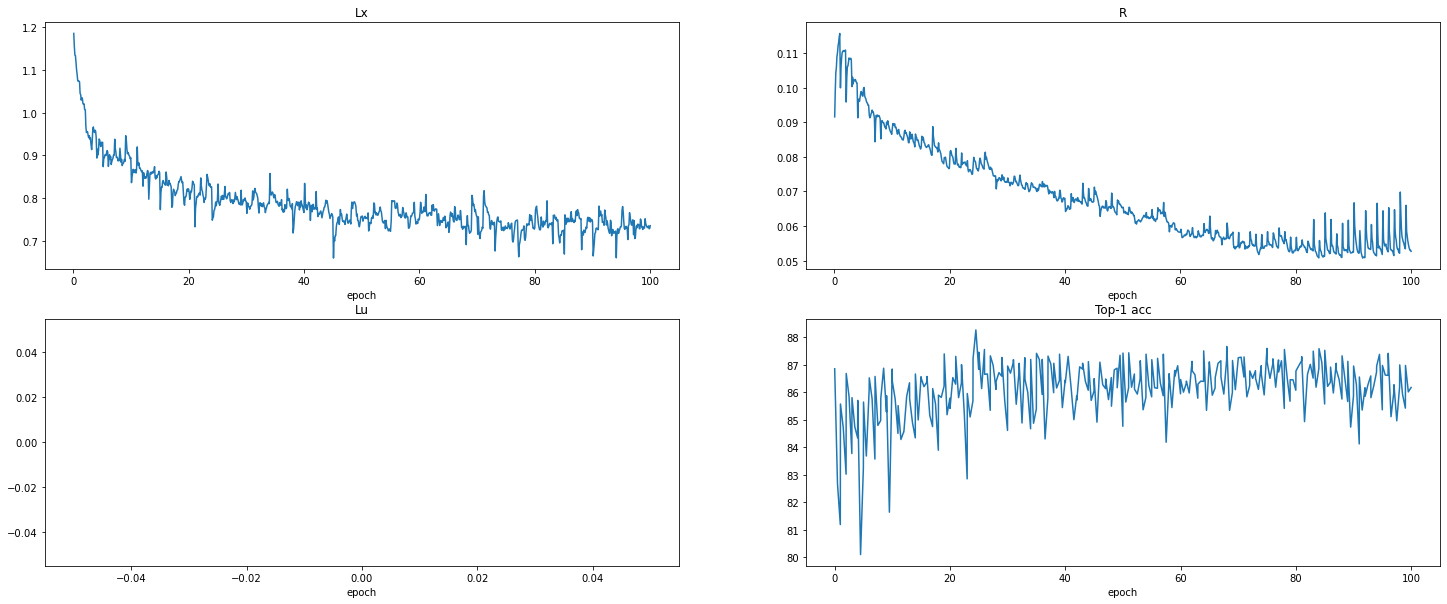

In [22]:
exp_name='no_lambda_uu'
train(cbs_labeled_trainloader, cbs_unlabeled_trainloader, model, criterion=SemiLoss(), T=0.5, alpha=0.75, train_iteration=1024, unsupervised_term=False, graph_reg=True, exp_name=exp_name, lambda_uu=0)
plot_result(torch.load(f'runs/{exp_name}.bin'))

In [23]:
# lambda_u_search
# for current_lambda_u in [2 , 5 , 10 , 15, 20, 30, 150]:
#     model.load_state_dict(torch.load(f"cifar10/clf_learning/final_model_wts.bin"))
#     train(cbs_labeled_trainloader, cbs_unlabeled_trainloader, model, criterion=SemiLoss(), T=0.5, alpha=0.75, train_iteration=1024, unsupervised_term=True, graph_reg=True, exp_name=f'reproduce_lu_{current_lambda_u}', epochs=7, lambda_u=current_lambda_u)